# Predicción de Series Temporales 

by Alina Martinez - [Github](https://github.com/martinezalina/illia-p3)

## Objetivo

Generar un modelo de predicción del último trimestre del 2019, del flujo vehicular en la Autopista Illia, modalidad pago en efectivo.




### Dataset: Flujo Vehicular por Unidades de Peaje AUSA

Dataset: Flujo Vehicular por Unidades de Peaje AUSA. 
**[Link](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa)**

### Procedimiento

Se realizará un **análisis exploratorio de datos** y resampleo en diferentes unidades de tiempo:
  - Estudiaremos valores atípicos, autocorrelación, los componentes estacionales y la tendencia de la serie. 
  - Buscaremos responder interrogantes tales como: 
    - ¿Cuáles son los días y horarios de mayor tráfico? 
    - Si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?

**Predicción** a futuro:
  - Haremos las transformaciones de datos necesarias.
  - Eligiremos una métrica apropiada para evaluar el resultado de los modelos.
  - Definiremos un modelo benckmark y compararemos los resultados con otros modelos.
  - Optimizaremos el modelo elegido con hiperparámetros y evaluaremos los resultados.
  - Analizaremos qué información está usando el modelo para predecir.
  - Evaluaremos cómo funciona el modelo para predecir el 2020.

Paralelamente **investigaremos** por dentro y fuera del dataset el comportamiento y las tendencias.

## Otros disparadores

¿Es posible incorporar la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?

¿Qué ocurre si comparamos las series de tiempo entre distintas estaciones de peajes? ¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que nos ayude a explicar lo que encontramos?

¿Hay algo que podríamos investigar o probar más alla de lo planteado inicialmente?


## Seteos iniciales

### Installación de Librerías extras

In [1]:
#pip install plotly==4.11.0

In [2]:
#pip install tensorflow

In [3]:
#pip install keras

### Importamos las Librerías que vamos a utilizar

In [4]:
from IPython.display import display, Markdown
import datetime, warnings, itertools

#Warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
#from numpy import concatenate
#import matplotlib.pylab as plt

%matplotlib inline

from math import sqrt

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from plotly import express as px
from plotly import graph_objects as go
from plotly import figure_factory as ff
from plotly.subplots import make_subplots

import seaborn as sns

from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,LSTM

#from tensorflow.python.keras.layers import Input, Dense
#from tensorflow.python.keras.models import Sequential

### Configuro Notebook

In [6]:
# Format round off to two decimal places in pandas 
pd.options.display.float_format = '{: .2f}'.format

# Gerenal Plots
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

### Funciones

In [7]:
def missing_zero_values_table(df):
    zero_val=df.isin([0]).sum(axis=0)
    mis_val=df.isnull().sum()
    l=len(df)
    mis_val_percent=100*df.isnull().sum()/l
    zero_val_percent=100*df.isin([0]).sum()/l
    mz_table=pd.concat([zero_val,zero_val_percent,mis_val,mis_val_percent],axis=1)
    mz_table=mz_table.rename(
        columns={
            0:'Zero Values', 
            1:'% of Zero Values', 
            2:'Missing Values', 
            3:'% of Missing Values'}
    )
    mz_table['Total Missing Values']=mz_table['Zero Values']+mz_table['Missing Values']
    mz_table['% Total Missing Values']=100*mz_table['Total Missing Values']/l
    mz_table=mz_table[mz_table.iloc[:,4] != 0].sort_values(
    '% Total Missing Values', ascending=False).round(1)
    tc=str(df.shape[1])
    tr=str(df.shape[0])
    tcm=str(mz_table.shape[0])
    txt='Your selected dataframe has '+str(tc)+' columns and '+str(tr)+' Rows.'
    txt+='\nThere are '+str(tcm)+' columns that have missing values.'
    display(mz_table)
    return txt

def explore_var(df,var,limit=20):
    cant=df.nunique()
    df_full = df.value_counts().rename_axis('unique_values').reset_index(name='counts')
    df_full = df_full.sort_values(by=['counts'],ascending=False)
    total = df_full['counts'].sum()
    topLimit= df_full[0:limit]
    df_full = df_full.append({'unique_values':'Total','counts':total},ignore_index=True) 
    t1='\nThere are **'+str(cant)+'** different value in the **'+str(var)+'** variable of the dataframe.'
    if cant<=1:
        t1='\nThere is **only one** different value in the **'+str(var)+'** variable of the dataframe.'
        t2 ='The value is:'  
    elif cant>=limit:
        t2='The list of the first **'+str(limit)+'**  values:'
        df_full = topLimit
    else:
        t2 ='The list of the **'+str(cant)+'**  values:'    
    display(Markdown(t1))
    display(Markdown(t2))
    return df_full

def print_columns(df):
    display(Markdown('#### List of columns:'))
    text = '| '
    for x in range(0, df.shape[1]):
        text = text + df.columns.values[x] + ' | '
    return text


## Preparación de los Dataset

### Carga de datos

#### Vía CDN
Esta modalidad de carga de datos, es directa de los servidores de CABA. Si bien demora la descarga inicial, nos permite trabajar con los datos sin tenerlos almacenados de forma local.

En caso de preferir, ejecutar el Notebook de forma 100% local, se disponen las lineas comentadas para facilitar la toma de datos de la carpeta "datasets" también incluida en este repositorio.


In [8]:
# Para cambiar la modalidad de carga de los datasets a CDN, descomentar la segunda línea.

cdn_mode = False
#cdn_mode = True


if cdn_mode:
  data_2016 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2016.csv', sep =',')
  data_2017 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2017.csv', sep =',')
  data_2018 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2018.csv', sep =',')
  data_2019 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2019.csv', sep =',')
  data_2020 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2020.csv', sep =',')
else:
  data_2016 = pd.read_csv('./datasets/flujo-vehicular-2016.csv')
  data_2017 = pd.read_csv('./datasets/flujo-vehicular-2017.csv')
  data_2018 = pd.read_csv('./datasets/flujo-vehicular-2018.csv')
  data_2019 = pd.read_csv('./datasets/flujo-vehicular-2019.csv')
  data_2020 = pd.read_csv('./datasets/flujo-vehicular-2020.csv')


### Chequeo carga

In [9]:
data_2016

periodo       fecha  hora_inicio  hora_fin      dia   estacion  \
0           2016  2016-01-01            0         1  Viernes    Alberdi   
1           2016  2016-01-01            0         1  Viernes    Alberdi   
2           2016  2016-01-01            1         2  Viernes    Alberdi   
3           2016  2016-01-01            1         2  Viernes    Alberdi   
4           2016  2016-01-01            1         2  Viernes    Alberdi   
...          ...         ...          ...       ...      ...        ...   
1379438     2016  2016-12-31           21        22   Sábado  Sarmiento   
1379439     2016  2016-12-31           22        23   Sábado  Sarmiento   
1379440     2016  2016-12-31           22        23   Sábado  Sarmiento   
1379441     2016  2016-12-31           23         0   Sábado  Sarmiento   
1379442     2016  2016-12-31           23         0   Sábado  Sarmiento   

           sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0           Centro       Liviano  NO COBRADO              32  
1           Centro       Liviano      AUPASS               9  
2           Centro       Liviano  NO COBRADO               1  
3           Centro       Liviano    EFECTIVO               4  
4           Centro       Liviano      EXENTO               3  
...            ...           ...         ...             ...  
1379438  Provincia       Liviano      AUPASS              77  
1379439  Provincia       Liviano  NO COBRADO               2  
1379440  Provincia       Liviano      AUPASS               6  
1379441  Provincia       Liviano  NO COBRADO               1  
1379442  Provincia       Liviano      AUPASS               3  

[1379443 rows x 10 columns]

In [10]:
data_2017

periodo       fecha  hora_inicio  hora_fin      dia   estacion  \
0           2017  2017-01-01            0         1  Domingo    Alberdi   
1           2017  2017-01-01            0         1  Domingo    Alberdi   
2           2017  2017-01-01            1         2  Domingo    Alberdi   
3           2017  2017-01-01            1         2  Domingo    Alberdi   
4           2017  2017-01-01            1         2  Domingo    Alberdi   
...          ...         ...          ...       ...      ...        ...   
1372640     2017  2017-12-31           22        23  Domingo  Sarmiento   
1372641     2017  2017-12-31           22        23  Domingo  Sarmiento   
1372642     2017  2017-12-31           22        23  Domingo  Sarmiento   
1372643     2017  2017-12-31           23         0  Domingo  Sarmiento   
1372644     2017  2017-12-31           23         0  Domingo  Sarmiento   

           sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0           Centro       Liviano  NO COBRADO              25  
1           Centro       Liviano    TELEPASE               7  
2           Centro       Liviano  NO COBRADO               5  
3           Centro       Liviano    EFECTIVO               2  
4           Centro       Liviano    EFECTIVO              94  
...            ...           ...         ...             ...  
1372640  Provincia       Liviano  NO COBRADO               3  
1372641  Provincia       Liviano    TELEPASE              10  
1372642  Provincia        Pesado    TELEPASE               1  
1372643  Provincia       Liviano  NO COBRADO               1  
1372644  Provincia       Liviano    TELEPASE               4  

[1372645 rows x 10 columns]

In [11]:
data_2018

periodo       fecha  hora_inicio  hora_fin    dia   estacion  \
0           2018  2018-01-01            0         1  Lunes    Alberdi   
1           2018  2018-01-01            0         1  Lunes    Alberdi   
2           2018  2018-01-01            1         2  Lunes    Alberdi   
3           2018  2018-01-01            1         2  Lunes    Alberdi   
4           2018  2018-01-01            2         3  Lunes    Alberdi   
...          ...         ...          ...       ...    ...        ...   
1375903     2018  2018-12-31           21        22  Lunes  Sarmiento   
1375904     2018  2018-12-31           21        22  Lunes  Sarmiento   
1375905     2018  2018-12-31           22        23  Lunes  Sarmiento   
1375906     2018  2018-12-31           22        23  Lunes  Sarmiento   
1375907     2018  2018-12-31           23         0  Lunes  Sarmiento   

           sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0           Centro       Liviano  NO COBRADO              29  
1           Centro       Liviano    TELEPASE               9  
2           Centro       Liviano  NO COBRADO              73  
3           Centro       Liviano    TELEPASE              39  
4           Centro       Liviano  NO COBRADO             115  
...            ...           ...         ...             ...  
1375903  Provincia       Liviano    TELEPASE              62  
1375904  Provincia        Pesado    TELEPASE               1  
1375905  Provincia       Liviano  NO COBRADO               3  
1375906  Provincia       Liviano    TELEPASE              13  
1375907  Provincia       Liviano  NO COBRADO               3  

[1375908 rows x 10 columns]

In [12]:
data_2019

periodo       fecha  hora_inicio  hora_fin     dia    estacion  \
0          2019  2019-01-01            0         1  Martes     Alberti   
1          2019  2019-01-01            0         1  Martes     Alberti   
2          2019  2019-01-01            0         1  Martes     Alberti   
3          2019  2019-01-01            0         1  Martes     Alberti   
4          2019  2019-01-01            0         1  Martes  Avellaneda   
...         ...         ...          ...       ...     ...         ...   
812148     2019  2019-12-31           23         0  Martes    Salguero   
812149     2019  2019-12-31           23         0  Martes    Salguero   
812150     2019  2019-12-31           23         0  Martes    Salguero   
812151     2019  2019-12-31           23         0  Martes   Sarmiento   
812152     2019  2019-12-31           23         0  Martes   Sarmiento   

          sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0          Centro       Liviano  NO COBRADO              22  
1          Centro       Liviano    TELEPASE               6  
2       Provincia       Liviano  NO COBRADO              53  
3       Provincia       Liviano    TELEPASE              18  
4          Centro       Liviano    EFECTIVO              16  
...           ...           ...         ...             ...  
812148  Provincia       Liviano  NO COBRADO               7  
812149  Provincia       Liviano    TELEPASE               4  
812150  Provincia        Pesado  NO COBRADO               1  
812151  Provincia       Liviano  NO COBRADO               7  
812152  Provincia       Liviano    TELEPASE               7  

[812153 rows x 10 columns]

In [13]:
data_2020

periodo       fecha    mes        dia  dia_fecha  hora_inicio  \
0          2020  2020-01-01  enero  Miércoles          1            0   
1          2020  2020-01-01  enero  Miércoles          1            0   
2          2020  2020-01-01  enero  Miércoles          1            0   
3          2020  2020-01-01  enero  Miércoles          1            0   
4          2020  2020-01-01  enero  Miércoles          1            0   
...         ...         ...    ...        ...        ...          ...   
678730     2020  2020-03-31  marzo     Martes         31           23   
678731     2020  2020-03-31  marzo     Martes         31           23   
678732     2020  2020-03-31  marzo     Martes         31           23   
678733     2020  2020-03-31  marzo     Martes         31           23   
678734     2020  2020-03-31  marzo     Martes         31           23   

        hora_fin estacion   tipo_vehiculo forma_pago  \
0              1  ALBERDI            Auto   Efectivo   
1              1  ALBERDI            Auto   Efectivo   
2              1  ALBERDI            Auto  Rec.Deuda   
3              1  ALBERDI            Auto  Rec.Deuda   
4              1  ALBERDI            Auto  Rec.Deuda   
...          ...      ...             ...        ...   
678730         0      ILP  Pesados 6 Ejes  Violación   
678731         0      PB1  Pesados 6 Ejes        Tag   
678732         0      PB1  Pesados 6 Ejes  Violación   
678733         0      PB4  Pesados 6 Ejes        Tag   
678734         0      PB4  Pesados 6 Ejes  Violación   

                             observacion    sentido  cantidad_pasos  
0                               Efectivo     Centro              24  
1                               Efectivo  Provincia              80  
2                     Paso en Infracción  Provincia               1  
3       Paso en infracción con Multa LPR     Centro               1  
4       Paso en infracción con Multa LPR  Provincia               1  
...                                  ...        ...             ...  
678730                Violación - Normal  Provincia               1  
678731                     Tag - PosPago  Provincia              14  
678732                Violación - Normal  Provincia               2  
678733                     Tag - PosPago     Centro               6  
678734                Violación - Normal     Centro               1  

[678735 rows x 13 columns]

## Exploración Inicial
Investigo que valores toman los campos `estacion`, `sentido`, `tipo_vehiculo` y `forma_pago`.

### Estaciones

In [14]:
print('Estaciones en 2020')
print(data_2020['estacion'].unique())
print('\nEstaciones en 2019')
print(data_2019['estacion'].unique())
print('\nEstaciones en 2018')
print(data_2018['estacion'].unique())
print('\nEstaciones en 2017')
print(data_2017['estacion'].unique())
print('\nEstaciones en 2016')
print(data_2016['estacion'].unique())

Estaciones en 2020
['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']

Estaciones en 2019
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']

Estaciones en 2018
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

Estaciones en 2017
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

Estaciones en 2016
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


### Sentido

In [15]:
print('Sentido en 2020')
print(data_2020['sentido'].unique())
print('Sentido en 2019')
print(data_2019['sentido'].unique())
print('\nSentido en 2018')
print(data_2018['sentido'].unique())
print('\nSentido en 2017')
print(data_2017['sentido'].unique())
print('\nSentido en 2016')
print(data_2016['sentido'].unique())

Sentido en 2020
['Centro' 'Provincia']
Sentido en 2019
['Centro' 'Provincia']

Sentido en 2018
['Centro' 'Provincia']

Sentido en 2017
['Centro' 'Provincia']

Sentido en 2016
['Centro' 'Provincia']


### Tipo de Vehículo

In [16]:
print('Tipo de Vehículo en 2020')
print(data_2020['tipo_vehiculo'].unique())
print('Tipo de Vehículo en 2019')
print(data_2019['tipo_vehiculo'].unique())
print('\nTipo de Vehículo en 2018')
print(data_2018['tipo_vehiculo'].unique())
print('\nTipo de Vehículo en 2017')
print(data_2017['tipo_vehiculo'].unique())
print('\nTipo de Vehículo en 2016')
print(data_2016['tipo_vehiculo'].unique())

Tipo de Vehículo en 2020
['Auto' 'Auto con trailer' 'Moto' 'N/D' 'Pago Doble Auto'
 'Pago Doble Auto con trailer / Pesado 2 Ejes' 'Pago doble Moto'
 'Pesados 2 Ejes' 'Pesados 3 Ejes' 'Pesados 4 Ejes' 'Pesados 5 Ejes'
 'Pesados 6 Ejes']
Tipo de Vehículo en 2019
['Liviano' 'Pesado']

Tipo de Vehículo en 2018
['Liviano' 'Pesado']

Tipo de Vehículo en 2017
['Liviano' 'Pesado']

Tipo de Vehículo en 2016
['Liviano' 'Pesado']


### Forma de Pago

In [17]:
print('Forma de Pago en 2020')
print(data_2020['forma_pago'].unique())
print('Forma de Pago en 2019')
print(data_2019['forma_pago'].unique())
print('\nForma de Pago en 2018')
print(data_2018['forma_pago'].unique())
print('\nForma de Pago en 2017')
print(data_2017['forma_pago'].unique())
print('\nForma de Pago en 2016')
print(data_2016['forma_pago'].unique())

Forma de Pago en 2020
['Efectivo' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP']
Forma de Pago en 2019
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']

Forma de Pago en 2018
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']

Forma de Pago en 2017
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']

Forma de Pago en 2016
['NO COBRADO' 'AUPASS' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO']


### Observación

Campo detectado sólo en 2020.

In [18]:
print('Observación en 2020')
print(data_2020['observacion'].unique())

Observación en 2020
['Efectivo' 'Paso en Infracción' 'Paso en infracción con Multa LPR'
 'T.Magnética Disc.' 'Tag - PosPago' 'Tag - PosPago OCR' 'Tag - PrePago'
 'Exento - Reglamento' 'Tag - PrePago OCR' 'Violación - Normal'
 'Exento - Otros motivos' 'Exento - Demora en cobro'
 'Violación - Via Liberada' 'Violación - Rebote' 'Violación - Repetitiva'
 'Paso a facturar - (colectivo)' 'Metrobus no hab. TAG pospago'
 'Violación - Vía Cerrada' 'Paso en Infracción con Multa' 'Obs CPP']


### **Campos de los datasets**

Podemos decir entonces que los años 2016, 2017, 2018, 2019  y 2020 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dataset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: Estaciones de peaje. 

Difieren levemente entre los años 2016 a 2019 (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB). 

En 2020, cambian PDB por PB1, PB2, PB3 y PB4. También agregan ILP. A su vez, separan Dellepiane en DELLEPIANE CENTRO y DELLEPIANE LINIERS.

**sentido**: Centro o Provincia

**tipo_vehiculo**: Desde 2016 a 2019 se divide en Liviano o Pesado. A partir del 2020, se agregan varias categorías para ser más específicos:
- Auto
- Auto con trailer
- Moto
- N/D
- Pago Doble Auto
- Pago Doble Auto con trailer / Pesado 2 Ejes
- Pago doble Moto
- Pesados 2 Ejes
- Pesados 3 Ejes
- Pesados 4 Ejes
- Pesados 5 Ejes
- Pesados 6 Ejes

**forma_pago**: Hay varias y varian entre los años. La que se mantiene siempre es Efectivo. El 2020, es el que más difiere de todos los años:
- Efectivo
- Rec.Deuda
- Tarjeta Magnética
- Tag
- Exento
- Violación
- CPP

**cantidad_pasos**: Cantidad de vehiculos

**observacion**: Es un campo añadido en 2020, donde se aprecia una vinculación directa con la forma de pago.

## Illia Efectivo
A partir de este momento, nos focalizaremos en el estudio de cantidad de vehículos de la estación de los años **2016 a 2019**, en la Autopista **Illia** y la forma de pago **Efectivo**.

### Volumen de datos por año

In [19]:
display(Markdown('**Cantidad de pasos registrados por hora en Au.Illia**'))

print('\nAño 2016:')
all_2016 = "{:,}".format(data_2016[data_2016["estacion"] == "Illia"].cantidad_pasos.count())
mdp_cash_2016 = "{:,}".format(
    data_2016[(data_2016["estacion"] == "Illia") & (data_2016["forma_pago"] == "EFECTIVO")].cantidad_pasos.count()
)
print('- Todos los medios de pago:', all_2016)
print('- Pago Efectivo:', mdp_cash_2016,'\n')

print('Año 2017:')
all_2017 = "{:,}".format(data_2017[data_2017["estacion"] == "Illia"].cantidad_pasos.count())
mdp_cash_2017 = "{:,}".format(
    data_2017[(data_2017["estacion"] == "Illia") & (data_2017["forma_pago"] == "EFECTIVO")].cantidad_pasos.count()
)
print('- Todos los medios de pago:', all_2017)
print('- Pago Efectivo:', mdp_cash_2017,'\n')

print('Año 2018:')
all_2018 = "{:,}".format(data_2018[data_2018["estacion"] == "Illia"].cantidad_pasos.count())
mdp_cash_2018 = "{:,}".format(
    data_2018[(data_2018["estacion"] == "Illia") & (data_2018["forma_pago"] == "EFECTIVO")].cantidad_pasos.count()
)
print('- Todos los medios de pago:', all_2018)
print('- Pago Efectivo:', mdp_cash_2018,'\n')

print('Año 2019:')
all_2019 = "{:,}".format(data_2019[data_2019["estacion"] == "Illia"].cantidad_pasos.count())
mdp_cash_2019 = "{:,}".format(
    data_2019[(data_2019["estacion"] == "Illia") & (data_2019["forma_pago"] == "EFECTIVO")].cantidad_pasos.count()
)
print('- Todos los medios de pago:',all_2019)
print('- Pago Efectivo:',mdp_cash_2019)

**Cantidad de pasos registrados por hora en Au.Illia**


Año 2016:
- Todos los medios de pago: 302,910
- Pago Efectivo: 107,697 

Año 2017:
- Todos los medios de pago: 291,900
- Pago Efectivo: 104,230 

Año 2018:
- Todos los medios de pago: 299,519
- Pago Efectivo: 99,996 

Año 2019:
- Todos los medios de pago: 161,133
- Pago Efectivo: 34,643


Analizando la cantidad de pasos por hora, encontramos que
entre el 2016 a 2018, si bien hay una caída en la cantidad de pasos, no es tan abrupta como en el 2019. Donde se disminuye casi al 50% la cantidad de pasos para todos los medios de pago y, en efectivo sólo hay un 30% de pasos registrados respecto al año anterior.

In [20]:
display(Markdown('**Cantidad de vehículos registrados en Au.Illia**'))

print('\nAño 2016:')
all_2016 = "{:,}".format(data_2016[data_2016["estacion"] == "Illia"].cantidad_pasos.sum())
mdp_cash_2016 = "{:,}".format(
    data_2016[(data_2016["estacion"] == "Illia") & (data_2016["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()
)
print('- Todos los medios de pago:', all_2016)
print('- Pago Efectivo:', mdp_cash_2016,'\n')

print('Año 2017:')
all_2017 = "{:,}".format(data_2017[data_2017["estacion"] == "Illia"].cantidad_pasos.sum())
mdp_cash_2017 = "{:,}".format(
    data_2017[(data_2017["estacion"] == "Illia") & (data_2017["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()
)
print('- Todos los medios de pago:', all_2017)
print('- Pago Efectivo:', mdp_cash_2017,'\n')

print('Año 2018:')
all_2018 = "{:,}".format(data_2018[data_2018["estacion"] == "Illia"].cantidad_pasos.sum())
mdp_cash_2018 = "{:,}".format(
    data_2018[(data_2018["estacion"] == "Illia") & (data_2018["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()
)
print('- Todos los medios de pago:', all_2018)
print('- Pago Efectivo:', mdp_cash_2018,'\n')

print('Año 2019:')
all_2019 = "{:,}".format(data_2019[data_2019["estacion"] == "Illia"].cantidad_pasos.sum())
mdp_cash_2019 = "{:,}".format(
    data_2019[(data_2019["estacion"] == "Illia") & (data_2019["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()
)
print('- Todos los medios de pago:',all_2019)
print('- Pago Efectivo:',mdp_cash_2019)

**Cantidad de vehículos registrados en Au.Illia**


Año 2016:
- Todos los medios de pago: 33,924,611
- Pago Efectivo: 19,221,423 

Año 2017:
- Todos los medios de pago: 33,570,584
- Pago Efectivo: 17,783,512 

Año 2018:
- Todos los medios de pago: 34,490,038
- Pago Efectivo: 15,966,944 

Año 2019:
- Todos los medios de pago: 34,155,167
- Pago Efectivo: 14,115,125


Si observamos la sumatoria de los pasos en el año, se puede apreciar como de 2016 a 2019 se mantiene con algunas variaciones la cantidad de pasos en todos los medios de pago. 
Ahora, ya se denota una caída año tras año, en la modalidad pago en efectivo.

### Unificación de datasets
Generamos un dataframe para AU Illia, medio de pago Efectivo.

In [21]:
#Unimos los 4 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017, data_2016])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset_illia_ef = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset_illia_ef.drop(columns = ['hora_inicio','estacion'], inplace = True)

dataset_illia_ef

periodo       fecha  hora_fin     dia    sentido tipo_vehiculo  \
80          2019  2019-01-01         2  Martes     Centro       Liviano   
86          2019  2019-01-01         2  Martes     Centro        Pesado   
88          2019  2019-01-01         2  Martes  Provincia       Liviano   
94          2019  2019-01-01         2  Martes  Provincia        Pesado   
149         2019  2019-01-01         3  Martes     Centro       Liviano   
...          ...         ...       ...     ...        ...           ...   
1379039     2016  2016-12-31        22  Sábado  Provincia       Liviano   
1379042     2016  2016-12-31        22  Sábado  Provincia        Pesado   
1379046     2016  2016-12-31        23  Sábado  Provincia       Liviano   
1379048     2016  2016-12-31        23  Sábado  Provincia       Liviano   
1379053     2016  2016-12-31        23  Sábado  Provincia        Pesado   

        forma_pago  cantidad_pasos  
80        EFECTIVO             537  
86        EFECTIVO               1  
88        EFECTIVO             443  
94        EFECTIVO               1  
149       EFECTIVO             769  
...            ...             ...  
1379039   EFECTIVO             788  
1379042   EFECTIVO               3  
1379046   EFECTIVO               5  
1379048   EFECTIVO             207  
1379053   EFECTIVO               5  

[346566 rows x 8 columns]

In [22]:
# También generamos la unificación de la estación Illia con todas las formas de pago, para todos los años que están completos
dataset_illia_2016 = data_2016.loc[data_2016['estacion']=='Illia']
dataset_illia_2017 = data_2017.loc[data_2017['estacion']=='Illia']
dataset_illia_2018 = data_2018.loc[data_2018['estacion']=='Illia']
dataset_illia_2019 = data_2019.loc[data_2019['estacion']=='Illia']

#Unimos los 4 datasets
dataset_illia = pd.concat([dataset_illia_2019, dataset_illia_2018, dataset_illia_2017, dataset_illia_2016])
dataset_illia

periodo       fecha  hora_inicio  hora_fin     dia estacion  \
19          2019  2019-01-01            0         1  Martes    Illia   
20          2019  2019-01-01            0         1  Martes    Illia   
21          2019  2019-01-01            0         1  Martes    Illia   
22          2019  2019-01-01            0         1  Martes    Illia   
23          2019  2019-01-01            0         1  Martes    Illia   
...          ...         ...          ...       ...     ...      ...   
1379051     2016  2016-12-31           22        23  Sábado    Illia   
1379052     2016  2016-12-31           22        23  Sábado    Illia   
1379053     2016  2016-12-31           22        23  Sábado    Illia   
1379054     2016  2016-12-31           23         0  Sábado    Illia   
1379055     2016  2016-12-31           23         0  Sábado    Illia   

           sentido tipo_vehiculo  forma_pago  cantidad_pasos  
19          Centro       Liviano  NO COBRADO             146  
20          Centro       Liviano    TELEPASE              59  
21          Centro        Pesado    TELEPASE               1  
22       Provincia       Liviano  NO COBRADO             147  
23       Provincia       Liviano    TELEPASE             106  
...            ...           ...         ...             ...  
1379051  Provincia       Liviano      AUPASS              46  
1379052  Provincia        Pesado      EXENTO               1  
1379053  Provincia        Pesado    EFECTIVO               5  
1379054  Provincia       Liviano  NO COBRADO             103  
1379055  Provincia       Liviano      AUPASS              22  

[1055462 rows x 10 columns]

### Transformación a datetime
Con los datos del dataframe, generamos una columna de tipo datetime.

In [23]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_illia_ef['fecha2'] = pd.to_datetime(dataset_illia_ef.fecha) + pd.to_timedelta(dataset_illia_ef.hora_fin, unit = 'h')

#Quitamos las columnas que ya no vamos a utilizar
dataset_illia_ef.drop(columns=['periodo', 'dia','fecha','hora_fin','forma_pago'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset_illia_ef.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset_illia_ef.sort_values('fecha', inplace = True)
dataset_illia_ef.reset_index(drop=True, inplace = True)

In [24]:
dataset_illia_ef

sentido tipo_vehiculo  cantidad_pasos               fecha
0          Centro       Liviano              14 2016-01-01 00:00:00
1          Centro        Pesado               3 2016-01-01 00:00:00
2       Provincia       Liviano              66 2016-01-01 00:00:00
3       Provincia        Pesado               1 2016-01-01 00:00:00
4       Provincia        Pesado               4 2016-01-01 00:00:00
...           ...           ...             ...                 ...
346561  Provincia       Liviano             556 2019-12-31 22:00:00
346562  Provincia        Pesado               1 2019-12-31 22:00:00
346563     Centro       Liviano             580 2019-12-31 22:00:00
346564     Centro       Liviano             214 2019-12-31 23:00:00
346565  Provincia       Liviano             190 2019-12-31 23:00:00

[346566 rows x 4 columns]

In [25]:
#dataset_illia_ef.info()
dataset_illia_ef.dtypes

sentido                   object
tipo_vehiculo             object
cantidad_pasos             int64
fecha             datetime64[ns]
dtype: object

In [26]:
# También generamos la transformación para el dataset con todas las formas de pago

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_illia['fecha2'] = pd.to_datetime(dataset_illia.fecha) + pd.to_timedelta(dataset_illia.hora_fin, unit = 'h')

#Quitamos las columnas que ya no vamos a utilizar
dataset_illia.drop(columns=['periodo', 'dia','fecha','hora_inicio','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset_illia.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset_illia.sort_values('fecha', inplace = True)
dataset_illia.reset_index(drop=True, inplace = True)

In [27]:
dataset_illia

estacion    sentido tipo_vehiculo            forma_pago  \
0          Illia     Centro       Liviano            NO COBRADO   
1          Illia  Provincia        Pesado              EFECTIVO   
2          Illia  Provincia       Liviano                AUPASS   
3          Illia  Provincia       Liviano            INFRACCION   
4          Illia  Provincia       Liviano  TARJETA DISCAPACIDAD   
...          ...        ...           ...                   ...   
1055457    Illia     Centro       Liviano              TELEPASE   
1055458    Illia     Centro       Liviano            NO COBRADO   
1055459    Illia     Centro       Liviano            INFRACCION   
1055460    Illia     Centro       Liviano                EXENTO   
1055461    Illia     Centro       Liviano              EFECTIVO   

         cantidad_pasos               fecha  
0                     1 2016-01-01 00:00:00  
1                     4 2016-01-01 00:00:00  
2                   141 2016-01-01 00:00:00  
3                     2 2016-01-01 00:00:00  
4                     3 2016-01-01 00:00:00  
...                 ...                 ...  
1055457             122 2019-12-31 23:00:00  
1055458               3 2019-12-31 23:00:00  
1055459               4 2019-12-31 23:00:00  
1055460               1 2019-12-31 23:00:00  
1055461             214 2019-12-31 23:00:00  

[1055462 rows x 6 columns]

In [28]:
dataset_illia.dtypes

estacion                  object
sentido                   object
tipo_vehiculo             object
forma_pago                object
cantidad_pasos             int64
fecha             datetime64[ns]
dtype: object

### Fragmentación por años
Con el dataframe resultante generamos la fragmentación por años para una mayor comodidad.

#### Fragmentación 2016

In [29]:
dataset_illia_ef_2016 = dataset_illia_ef[
                     (dataset_illia_ef['fecha'] >= '2016-01-01 00:00:00') &
                     (dataset_illia_ef['fecha'] <= '2016-12-31 23:00:00')
                    ]
dataset_illia_ef_2016

sentido tipo_vehiculo  cantidad_pasos               fecha
0          Centro       Liviano              14 2016-01-01 00:00:00
1          Centro        Pesado               3 2016-01-01 00:00:00
2       Provincia       Liviano              66 2016-01-01 00:00:00
3       Provincia        Pesado               1 2016-01-01 00:00:00
4       Provincia        Pesado               4 2016-01-01 00:00:00
...           ...           ...             ...                 ...
107692  Provincia       Liviano             207 2016-12-31 23:00:00
107693  Provincia        Pesado               5 2016-12-31 23:00:00
107694     Centro       Liviano              10 2016-12-31 23:00:00
107695     Centro       Liviano             224 2016-12-31 23:00:00
107696  Provincia       Liviano               5 2016-12-31 23:00:00

[107697 rows x 4 columns]

#### Fragmentación 2017

In [30]:
dataset_illia_ef_2017 = dataset_illia_ef[
                     (dataset_illia_ef['fecha'] >= '2017-01-01 00:00:00') &
                     (dataset_illia_ef['fecha'] <= '2017-12-31 23:00:00')
                    ]
dataset_illia_ef_2017

sentido tipo_vehiculo  cantidad_pasos               fecha
107697     Centro        Pesado               1 2017-01-01 00:00:00
107698     Centro        Pesado              10 2017-01-01 00:00:00
107699     Centro        Pesado              21 2017-01-01 00:00:00
107700     Centro        Pesado               1 2017-01-01 00:00:00
107701  Provincia       Liviano               9 2017-01-01 00:00:00
...           ...           ...             ...                 ...
211922     Centro        Pesado               1 2017-12-31 23:00:00
211923  Provincia        Pesado               1 2017-12-31 23:00:00
211924     Centro       Liviano             151 2017-12-31 23:00:00
211925     Centro        Pesado               1 2017-12-31 23:00:00
211926     Centro       Liviano               8 2017-12-31 23:00:00

[104230 rows x 4 columns]

#### Fragmentación 2018

In [31]:
dataset_illia_ef_2018 = dataset_illia_ef[
                     (dataset_illia_ef['fecha'] >= '2018-01-01 00:00:00') &
                     (dataset_illia_ef['fecha'] <= '2018-12-31 23:00:00')
                    ]
dataset_illia_ef_2018

sentido tipo_vehiculo  cantidad_pasos               fecha
211927     Centro        Pesado               1 2018-01-01 00:00:00
211928     Centro        Pesado               8 2018-01-01 00:00:00
211929     Centro        Pesado               2 2018-01-01 00:00:00
211930     Centro       Liviano             919 2018-01-01 00:00:00
211931  Provincia       Liviano              14 2018-01-01 00:00:00
...           ...           ...             ...                 ...
311918  Provincia       Liviano             203 2018-12-31 23:00:00
311919     Centro       Liviano             239 2018-12-31 23:00:00
311920     Centro        Pesado               1 2018-12-31 23:00:00
311921  Provincia       Liviano              11 2018-12-31 23:00:00
311922     Centro       Liviano               7 2018-12-31 23:00:00

[99996 rows x 4 columns]

#### Fragmentación 2019

In [32]:
dataset_illia_ef_2019 = dataset_illia_ef[
                     (dataset_illia_ef['fecha'] >= '2019-01-01 00:00:00') &
                     (dataset_illia_ef['fecha'] <= '2019-12-31 23:00:00')
                    ]
dataset_illia_ef_2019

sentido tipo_vehiculo  cantidad_pasos               fecha
311923     Centro       Liviano             644 2019-01-01 00:00:00
311924     Centro        Pesado               3 2019-01-01 00:00:00
311925  Provincia       Liviano             630 2019-01-01 00:00:00
311926  Provincia        Pesado               9 2019-01-01 00:00:00
311927     Centro        Pesado               1 2019-01-01 02:00:00
...           ...           ...             ...                 ...
346561  Provincia       Liviano             556 2019-12-31 22:00:00
346562  Provincia        Pesado               1 2019-12-31 22:00:00
346563     Centro       Liviano             580 2019-12-31 22:00:00
346564     Centro       Liviano             214 2019-12-31 23:00:00
346565  Provincia       Liviano             190 2019-12-31 23:00:00

[34643 rows x 4 columns]

#### Fragmentación 2017-2019

In [33]:
dataset_illia_ef_2017_2019 = dataset_illia_ef[
                     (dataset_illia_ef['fecha'] >= '2017-01-01 00:00:00') &
                     (dataset_illia_ef['fecha'] <= '2019-12-31 23:00:00')
                    ]
dataset_illia_ef_2017_2019

sentido tipo_vehiculo  cantidad_pasos               fecha
107697     Centro        Pesado               1 2017-01-01 00:00:00
107698     Centro        Pesado              10 2017-01-01 00:00:00
107699     Centro        Pesado              21 2017-01-01 00:00:00
107700     Centro        Pesado               1 2017-01-01 00:00:00
107701  Provincia       Liviano               9 2017-01-01 00:00:00
...           ...           ...             ...                 ...
346561  Provincia       Liviano             556 2019-12-31 22:00:00
346562  Provincia        Pesado               1 2019-12-31 22:00:00
346563     Centro       Liviano             580 2019-12-31 22:00:00
346564     Centro       Liviano             214 2019-12-31 23:00:00
346565  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 4 columns]

### Exploración de datos

#### Estadísticos

In [34]:
display(dataset_illia_ef.describe())

cantidad_pasos
count       346566.00
mean           193.58
std            409.65
min              1.00
25%              2.00
50%             11.00
75%             79.00
max           2575.00

#### Promedio y Desviación estandar
Almacenamos el promedio y la desviación estandar en variables.

In [35]:
mean_illia_ef = dataset_illia_ef.cantidad_pasos.mean()
print(mean_illia_ef)
std_illia_ef = dataset_illia_ef.cantidad_pasos.std()
display(std_illia_ef)

193.57641545910448


409.6451492702559

El **promedio** de vechiculos por hora es de 193, y la **desviación estandar** 409. 

#### Mayor flujo vechicular

**Días y horarios que superen el promedio + std**

Exploramos todas las fechas y horas cuyo registro de autos supere al promedio + desviacion estandar:




In [36]:
dataset_illia_ef_hights = dataset_illia_ef[
                     (dataset_illia_ef['cantidad_pasos'] > (mean_illia_ef + std_illia_ef))
                    ]
dataset_illia_ef_hights

sentido tipo_vehiculo  cantidad_pasos               fecha
9          Centro       Liviano             649 2016-01-01 00:00:00
96         Centro       Liviano             647 2016-01-01 13:00:00
102     Provincia       Liviano             729 2016-01-01 13:00:00
104     Provincia       Liviano             803 2016-01-01 14:00:00
111        Centro       Liviano             618 2016-01-01 14:00:00
...           ...           ...             ...                 ...
346546  Provincia       Liviano             643 2019-12-31 18:00:00
346552  Provincia       Liviano             640 2019-12-31 19:00:00
346555  Provincia       Liviano             773 2019-12-31 20:00:00
346558  Provincia       Liviano             905 2019-12-31 21:00:00
346559     Centro       Liviano             799 2019-12-31 21:00:00

[45338 rows x 4 columns]

##### Ranking Histórico

Ordenamos de forma secuencial ascendente los datos acumulados, con el propósito de obtener los rankins históricos.

In [37]:
dataset_illia_ef_hights.sort_values('cantidad_pasos', ascending=False, inplace=True)
dataset_illia_ef_hights.head(10)

sentido tipo_vehiculo  cantidad_pasos               fecha
73918   Centro       Liviano            2575 2016-09-11 20:00:00
63518   Centro       Liviano            2559 2016-08-07 19:00:00
78146   Centro       Liviano            2554 2016-09-25 18:00:00
39980   Centro       Liviano            2481 2016-05-19 18:00:00
63524   Centro       Liviano            2481 2016-08-07 20:00:00
78159   Centro       Liviano            2478 2016-09-25 19:00:00
182934  Centro       Liviano            2416 2017-09-17 19:00:00
86616   Centro       Liviano            2396 2016-10-23 19:00:00
63503   Centro       Liviano            2381 2016-08-07 18:00:00
81728   Centro       Liviano            2362 2016-10-07 12:00:00

##### Hora de mayor flujo vechicular

In [38]:
print("\nHour:")
print(dataset_illia_ef.fecha.dt.hour)


Hour:
0          0
1          0
2          0
3          0
4          0
          ..
346561    22
346562    22
346563    22
346564    23
346565    23
Name: fecha, Length: 346566, dtype: int64


In [39]:
hours = dataset_illia_ef.groupby(dataset_illia_ef.fecha.dt.hour).sum().sort_values('cantidad_pasos', ascending=False)
hours

cantidad_pasos
fecha                
18            4369256
19            4334134
17            4202054
14            4184971
16            4132402
15            4071843
13            4058338
12            3837624
20            3722316
11            3634518
9             3572828
10            3536420
21            3274794
8             3237709
22            2614222
7             2169558
23            1959254
0             1454708
1             1205099
6             1075146
2              840159
3              583057
5              558886
4              457708

Las horas con mayor acumulación de pagos en efectivo son las 18hs y 19hs. 

#####  Nro. de día de mayor flujo vechicular

In [40]:
print("\nDays:")
print(dataset_illia_ef.fecha.dt.day)


Days:
0          1
1          1
2          1
3          1
4          1
          ..
346561    31
346562    31
346563    31
346564    31
346565    31
Name: fecha, Length: 346566, dtype: int64


In [41]:
days = dataset_illia_ef.groupby(dataset_illia_ef.fecha.dt.day).sum().sort_values('cantidad_pasos', ascending=False)
days

cantidad_pasos
fecha                
16            2290462
22            2286655
14            2281180
7             2278903
12            2277460
15            2276878
23            2266574
11            2244030
19            2238754
5             2238042
28            2229628
21            2227191
18            2222980
27            2221594
2             2218365
17            2211776
4             2211702
26            2210739
10            2206109
3             2206013
13            2193554
8             2191762
20            2189335
6             2183497
9             2136756
24            2107613
1             2074470
29            2011542
25            2011496
30            1911886
31            1230058

El día 16, es el que más pagos en efectivo acumula.

##### Día de la semana de mayor flujo vechicular

In [42]:
print("\nWeekday:")
dataset_illia_ef.fecha.dt.day_name()


Weekday:


0          Friday
1          Friday
2          Friday
3          Friday
4          Friday
           ...   
346561    Tuesday
346562    Tuesday
346563    Tuesday
346564    Tuesday
346565    Tuesday
Name: fecha, Length: 346566, dtype: object

In [43]:
day_name = dataset_illia_ef.groupby(dataset_illia_ef.fecha.dt.day_name()).sum().sort_values('cantidad_pasos', ascending=False)
day_name

cantidad_pasos
fecha                    
Friday           10752027
Thursday         10368302
Wednesday        10088635
Tuesday           9696531
Monday            9454937
Saturday          8852940
Sunday            7873632

El viernes es el día de mayor acumulación de pases.

##### Mes de mayor flujo vechicular

In [44]:
print("\nMonth:")
dataset_illia_ef.fecha.dt.month


Month:


0          1
1          1
2          1
3          1
4          1
          ..
346561    12
346562    12
346563    12
346564    12
346565    12
Name: fecha, Length: 346566, dtype: int64

In [45]:
month = dataset_illia_ef.groupby(
    dataset_illia_ef.fecha.dt.month
    ).sum().sort_values('cantidad_pasos', ascending=False)
month

cantidad_pasos
fecha                
3             5842414
10            5765537
7             5730069
8             5726671
11            5698220
12            5632531
1             5625201
9             5566797
5             5530344
4             5424968
6             5276600
2             5267652

Marzo es el mes con mayor acumulación de pagos en efectivo.

##### Año de mayor flujo vechicular

In [46]:
print("\nYear:")
dataset_illia_ef.fecha.dt.year


Year:


0         2016
1         2016
2         2016
3         2016
4         2016
          ... 
346561    2019
346562    2019
346563    2019
346564    2019
346565    2019
Name: fecha, Length: 346566, dtype: int64

In [47]:
year = dataset_illia_ef.groupby(dataset_illia_ef.fecha.dt.year).sum().sort_values('cantidad_pasos', ascending=False)
year

cantidad_pasos
fecha                
2016         19221423
2017         17783512
2018         15966944
2019         14115125

Secuencialmente, se obtiene como el 2016 es el año que acumula mayor cantidad de pagos en efectivo.

Claramente se puede observar, como esta modalidad de pago queda en desuso, año tras año,

##### Sentido de mayor flujo vechicular

In [48]:
sentido = dataset_illia_ef.groupby("sentido").sum().sort_values('cantidad_pasos', ascending=False)
sentido

cantidad_pasos
sentido                  
Centro           35097476
Provincia        31989528

#### Serie de Tiempo x Sentido

In [49]:
#Filtro por sentido
x0_sentido = pd.DataFrame()
x0_sentido = dataset_illia_ef[dataset_illia_ef['sentido'] =='Centro']
x1_sentido = pd.DataFrame()
x1_sentido = dataset_illia_ef[dataset_illia_ef['sentido'] =='Provincia']

#Elimino las columnas que no voy a utilizar
x0_sentido.drop(columns=['sentido','tipo_vehiculo'], inplace = True)
x1_sentido.drop(columns=['sentido','tipo_vehiculo'], inplace = True)

#Resampleo nuestros datos para agrupar por semana
x0_sentido_w = x0_sentido.resample('W', on = 'fecha').sum()
x1_sentido_w = x1_sentido.resample('W', on = 'fecha').sum()

#Genero la serie de tiempo por sentido
sentido_st_w = pd.DataFrame()
sentido_st_w['Centro'] = x0_sentido_w['cantidad_pasos']
sentido_st_w['Provincia'] = x1_sentido_w['cantidad_pasos']
sentido_st_w['Total']=sentido_st_w['Centro']+sentido_st_w['Provincia']
display(sentido_st_w)

Centro  Provincia   Total
fecha                                
2016-01-03   52776      46187   98963
2016-01-10  185603     156598  342201
2016-01-17  193558     166091  359649
2016-01-24  187712     158505  346217
2016-01-31  187803     160418  348221
...            ...        ...     ...
2019-12-08  142997     139894  282891
2019-12-15  144647     128313  272960
2019-12-22  157100     135781  292881
2019-12-29  119619     106771  226390
2020-01-05   29574      26396   55970

[210 rows x 3 columns]

In [50]:
# Plot 
fig = px.line(sentido_st_w,title='Cantidad de Vehículos por Semana - AU Illia - Pago en efectivo')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.update_layout(
    width=1000,
    height=500,)
fig.show()

#### Serie de Tiempo x Tipo de Vehículo

In [51]:
#Filtro por sentido
x0_tv = pd.DataFrame()
x0_tv = dataset_illia_ef[dataset_illia_ef['tipo_vehiculo'] =='Liviano']
x1_tv = pd.DataFrame()
x1_tv = dataset_illia_ef[dataset_illia_ef['tipo_vehiculo'] =='Pesado']

#Elimino las columnas que no voy a utilizar
x0_tv.drop(columns=['sentido','tipo_vehiculo'], inplace = True)
x1_tv.drop(columns=['sentido','tipo_vehiculo'], inplace = True)

#Resampleo nuestros datos para agrupar por dia
x0_tv_w = pd.DataFrame()
x0_tv_w = x0_tv.resample('W', on = 'fecha').sum()
x1_tv_w = x1_tv.resample('W', on = 'fecha').sum()

#Genero la serie de tiempo por tipo de vehículo
tv_st_w = pd.DataFrame()
tv_st_w['Liviano'] = x0_tv_w['cantidad_pasos']
tv_st_w['Pesado'] = x1_tv_w['cantidad_pasos']
tv_st_w['Total'] = x0_tv_w['cantidad_pasos'] + x1_tv_w['cantidad_pasos']
display(tv_st_w)


Liviano  Pesado   Total
fecha                              
2016-01-03    96325    2638   98963
2016-01-10   326431   15770  342201
2016-01-17   342926   16723  359649
2016-01-24   330142   16075  346217
2016-01-31   332204   16017  348221
...             ...     ...     ...
2019-12-08   275748    7143  282891
2019-12-15   267837    5123  272960
2019-12-22   287443    5438  292881
2019-12-29   223068    3322  226390
2020-01-05    55083     887   55970

[210 rows x 3 columns]

In [52]:
# Plot 
fig = px.line(tv_st_w,title='Cantidad de Vehículos - AU Illia - Pago en efectivo')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.update_layout(
    width=900,
    height=500,)
fig.show()

### Primeras conclusiones para pago en efectivo

El día y hora que registró más pasos de vehículos en los 4 años observados fue un Domingo a las 20:00hs (2016-09-11 20:00:00).

> Del top 10 de días y horas con mayo flujo vehicular, encontramos 9 de 2016 y sólo uno de 2017. En su mayoría son domingos a excepción de un viernes y un jueves. 

Los días Viernes, a las 18:00hs, resultan ser los días de mayor registro de autos por hora en el acumulado de todos los años.

> Es el horario en el cual la mayoría de las personas salen de sus trabajos. Los Viernes muchas personas se trasladan de capital a provincia, justamente para disfrutar los fines de semana en otra ciudad.

La autopista registra 3 millones de pasos más sentido a Capital que saliendo de. 

> Esta diferencia a lo largo de los 4 años observados, me lleva a suponer que se eligen caminos diferentes para la ida y para la vuelta.


#### Cotejamiento de resultados por años

Si se estudiaran los años por separado, ¿obtendríamos la misma conclusión sobre el día y hora de mayor flujo vehicular? ¿Cual sería el mes pico? 
¿La diferencia entre capital y provincia será similar en todos los años?

Veamos qué sucede:

##### Año 2016

In [53]:
display(Markdown('\n**Top horas 2016:**'))
hours = dataset_illia_ef_2016.groupby(dataset_illia_ef_2016.fecha.dt.hour).sum().sort_values('cantidad_pasos', ascending=False)
display(hours.head(5))
print('\n')

display(Markdown('\n**Top días de la semana 2016:**'))
day_name = dataset_illia_ef_2016.groupby(dataset_illia_ef_2016.fecha.dt.day_name()).sum().sort_values('cantidad_pasos', ascending=False)
display(day_name)
print('\n')

display(Markdown('\n**Top mes 2016:**'))
month = dataset_illia_ef_2016.groupby(dataset_illia_ef_2016.fecha.dt.month).sum().sort_values('cantidad_pasos', ascending=False)
display(month.head(5))
print('\n')

display(Markdown('\n**Top sentido 2016:**'))
sentido = dataset_illia_ef_2016.groupby("sentido").sum().sort_values('cantidad_pasos', ascending=False)
display(sentido)
print('\n')



**Top horas 2016:**

cantidad_pasos
fecha                
19            1262679
18            1254220
17            1208333
14            1179393
16            1162834


**Top días de la semana 2016:**

cantidad_pasos
fecha                    
Friday            3104755
Thursday          3066133
Wednesday         2963109
Tuesday           2830980
Monday            2763550
Saturday          2411225
Sunday            2081671


**Top mes 2016:**

cantidad_pasos
fecha                
11            1710827
12            1704866
10            1702953
8             1675752
9             1660642


**Top sentido 2016:**

cantidad_pasos
sentido                  
Centro           10390110
Provincia         8831313

In [54]:
display(Markdown('\n**Estadísticos 2016:**'))
display(dataset_illia_ef_2016.describe())
print('\n')

print('Promedio 2016')
display(dataset_illia_ef_2016.cantidad_pasos.mean())

print('\nDesviación estandar 2016')
display(dataset_illia_ef_2016.cantidad_pasos.std())

print('\nSumatoria de pasos 2016')
display(dataset_illia_ef_2016.cantidad_pasos.sum())



**Estadísticos 2016:**

cantidad_pasos
count       107697.00
mean           178.48
std            423.10
min              1.00
25%              3.00
50%             12.00
75%             61.00
max           2575.00



Promedio 2016


178.4768656508538


Desviación estandar 2016


423.1026243293257


Sumatoria de pasos 2016


19221423

##### Año 2017

In [55]:
display(Markdown('\n**Top horas 2017:**'))
hours = dataset_illia_ef_2017.groupby(dataset_illia_ef_2017.fecha.dt.hour).sum().sort_values('cantidad_pasos', ascending=False)
display(hours.head(10))
print('\n')

display(Markdown('\n**Top días de la semana 2017:**'))
day_name = dataset_illia_ef_2017.groupby(dataset_illia_ef_2017.fecha.dt.day_name()).sum().sort_values('cantidad_pasos', ascending=False)
display(day_name)
print('\n')

display(Markdown('\n**Top mes 2017:**'))
month = dataset_illia_ef_2017.groupby(dataset_illia_ef_2017.fecha.dt.month).sum().sort_values('cantidad_pasos', ascending=False)
display(month.head(5))
print('\n')

display(Markdown('\n**Top sentido 2017:**'))
sentido = dataset_illia_ef_2017.groupby("sentido").sum().sort_values('cantidad_pasos', ascending=False)
display(sentido)


**Top horas 2017:**

cantidad_pasos
fecha                
18            1160511
19            1151725
17            1109575
14            1100875
16            1088115
15            1075308
13            1068939
12            1009723
20             987673
9              959544


**Top días de la semana 2017:**

cantidad_pasos
fecha                    
Friday            2885065
Thursday          2725146
Wednesday         2703197
Tuesday           2539269
Monday            2491296
Saturday          2372022
Sunday            2067517


**Top mes 2017:**

cantidad_pasos
fecha                
10            1597356
11            1581428
1             1565260
12            1521177
9             1519327


**Top sentido 2017:**

cantidad_pasos
sentido                  
Centro            9331674
Provincia         8451838

In [56]:
display(Markdown('\n**Estadísticos 2017:**'))
display(dataset_illia_ef_2017.describe())
print('\n')

print('Promedio 2017')
display(dataset_illia_ef_2017.cantidad_pasos.mean())

print('\nDesviación estandar 2017')
display(dataset_illia_ef_2017.cantidad_pasos.std())

print('\nSumatoria de pasos 2017')
display(dataset_illia_ef_2017.cantidad_pasos.sum())


**Estadísticos 2017:**

cantidad_pasos
count       104230.00
mean           170.62
std            391.12
min              1.00
25%              2.00
50%              9.00
75%             58.00
max           2416.00



Promedio 2017


170.61797946848316


Desviación estandar 2017


391.1182137722832


Sumatoria de pasos 2017


17783512

##### Año 2018

In [57]:
display(Markdown('\n**Top horas 2018:**'))
hours = dataset_illia_ef_2018.groupby(dataset_illia_ef_2018.fecha.dt.hour).sum().sort_values('cantidad_pasos', ascending=False)
display(hours.head(10))
print('\n')

display(Markdown('\n**Top días de la semana 2018:**'))
day_name = dataset_illia_ef_2018.groupby(dataset_illia_ef_2018.fecha.dt.day_name()).sum().sort_values('cantidad_pasos', ascending=False)
display(day_name)
print('\n')

display(Markdown('\n**Top mes 2018:**'))
month = dataset_illia_ef_2018.groupby(dataset_illia_ef_2018.fecha.dt.month).sum().sort_values('cantidad_pasos', ascending=False)
display(month.head(5))
print('\n')

display(Markdown('\n**Top sentido 2018:**'))
sentido = dataset_illia_ef_2018.groupby("sentido").sum().sort_values('cantidad_pasos', ascending=False)
display(sentido)


**Top horas 2018:**

cantidad_pasos
fecha                
18            1035389
19            1018170
14            1007301
16             994413
15             987447
17             986293
13             969953
12             911914
20             893513
11             845580


**Top días de la semana 2018:**

cantidad_pasos
fecha                    
Friday            2567039
Thursday          2463722
Wednesday         2399839
Tuesday           2295457
Monday            2234316
Saturday          2112188
Sunday            1894383


**Top mes 2018:**

cantidad_pasos
fecha                
3             1540839
1             1421667
5             1394544
4             1389468
7             1345221


**Top sentido 2018:**

cantidad_pasos
sentido                  
Centro            8124029
Provincia         7842915

In [58]:
display(Markdown('\n**Estadísticos 2018:**'))
display(dataset_illia_ef_2018.describe())
print('\n')

print('Promedio 2018')
display(dataset_illia_ef_2018.cantidad_pasos.mean())

print('\nDesviación estandar 2018')
display(dataset_illia_ef_2018.cantidad_pasos.std())

print('\nSumatoria de pasos 2018')
display(dataset_illia_ef_2018.cantidad_pasos.sum())


**Estadísticos 2018:**

cantidad_pasos
count        99996.00
mean           159.68
std            353.46
min              1.00
25%              2.00
50%              7.00
75%             58.00
max           1935.00



Promedio 2018


159.67582703308133


Desviación estandar 2018


353.4558084776876


Sumatoria de pasos 2018


15966944

##### Año 2019

In [59]:
display(Markdown('\n**Top horas 2019:**'))
hours = dataset_illia_ef_2019.groupby(dataset_illia_ef_2019.fecha.dt.hour).sum().sort_values('cantidad_pasos', ascending=False)
display(hours.head(10))
print('\n')

display(Markdown('\n**Top días de la semana 2019:**'))
day_name = dataset_illia_ef_2019.groupby(dataset_illia_ef_2019.fecha.dt.day_name()).sum().sort_values('cantidad_pasos', ascending=False)
display(day_name)
print('\n')

display(Markdown('\n**Top mes 2019:**'))
month = dataset_illia_ef_2019.groupby(dataset_illia_ef_2019.fecha.dt.month).sum().sort_values('cantidad_pasos', ascending=False)
display(month.head(5))
print('\n')

display(Markdown('\n**Top sentido 2019:**'))
sentido = dataset_illia_ef_2019.groupby("sentido").sum().sort_values('cantidad_pasos', ascending=False)
display(sentido)


**Top horas 2019:**

cantidad_pasos
fecha                
18             919136
19             901560
17             897853
14             897402
16             887040
15             870633
13             869098
12             807732
20             780699
11             750598


**Top días de la semana 2019:**

cantidad_pasos
fecha                    
Friday            2195168
Thursday          2113301
Tuesday           2030825
Wednesday         2022490
Monday            1965775
Saturday          1957505
Sunday            1830061


**Top mes 2019:**

cantidad_pasos
fecha                
3             1259526
7             1248324
8             1223990
9             1194001
11            1184560


**Top sentido 2019:**

cantidad_pasos
sentido                  
Centro            7251663
Provincia         6863462

In [60]:
display(Markdown('\n**Estadísticos 2019:**'))
display(dataset_illia_ef_2019.describe())
print('\n')

print('Promedio 2019')
display(dataset_illia_ef_2019.cantidad_pasos.mean())

print('\nDesviación estandar 2019')
display(dataset_illia_ef_2019.cantidad_pasos.std())

print('\nSumatoria de pasos 2019')
display(dataset_illia_ef_2019.cantidad_pasos.sum())


**Estadísticos 2019:**

cantidad_pasos
count        34643.00
mean           407.45
std            500.04
min              1.00
25%             14.00
50%             60.00
75%            834.00
max           2004.00



Promedio 2019


407.44522702999166


Desviación estandar 2019


500.0364331399896


Sumatoria de pasos 2019


14115125

#### Resúmen de datos obtenidos

* **Año 2016**: Registra su día de mayor flujo como los Viernes y su horario a las 19hs, siendo las 18hs el segundo horario pico. Los pasos sentido a capital superan al de provincia por 1,5 millones, registrando la diferencia más grande respecto al resto de los años. El mes de mayor afluencia es noviembre. El promedio de pasos es 178, y su desviación estandar 423.  

* **Año 2017**: Registra su día de mayor flujo como los Viernes y su horario a las 18hs. Los pasos sentido a capital superan al de provincia por 880mil. El mes de mayor afluencia es octubre. El promedio de pasos es 170, y su desviación estandar 391.

* **Año 2018**: Registra su día de mayor flujo como los Viernes y su horario a las 18hs. Los pasos sentido a capital superan al de provincia por 280mil. El mes de mayor afluencia es marzo. El promedio de pasos es 159, y su desviación estandar 353.

* **Año 2019**: Registra su día de mayor flujo como los Viernes y su horario a las 18hs. Los pasos sentido a capital superan al de provincia por 380mil. El mes de mayor afluencia es marzo. El promedio de pasos es 407, y su desviación estandar 500.


### Conclusiones
Analizando los datos por año, como conclusión, se observa que:
 
* La tendencia de días y horarios pico es similar. El día pico es el Viernes. El horario, si bien en 2016 aparece como 19hs primero, su consecutivo inmediato es 18hs. Para los otros 3 años, el horario pico es 18hs.

* El sentido capital, supera al sentido provincia en todos los años. La diferencia es irregular cada año. Sólo en el 2016 la diferencia es enorme (50% de la diferencia total). En 2017, la diferencia es menor a 2016 pero igualmente muy alta (880 mil). Ya en 2018 y 2019, la brecha disminuye.

* Los meses de mayor afluencia varian, aunque en 2018 y 2019 se mantiene en marzo.

* El cambio más radical observado es el del promedio por hora. Para los años 2016, 2017 y 2018 se asemeja al promedio de los periodos analizados en su conjunto. En cambio en 2019, el promedio es de 407, superando ampliamente a los años anteriores.

### Serie de tiempo - EDA - Frecuencia Diaria
Para poder observar los datos agrupados por día, creamos una serie de tiempo, resampleada por esa unidad de tiempo.

In [61]:
#Resampleo nuestros datos para agrupar por dia
dataset_illia_ef_st_d = dataset_illia_ef.resample('D', on = 'fecha').sum()
print(dataset_illia_ef_st_d.shape)
dataset_illia_ef_st_d

(1461, 1)


cantidad_pasos
fecha                     
2016-01-01           25602
2016-01-02           36136
2016-01-03           37225
2016-01-04           50312
2016-01-05           49907
...                    ...
2019-12-27           40182
2019-12-28           30681
2019-12-29           26259
2019-12-30           34523
2019-12-31           21447

[1461 rows x 1 columns]

In [62]:
dataset_illia_ef_st_d.describe()

cantidad_pasos
count         1461.00
mean         45918.55
std           9203.06
min              0.00
25%          39669.00
50%          45555.00
75%          52810.00
max          70203.00

In [63]:
# Plot 
fig_efe_d = px.line(title='Cantidad de Vehículos por día - AU Illia - Pago en efectivo')
fig_efe_d.add_scatter(y=dataset_illia_ef_st_d['cantidad_pasos'], mode='lines', name="Pasos")
fig_efe_d.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_efe_d.update_layout(
    width=1000,
    height=500,)
fig_efe_d.show()

#### Ranking por día

A continuación exploramos los 10 días con mayor flujo vehicular:

In [64]:
top_by_day = dataset_illia_ef_st_d.sort_values('cantidad_pasos', ascending=False)
top_by_day.head(10)

cantidad_pasos
fecha                     
2016-12-16           70203
2016-12-02           68158
2016-11-11           68121
2016-11-25           67836
2016-12-07           67835
2016-12-22           66715
2016-12-21           66673
2016-12-19           66649
2016-10-21           66244
2016-07-15           65751

Al cambiar la unidad de tiempo de horas a días, el ranking cambia.
Antes el pico más alto registrado en la fragmentación por hora fue el 11 de septiembre de 2016, y contenía un día del 2017. 
Ahora el **16 de diciembre de 2016**, es el día con el pico más alto. Y posiciona a 2016 en los 10 lugares.

#### Valores Faltantes
Exploramos los valores faltantes de la serie. 

Con la función `isna().sum()` evaluamos si existen valores nulos.

In [65]:
dataset_illia_ef_st_d.isna().sum()

cantidad_pasos    0
dtype: int64

Obtenemos que **no hay valores nulos**.

Con la función `.diff().value_counts()` evaluamos la cantidad de datos existentes entre fecha y fecha.

Como no tiene una fecha anterior para comparar la primer fecha registrada, nos devuelve 1 instacia menos de la que tiene el dataframe. 

In [66]:
dataset_illia_ef_st_d.index.to_series().diff().value_counts()

1 days    1460
Name: fecha, dtype: int64

Obtenemos **1460 instancias**. 


Como conclusión, **no hay Valores Faltantes** dado que:

* No hay valores nulos.
* Se registra una diferencia de 1 dia entre fecha y fecha, lo cual es correcto dado que nuestra frecuencia es diaria. 

#### Valores atípicos

##### Resultados por años

In [67]:
fig_efe_d.update_xaxes(range=['2016-01-01', '2016-12-31'])
fig_efe_d.show()

In [68]:
fig_efe_d.update_xaxes(range=['2017-01-01', '2017-12-31'])
fig_efe_d.show()

In [69]:
fig_efe_d.update_xaxes(range=['2018-01-01', '2018-12-31'])
fig_efe_d.show()

In [70]:
fig_efe_d.update_xaxes(range=['2019-01-01', '2019-12-31'])
fig_efe_d.show()

A lo largo de los 4 años observados aparecen **5 "picos negativos"** (Valores Atípicos).

* 1 en el año 2017
* 3 en el año 2018
* 1 en el año 2019

Recordemos que los picos negativos se presentan en la autopista Illia con la modalidad de pago sólo EFECTIVO. 

A continuación, obtenemos los días donde la cantidad de vehículos registrados es inferior a 10.000:

In [71]:
atypical_discovery = dataset_illia_ef_st_d[dataset_illia_ef_st_d.cantidad_pasos < 10000]
atypical_discovery

cantidad_pasos
fecha                     
2017-04-06              40
2018-06-25               0
2018-09-25               0
2018-11-30               0
2018-12-01             350
2019-05-29               0

##### Observaciones

Se obtienen sólo 6 instancias de las cuales 4 registran 0 (cero) vehículos. Las otros 2, 40 autos y 350.


**¿Cúal puede ser la causa de estos puntos negativos?**

Es posible que los equipos que miden los pasos de los autos, se encuentren averiados. Otra posibilidad, es que haya habido un piquete, o un feriado por ejemplo.

Para acotar las hipótesis podríamos explorar qué sucede en esas fechas, con las otras modalidades de pago.

Como **interrogantes** principales, nos planteamos:

1. ¿Existen otros puntos negativos que no sean tan extremos?
2. ¿Cuáles serán los valores de "forma_pago" en las fechas que hay 0 registros en EFECTIVO? ¿Y en las cercanas a cero?
3. ¿Los puntos negativos, se presentarán también en todas las formas de pago?

Comencemos por obtener el promedio:

In [72]:
dataset_illia_ef_st_d.describe()

cantidad_pasos
count         1461.00
mean         45918.55
std           9203.06
min              0.00
25%          39669.00
50%          45555.00
75%          52810.00
max          70203.00

Como se puede observar, el promedio de vehículos por día es de 45900. 

A continuación, ampliamos el rango, para detectar otros puntos negativos que no sean tan cercanos a cero. 

Teniendo en cuenta el promedio, buscamos días donde la cantidad de vehículos sea menor a 20.000: 

In [73]:
atypical_discovery = dataset_illia_ef_st_d[dataset_illia_ef_st_d.cantidad_pasos < 20000]
atypical_discovery

cantidad_pasos
fecha                     
2017-04-06              40
2018-06-25               0
2018-09-25               0
2018-11-29           19728
2018-11-30               0
2018-12-01             350
2019-01-13           18076
2019-05-29               0

Filtrando los días donde se registran menos de 20.000 vehículos, obtenemos sólo otras 2 nuevas instancias (recordemos que obtuvimos las primeras 6, filtrando por menor a 10.000).

Dado que esos días están más de un 50% por debajo del promedio, podríamos decir que son valores extremos. 

¿Serán feriados, piquetes, dias de reparación en la autopista? Más allá de eso, están dentro de los valores esperados, a diferencia de los 6 primeros obtenidos inicialmente.

In [74]:
dataset_illia_ef_st_d[dataset_illia_ef_st_d.cantidad_pasos < 25000].count()

cantidad_pasos    19
dtype: int64

Si ampliamos el rango a 25.000, encontramos 11 fechas nuevas.

In [75]:
dataset_illia_ef_st_d[dataset_illia_ef_st_d.cantidad_pasos < 30000].count()

cantidad_pasos    44
dtype: int64

Si ampliamos el rango a 30.000, encontramos 25 fechas nuevas. Un total de 44 fechas por debajo de 30.000 pases de vehículos.

In [76]:
dataset_illia_ef_st_d[dataset_illia_ef_st_d.cantidad_pasos >= 30000].count()

cantidad_pasos    1417
dtype: int64

Tengamos en cuenta que existen 1417 fechas con 30.000 o más pases de vehículos.

Respondiendo a si **existen otros puntos negativos** que no sean tan extremos, encontramos que hay al menos 2 fechas que llaman la atención (2018-11-29 y 2019-01-13). 

Ampliando el rango a 25.000, obtenemos 19 fechas en total. las mismas son:


In [77]:
atypical_discovery = dataset_illia_ef_st_d[
  (dataset_illia_ef_st_d.cantidad_pasos <= 25000)
]
atypical_discovery

cantidad_pasos
fecha                     
2017-04-06              40
2017-12-31           23229
2018-06-25               0
2018-09-25               0
2018-11-29           19728
2018-11-30               0
2018-12-01             350
2018-12-30           21559
2018-12-31           22599
2019-01-13           18076
2019-01-19           22774
2019-05-29               0
2019-06-16           23190
2019-06-17           21469
2019-10-27           24434
2019-12-01           20553
2019-12-24           24220
2019-12-25           24349
2019-12-31           21447

Para responder cuales son los valores de **"forma_pago" en las fechas que hay 0** registros en EFECTIVO, observemos lo que sucede en esas fechas:

In [78]:
discovery_list = ['2018-06-25','2018-09-25','2018-11-30','2019-05-29']
for date in discovery_list:
  display(Markdown('AU Illia - Pasos por Medio de pago - Día '+date))
  display(dataset_illia[
      dataset_illia["fecha"] == date].loc[:,["forma_pago","cantidad_pasos"]
  ].groupby("forma_pago").sum())
  print('\n')

AU Illia - Pasos por Medio de pago - Día 2018-06-25

cantidad_pasos
forma_pago                
NO COBRADO            1115

AU Illia - Pasos por Medio de pago - Día 2018-09-25

cantidad_pasos
forma_pago                
NO COBRADO            1363

AU Illia - Pasos por Medio de pago - Día 2018-11-30

cantidad_pasos
forma_pago                
NO COBRADO              86

AU Illia - Pasos por Medio de pago - Día 2019-05-29

cantidad_pasos
forma_pago                
NO COBRADO            1319

Se puede apreciar que se registraron gran cantidad de pasos para todas las fechas, excepto para **2018-11-30**. 

Podemos concluir que para las fechas **donde EFECTIVO es cero, existen otros medios** de pagos registrados.

Para responder cuales son los valores de "forma_pago" en las **fechas cercanas a cero**, observemos lo que sucede en esas fechas:

In [79]:
discovery_list = ['2017-04-06','2018-11-29','2018-12-01','2019-01-13']
for date in discovery_list:
  display(Markdown('AU Illia - Pasos por Medio de pago - Día '+date))
  display(dataset_illia[
      dataset_illia["fecha"] == date].loc[:,["forma_pago","cantidad_pasos"]
  ].groupby("forma_pago").sum())
  print('\nTotal: ')
  display(dataset_illia[dataset_illia["fecha"] == date].loc[:,["cantidad_pasos"]].sum())
  print('\n')

AU Illia - Pasos por Medio de pago - Día 2017-04-06

cantidad_pasos
forma_pago                
NO COBRADO            1054
TELEPASE               368


Total: 


cantidad_pasos    1422
dtype: int64

AU Illia - Pasos por Medio de pago - Día 2018-11-29

Empty DataFrame
Columns: [cantidad_pasos]
Index: []


Total: 


cantidad_pasos    0.00
dtype: float64

AU Illia - Pasos por Medio de pago - Día 2018-12-01

cantidad_pasos
forma_pago                          
EFECTIVO                         314
EXENTO                             7
INFRACCION                         4
NO COBRADO                         6
TARJETA DISCAPACIDAD               3
TELEPASE                         252


Total: 


cantidad_pasos    586
dtype: int64

AU Illia - Pasos por Medio de pago - Día 2019-01-13

cantidad_pasos
forma_pago                     
EFECTIVO                   1095
EXENTO                        9
INFRACCION                   18
NO COBRADO                   66
T. DISCAPACIDAD               4
TELEPASE                    799


Total: 


cantidad_pasos    1991
dtype: int64

Se puede apreciar que se registraron gran cantidad de pasos para todas las fechas, excepto para **2018-12-01**.

Podemos concluir que para las fechas donde **EFECTIVO es cercano a cero, existen otros medios** de pagos registrados.

##### Fechas destacadas

Si prestamos atención, en ambos casos hubo una **excepción** donde se registró una **baja cantidad de pasos**. 
Particularmente son fechas consecutivas **2018-11-30** y **2018-12-01**.


In [80]:
discovery_list = ['2018-11-30','2018-12-01']
for date in discovery_list:
  display(Markdown('AU Illia - Pasos por Medio de pago - Día '+date))
  display(dataset_illia[
      dataset_illia["fecha"] == date].loc[:,["forma_pago","cantidad_pasos"]
  ].groupby("forma_pago").sum())
  print('\nTotal: ')
  display(dataset_illia[dataset_illia["fecha"] == date].loc[:,["cantidad_pasos"]].sum())
  print('\n')

AU Illia - Pasos por Medio de pago - Día 2018-11-30

cantidad_pasos
forma_pago                
NO COBRADO              86


Total: 


cantidad_pasos    86
dtype: int64

AU Illia - Pasos por Medio de pago - Día 2018-12-01

cantidad_pasos
forma_pago                          
EFECTIVO                         314
EXENTO                             7
INFRACCION                         4
NO COBRADO                         6
TARJETA DISCAPACIDAD               3
TELEPASE                         252


Total: 


cantidad_pasos    586
dtype: int64

##### **Conclusión**


Analizando las fechas donde "forma_pago" = "EFECTIVO" es 0, existen otras entradas con otros medios de pago.

Esos días registran un alto número de vehículos NO COBRADOS.
Quizá por un paro sindical o una gran congestión vehicular.

Por lo tanto, **los Valores Atipicos de la serie, son simplemente por el filtrado**. 

Es decir, cuando creamos el dataset (autopista Illia - solo EFECTIVO), generamos estos Valores Atípicos dado que quitamos los pasos de las otras modalidades.

Si el dataset no estuviera filtrado, no tendría esos picos negativos.

Observemos:

In [81]:
#Resampleo nuestros datos para agrupar por dia
dataset_illia_st_d = dataset_illia.resample('D', on = 'fecha').sum()

In [82]:
dataset_illia_st_d

cantidad_pasos
fecha                     
2016-01-01           37975
2016-01-02           49483
2016-01-03           50502
2016-01-04           88914
2016-01-05           89811
...                    ...
2019-12-27          101501
2019-12-28           60999
2019-12-29           50185
2019-12-30           84043
2019-12-31           43010

[1461 rows x 1 columns]

In [83]:
# Plot 
fig_d = px.line(dataset_illia_st_d, title='Cantidad de Vehículos por día - AU Illia - Todos los medios de pago')
fig_d.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_d.update_layout(
    width=1000,
    height=500,)
fig_d.show()

En 2018, graficando todos los medios de pagos, encontramos picos negativos. 

In [84]:
fig_d.update_xaxes(range=['2018-10-01', '2019-02-28'])
fig_d.show()

Acercándonos al pico negativo, observamos claramente que las fechas **2018-11-30** y **2018-12-01** se mantienen como picos negativos. 

Es decir, que trasciende a la modalidad de pago.

##### **Noticias relacionadas**

Si buscamos **noticias relacionadas** a las fechas analizadas encontramos que en su mayoría, corresponden a paros generales. Por otro lado, hay 3 fechas, que corresponden a la cumbre del G20 celebrada en Capital Federal.


**Paros Generales en Argentina:**
* En las fechas 2017-04-06, 2018-06-25, 2018-09-25 y el 2019-05-29 hubo paros generales.

Fuente: https://es.wikipedia.org/wiki/Anexo:Paros_y_planes_de_lucha_en_Argentina

**Cumbre G20**
* El 2018-11-29, 2018-11-30 y 2018-12-01 se desarrolló la cumbre del G20 en Capital Federal y varias autopistas fueron cerradas, incluyendo la Illia.

Fuente: https://www.buenosaires.gob.ar/jefedegobierno/xiii-cumbre-lideres-g20/noticias/cumbre-del-g20-cortes-de-calle-transito-y-servicios

**Fecha sin respuesta:**
* Para el domingo 13 de enero de 2019, no he encontrado noticias destacadas. Si se puede afirmar que un domingo de "cambio de quincena" del mes de enero. El mes más fuerte a la hora de vacacionar en Argentina. 
Si se observan, los domigos siguientes, también presentan picos. 

#### Interpolando Valores Atípicos

La interpolación consiste en hallar un dato dentro de un intervalo en el que conocemos los valores en los extremos. 

A continuación, creamos varias copias del dataset para probar distintos métodos de interpolación.

In [85]:
dataset_illia_ef_st_d1 = dataset_illia_ef_st_d.copy() 
dataset_illia_ef_st_d2 = dataset_illia_ef_st_d.copy() 
dataset_illia_ef_st_d3 = dataset_illia_ef_st_d.copy() 
dataset_illia_ef_st_d4 = dataset_illia_ef_st_d.copy() 

Graficamos la serie con valores atípicos

In [86]:
fig_efe_d.update_xaxes(range=['2016-01-01', '2019-12-31'])
fig_efe_d.show()

##### Método Linear (deafult)

Este método realiza una interpolación lineal para la asignación de valores.
Es el único compatible con MultiIndexes.

In [87]:
# Genero filtro de atípicos y le asigno NaN
dataset_illia_ef_st_d1[
  (dataset_illia_ef_st_d1.cantidad_pasos == 0) | (dataset_illia_ef_st_d1.cantidad_pasos <= 10000)
] = np.NaN

# Cantidad de dias totales
print(dataset_illia_ef_st_d1.shape)

# Cantidad de dias con NaN
print(dataset_illia_ef_st_d1.isna().sum())

# Aplico Método Linear
dataset_illia_ef_st_d1 = dataset_illia_ef_st_d1.interpolate()

# Cantidad de dias con NaN, luego de aplicar método
print(dataset_illia_ef_st_d1.isna().sum())


(1461, 1)
cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


In [88]:
display(Markdown('### Método Linear'))
display(dataset_illia_ef_st_d1.describe())
display(Markdown('### Con VA'))
display(dataset_illia_ef_st_d.describe())

### Método Linear

cantidad_pasos
count         1461.00
mean         46072.50
std           8762.41
min          18076.00
25%          39703.00
50%          45596.00
75%          52832.00
max          70203.00

### Con VA

cantidad_pasos
count         1461.00
mean         45918.55
std           9203.06
min              0.00
25%          39669.00
50%          45555.00
75%          52810.00
max          70203.00

##### Método Spline

Es un método en el que el interpolante es un tipo especial de polinomio por partes llamado spline. 

Las funciones spline para la interpolación se determinan normalmente como los minimizadores de medidas adecuadas de rugosidad (por ejemplo, curvatura cuadrada integral) sujetas a las restricciones de interpolación.

El suavizado de splines puede verse como generalizaciones de splines de interpolación donde las funciones se determinan para minimizar una combinación ponderada del error de aproximación cuadrático promedio sobre los datos observados y la medida de rugosidad. 

A menudo se prefiere la interpolación spline a la interpolación polinomial porque produce resultados similares, incluso cuando se utilizan polinomios de bajo grado, al tiempo que se evita el fenómeno de Runge en grados superiores.

In [89]:
# Genero filtro de atípicos y le asigno NaN
dataset_illia_ef_st_d2[
  (dataset_illia_ef_st_d2.cantidad_pasos == 0) | (dataset_illia_ef_st_d2.cantidad_pasos <= 10000)
] = np.NaN

# Cantidad de dias totales
print(dataset_illia_ef_st_d2.shape)
# Cantidad de dias con NaN
print(dataset_illia_ef_st_d2.isna().sum())
# Aplico Método Spline
dataset_illia_ef_st_d2= dataset_illia_ef_st_d2.interpolate(method='spline', order=2)
print(dataset_illia_ef_st_d2.isna().sum())


(1461, 1)
cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


In [90]:
display(Markdown('### Método Spline'))
display(dataset_illia_ef_st_d2.describe())
display(Markdown('### Con VA'))
display(dataset_illia_ef_st_d.describe())

### Método Spline

cantidad_pasos
count         1461.00
mean         46056.23
std           8819.22
min           8988.10
25%          39691.00
50%          45596.00
75%          52832.00
max          70203.00

### Con VA

cantidad_pasos
count         1461.00
mean         45918.55
std           9203.06
min              0.00
25%          39669.00
50%          45555.00
75%          52810.00
max          70203.00

##### Método Nearest

Este método utiliza los valores numéricos más cernacos del índice. Es decir, asigna el valor al punto de datos más cercano.

In [91]:
# Genero filtro de atípicos y le asigno NaN
dataset_illia_ef_st_d3[
  (dataset_illia_ef_st_d3.cantidad_pasos == 0) | (dataset_illia_ef_st_d3.cantidad_pasos <= 10000)
] = np.NaN

# Cantidad de dias totales
print(dataset_illia_ef_st_d3.shape)
# Cantidad de dias con NaN
print(dataset_illia_ef_st_d3.isna().sum())
# Aplico Método Nearest
dataset_illia_ef_st_d3 = dataset_illia_ef_st_d3.interpolate(method='nearest', k=4)
print(dataset_illia_ef_st_d3.isna().sum())


(1461, 1)
cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


In [92]:
display(Markdown('### Método Nearest'))
display(dataset_illia_ef_st_d3.describe())
display(Markdown('### Con VA'))
display(dataset_illia_ef_st_d.describe())

### Método Nearest

cantidad_pasos
count         1461.00
mean         46065.64
std           8768.17
min          18076.00
25%          39691.00
50%          45596.00
75%          52832.00
max          70203.00

### Con VA

cantidad_pasos
count         1461.00
mean         45918.55
std           9203.06
min              0.00
25%          39669.00
50%          45555.00
75%          52810.00
max          70203.00

##### Método Time

Este método funciona con datos diarios y de mayor resolución para interpolar un intervalo determinado.

In [93]:
# Genero filtro de atípicos y le asigno NaN
dataset_illia_ef_st_d4[
  (dataset_illia_ef_st_d4.cantidad_pasos == 0) | (dataset_illia_ef_st_d4.cantidad_pasos <= 10000)
] = np.NaN

# Cantidad de dias totales
print(dataset_illia_ef_st_d4.shape)
# Cantidad de dias con NaN
print(dataset_illia_ef_st_d4.isna().sum())

# Aplico Método time
dataset_illia_ef_st_d4 = dataset_illia_ef_st_d4.interpolate(method='time', k=4)
print(dataset_illia_ef_st_d4.isna().sum())


(1461, 1)
cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


In [94]:
display(Markdown('### Método Time'))
display(dataset_illia_ef_st_d4.describe())

display(Markdown('### Con VA'))
display(dataset_illia_ef_st_d.describe())

### Método Time

cantidad_pasos
count         1461.00
mean         46072.50
std           8762.41
min          18076.00
25%          39703.00
50%          45596.00
75%          52832.00
max          70203.00

### Con VA

cantidad_pasos
count         1461.00
mean         45918.55
std           9203.06
min              0.00
25%          39669.00
50%          45555.00
75%          52810.00
max          70203.00

In [95]:
methods = pd.DataFrame()
methods['Original'] = dataset_illia_ef_st_d['cantidad_pasos']
methods['Linear'] = dataset_illia_ef_st_d1['cantidad_pasos']
methods['Spline'] = dataset_illia_ef_st_d2['cantidad_pasos']
methods['Nearest'] = dataset_illia_ef_st_d3['cantidad_pasos']
methods['Time'] = dataset_illia_ef_st_d4['cantidad_pasos']
methods

Original    Linear    Spline   Nearest      Time
fecha                                                       
2016-01-01     25602  25602.00  25602.00  25602.00  25602.00
2016-01-02     36136  36136.00  36136.00  36136.00  36136.00
2016-01-03     37225  37225.00  37225.00  37225.00  37225.00
2016-01-04     50312  50312.00  50312.00  50312.00  50312.00
2016-01-05     49907  49907.00  49907.00  49907.00  49907.00
...              ...       ...       ...       ...       ...
2019-12-27     40182  40182.00  40182.00  40182.00  40182.00
2019-12-28     30681  30681.00  30681.00  30681.00  30681.00
2019-12-29     26259  26259.00  26259.00  26259.00  26259.00
2019-12-30     34523  34523.00  34523.00  34523.00  34523.00
2019-12-31     21447  21447.00  21447.00  21447.00  21447.00

[1461 rows x 5 columns]

##### Graficamos todos los métodos

In [96]:
# Plot 
fig_efe_d_va_all = px.line(methods, title='Vehículos por día (con y sin valores atípicos) - AU Illia - Pago en efectivo')
fig_efe_d_va_all.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_efe_d_va_all.update_layout(
    width=1000,
    height=500,)
fig_efe_d_va_all.show()

Todos los modelos (menos spline) se comportan casi iguales. Interpolan los **np.NaN** entre los mismos puntos, es por eso que cuesta diferenciarlos. 

Si ampliamos sobre una fecha de un pico negativo, podemos observar como se diferencian los métodos:

In [97]:
fig_efe_d_va_all.update_xaxes(range=['2018-11-15', '2018-12-15'])
fig_efe_d_va_all.show()

**Spline** es el único método que para la fecha de fines de 2018 interpola el np.NaN a 10000 (seguramente por su natualeza de suavizado).

##### Conclusión Interpolación


Luego de evaluar los 3 métodos decido continuar con la interpolación **Nearest** (dataset_illia_ef_st_d3) dado que, debido al análisis realizado en los VA, entiendo que genera el resultado más apropiado.

In [98]:
methods.drop('Linear', inplace=True, axis=1)
methods.drop('Spline', inplace=True, axis=1)
methods.drop('Time', inplace=True, axis=1)

In [99]:
# Plot 
fig_efe_d_va_selected = px.line(methods,title='Vehículos por día (con y sin Valores Atípicos) - AU Illia - Pago en efectivo')
fig_efe_d_va_selected.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_efe_d_va_selected.update_layout(
    width=1000,
    height=500,)
fig_efe_d_va_selected.show()

Con los **Valores Atipicos** de la serie ya interpolados,  se aprecia mejor la tendencia y estacionalidad de cada año.

**La tendencia** de la serie es definitivamente **negativa** a partir dicembre de 2017.


#### Último trimestre 2019

El último trimestre en su frecuencia diaria quizá sea, la representación que más aporte para comprender el comportamiento del último trimestre de 2019. 

Conserva gran cantidad de datos, sin saturar al gráfico como con sucede con la frecuencia por hora.


In [100]:
fig_efe_d_va_selected.update_xaxes(range=['2019-10-01', '2019-12-31'])
fig_efe_d_va_selected.show()

#### Autocorrelación

Los gráficos de autocorrelación son muy utilizados en el análisis y la predicción de series de tiempo.

Podemos calcular la correlación de las observaciones de series de tiempo con observaciones con pasos de tiempo anteriores, llamados retrasos. Debido a que la correlación de las observaciones de la serie temporal se calcula con valores de la misma serie en momentos anteriores, esto se denomina correlación en serie o autocorrelación.

El coeficiente de correlación es un número negativo o positivo que describe una correlación negativa o positiva respectivamente. Un valor de cero indica que no hay correlación.


##### Un año

A continuación utilizaremos función plot_acf () de la biblioteca statsmodels para calcular y trazar la gráfica de autocorrelación para los pasos de vehículos.

In [101]:
days = 365 # Cantidad de días en 1 año.
years = 1 # Cantidad de años observados.

nlags= days*years           
autocorr = stattools.acf(dataset_illia_ef_st_d3, nlags= nlags)
autocorr.shape

(366,)

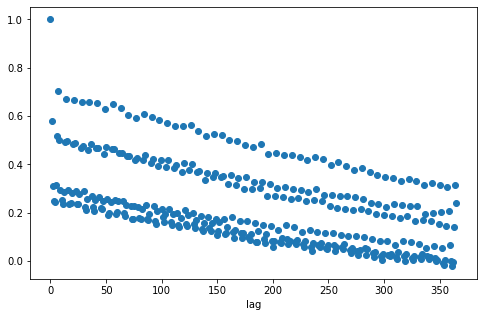

In [102]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

<Figure size 1080x1080 with 0 Axes>

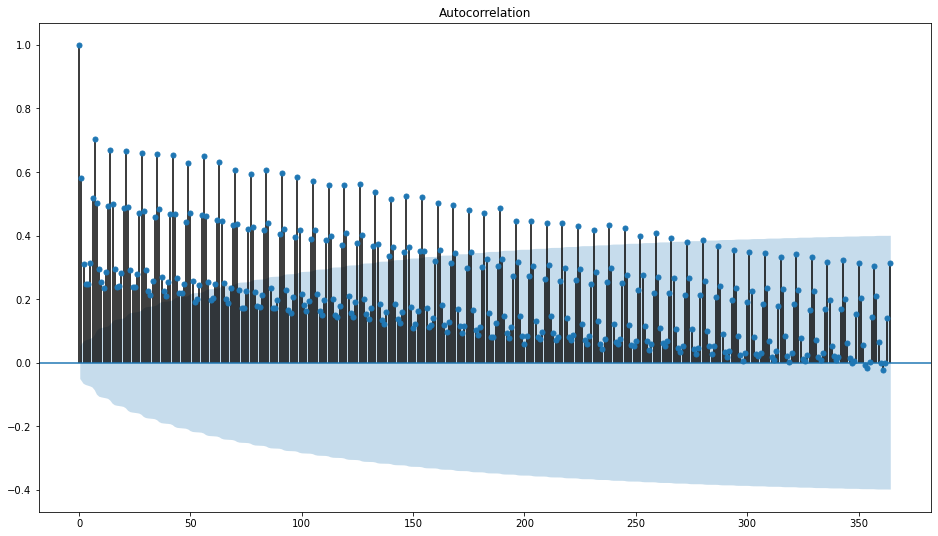

In [103]:
# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_d3, lags = np.arange(nlags))
plt.show()

La ejecución del ejemplo crea una gráfica 2D que muestra el valor de retraso a lo largo del eje xy la correlación en el eje y entre -1 y 1.

Los intervalos de confianza se dibujan como un cono. De forma predeterminada, se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este cono son muy probablemente una correlación y no una casualidad estadística.

##### Dos años

In [104]:
days = 365 # Cantidad de días en 1 año.
years = 2 # Cantidad de años observados.

nlags= days*years           
autocorr = stattools.acf(dataset_illia_ef_st_d3, nlags= nlags)
autocorr.shape

(731,)

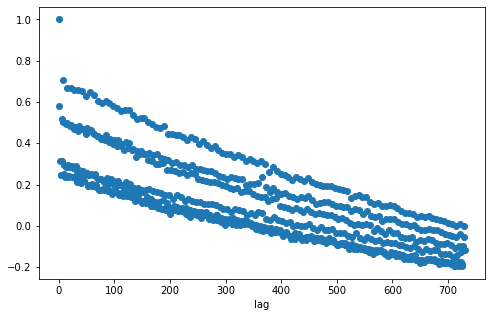

<Figure size 1080x1080 with 0 Axes>

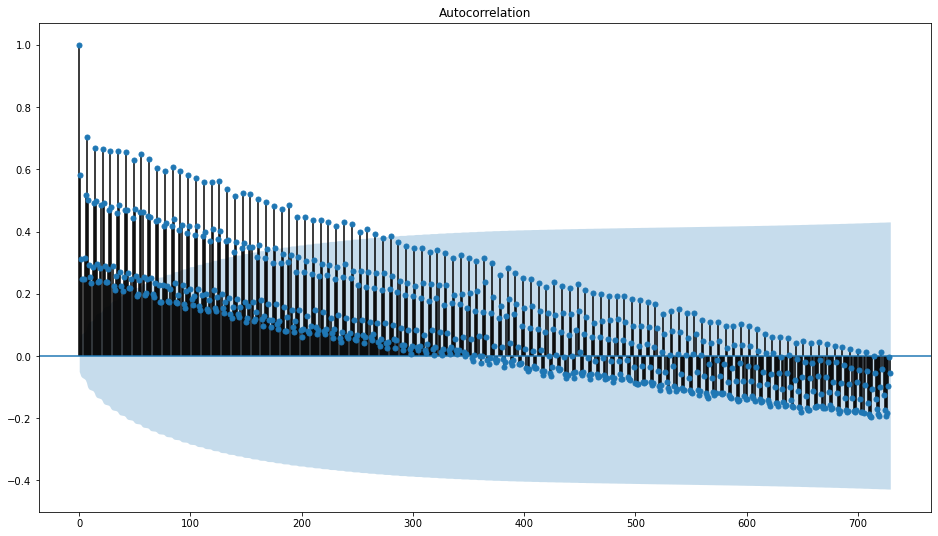

In [105]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_d3, lags = np.arange(nlags))
plt.show()

##### Tres años

In [106]:
days = 365 # Cantidad de días en 1 año.
years = 3 # Cantidad de años observados.

nlags= days*years           
autocorr = stattools.acf(dataset_illia_ef_st_d3, nlags= nlags)
autocorr.shape

(1096,)

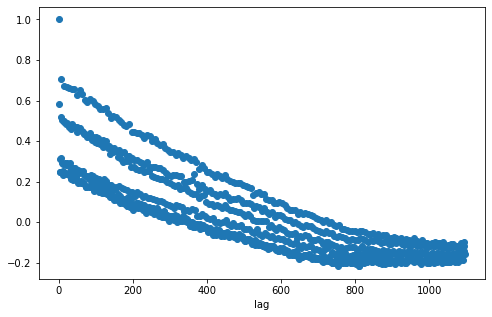

<Figure size 1080x1080 with 0 Axes>

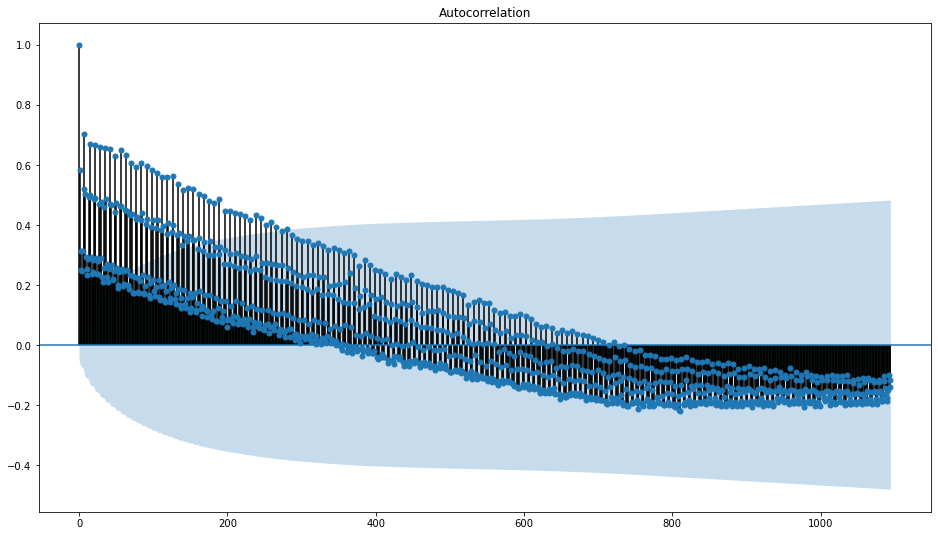

In [107]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_d3, lags = np.arange(nlags))
plt.show()

##### Cuatro años

In [108]:
days = 365 # Cantidad de días en 1 año.
years = 4 # Cantidad de años observados.

nlags= days*years           
autocorr = stattools.acf(dataset_illia_ef_st_d3, nlags= nlags)
autocorr.shape

(1461,)

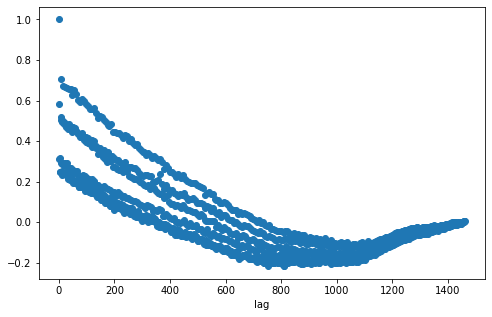

<Figure size 1080x1080 with 0 Axes>

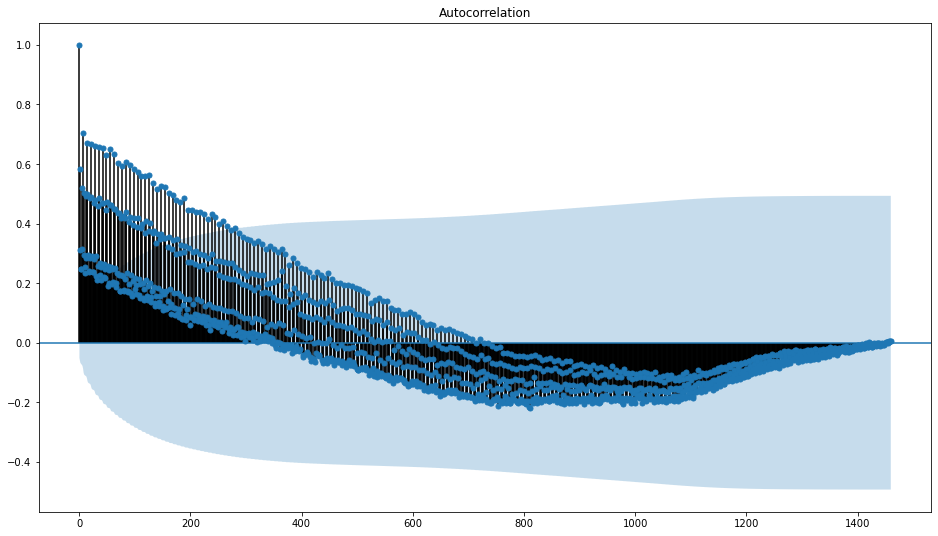

In [109]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_d3, lags = np.arange(nlags))
plt.show()

##### **Conclusión Autocorrelaciones**

Por el tipo de dataset con el que trabajamos, entiendo que es muy difícil poder apreciar y graficar la Autocorrelacion en una frecuencia diaria. 

Es muy notorio como los datos de interés (zona no sombreada) se reducen a una pequeña parte. 


#### Descomposición la Serie

La descomposición proporciona un modelo abstracto útil para **comprender** mejor los problemas durante el **análisis** y la **predicción** de series de tiempo.

Una **abstracción** útil para seleccionar métodos de pronóstico es dividir una serie de tiempo en **componentes**:
- **Sistemáticos**: Componentes de la serie temporal que tienen consistencia o recurrencia y pueden describirse y modelarse.
- **No sistemáticos**: componentes de la serie temporal que no se pueden modelar directamente.

Una serie de tiempo **consta de tres componentes sistemáticos** que incluyen **nivel, tendencia, estacionalidad y un** componente **no sistemático** llamado **ruido**.

Estos componentes se definen como:
- **Nivel**: el valor medio de la serie.
- **Tendencia**: el valor creciente o decreciente de la serie.
- **Estacionalidad**: el ciclo a corto plazo que se repite en la serie.
- **Ruido**: la variación aleatoria en la serie.


Es necesario pensar y abordar cada uno de estos componentes durante la preparación de datos, la selección del modelo y el ajuste del modelo. 

Se puede abordar explícitamente en términos de modelar la tendencia y restarla en los datos, o implícitamente proporcionando suficiente historial para que un algoritmo modele una tendencia, si es que existe.

Un **modelo aditivo** sugiere que los componentes se sumen de la siguiente manera:
	
`y(t) = Level + Trend + Seasonality + Noise`

Un modelo aditivo es lineal en el que los cambios a lo largo del tiempo se realizan constantemente en la misma cantidad.

Una tendencia lineal es una línea recta.

Una estacionalidad lineal tiene la misma frecuencia (ancho de ciclos) y amplitud (altura de ciclos).



Un **modelo multiplicativo** sugiere que los componentes se multipliquen de la siguiente manera:

`y(t) = Level * Trend * Seasonality * Noise`

Un modelo multiplicativo no es lineal, como cuadrático o exponencial. Los cambios aumentan o disminuyen con el tiempo.

Una tendencia no lineal es una línea curva.

Una estacionalidad no lineal tiene una frecuencia y / o amplitud creciente o decreciente a lo largo del tiempo.

Los problemas del mundo real son complicados y ruidosos. Puede haber componentes aditivos y multiplicativos. Puede haber una tendencia creciente seguida de una tendencia decreciente. Puede haber ciclos no repetidos mezclados con los componentes de estacionalidad repetidos.


Es por ello que quizá se pueda pueda o no, catalogar la serie de tiempo como un modelo aditivo o multiplicativo.

Veamos qué sucede con nuestra serie. Para ello, utilizaremos la función season_decompose (). El objeto resultante contiene las matrices para acceder a los cuatro datos de la descomposición.

In [110]:
decomp_diaria_add = tsa.seasonal.seasonal_decompose(
    dataset_illia_ef_st_d3.cantidad_pasos, model='additive', extrapolate_trend='freq'
)

decomp_diaria_mltp = tsa.seasonal.seasonal_decompose(
    dataset_illia_ef_st_d3.cantidad_pasos, model='multiplicative', extrapolate_trend='freq'
)

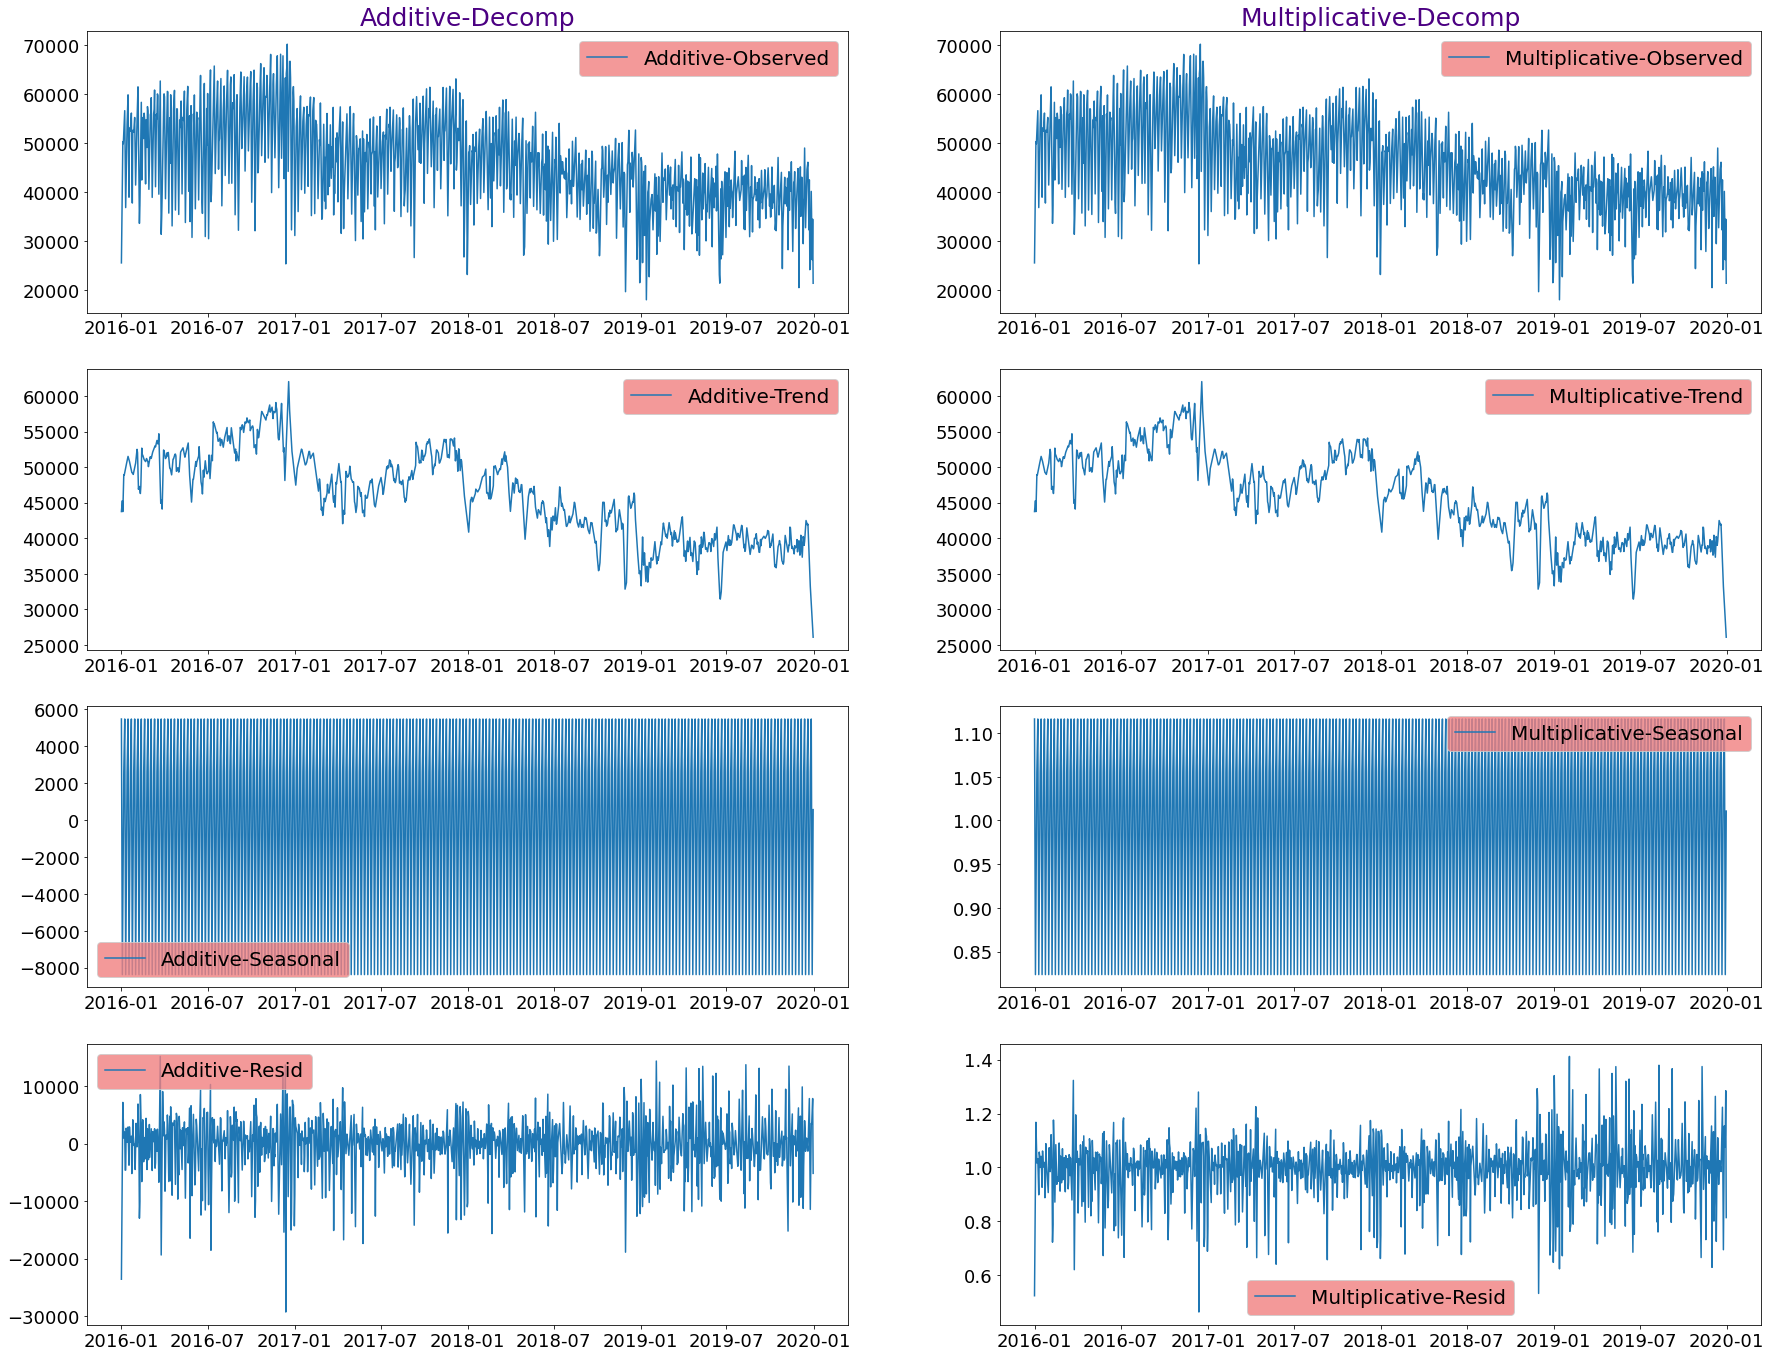

In [111]:
plt.figure(figsize=(30,30))

Gs= gs.GridSpec(5,2)
ax1= plt.subplot(Gs[0])
plt.title("Additive-Decomp", fontsize=25, color= "indigo")
plt.plot(decomp_diaria_add.observed, label= "Additive-Observed")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax2= plt.subplot(Gs[1])
plt.title("Multiplicative-Decomp", fontsize=25, color= "indigo")
plt.plot(decomp_diaria_mltp.observed, label= "Multiplicative-Observed")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax3= plt.subplot(Gs[2])
plt.plot(decomp_diaria_add.trend, label= "Additive-Trend")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax4= plt.subplot(Gs[3])
plt.plot(decomp_diaria_mltp.trend, label= "Multiplicative-Trend")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax5= plt.subplot(Gs[4])
plt.plot(decomp_diaria_add.seasonal, label= "Additive-Seasonal")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax6= plt.subplot(Gs[5])
plt.plot(decomp_diaria_mltp.seasonal, label= "Multiplicative-Seasonal")
plt.legend(fontsize=20, facecolor= 'lightcoral', loc= 1)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)


ax7= plt.subplot(Gs[6])
plt.plot(decomp_diaria_add.resid, label= "Additive-Resid")
plt.legend(fontsize=20, facecolor= 'lightcoral', loc= 2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax8= plt.subplot(Gs[7])
plt.plot(decomp_diaria_mltp.resid, label= "Multiplicative-Resid")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

plt.show()

Al descomponer la serie con ambos modelos, observados que los gráficos son similares. 

Con la diferencia que en el modelo 'Aditivo' los "resids" tienen un comportamiento completamente aleatorio y una media en 0. 

Este indicio indica que podríamos estar ante la presencia de "White Noise", al contrario de los "resids" devueltos con el modelo "Multiplicativo".

Podemos ver que la información de tendencia y estacionalidad extraída de la serie sí parece razonable. Los residuales también son interesantes, mostrando períodos de alta variabilidad en el primer semestre de 2016, a inicios de 2017 (el más notorio) y en el último año de la serie.

##### Modelo Aditivo

`Value = Level + Trend + Seasonality + Noise`

In [112]:
serie_aditiva_check = pd.concat(
    [
     decomp_diaria_add.seasonal, 
     decomp_diaria_add.trend, 
     decomp_diaria_add.resid, 
     decomp_diaria_add.observed
    ], axis=1)
serie_aditiva_check.columns = ['seasonal', 'trend', 'resid', 'actual_values']
serie_aditiva_check.head()

seasonal     trend     resid  actual_values
fecha                                                  
2016-01-01   5449.91  43746.11 -23594.02       25602.00
2016-01-02  -3573.01  44511.41  -4802.41       36136.00
2016-01-03  -8374.30  45276.71    322.58       37225.00
2016-01-04   -620.01  43741.14   7190.87       50312.00
2016-01-05    548.91  48175.86   1182.23       49907.00

Si los datos observados son correctos, la adición de 'seasonal' + 'trend' + 'resid' = 'actual_values'.

In [113]:
fecha_random = datetime.datetime.strftime(
    pd.to_datetime(
        np.random.choice(serie_aditiva_check.index)
        ),'%Y-%m-%d')

trend = float(serie_aditiva_check[serie_aditiva_check.index == fecha_random].trend.values)
seasonal = float(serie_aditiva_check[serie_aditiva_check.index == fecha_random].seasonal.values)
resid = float(serie_aditiva_check[serie_aditiva_check.index == fecha_random].resid.values)

actual_value = float(serie_aditiva_check[serie_aditiva_check.index == fecha_random].actual_values.values)

if round(trend + seasonal + resid) == actual_value :
    print("Es un modelo aditivo")
else:
    print("No es un modelo aditivo")

Es un modelo aditivo


##### Histograma de los Residuales

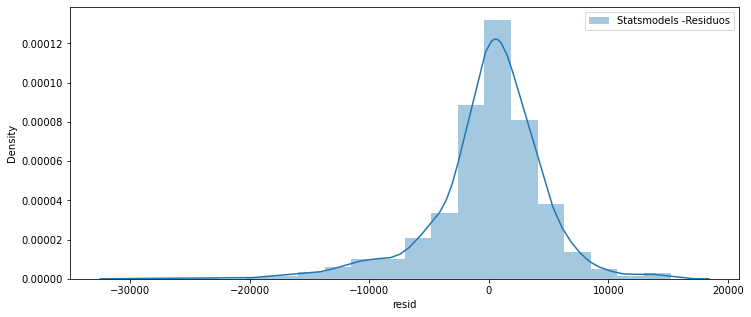

In [114]:
plt.rcParams['figure.figsize'] = [12,5]
sns.distplot(decomp_diaria_add.resid, bins=20, label="Statsmodels -Residuos")
plt.legend()
plt.show()

##### **Conclusión de la descomposición**

- En el primer gráfico se observa la serie en sí.

- El segundo gráfico devuelve la tendencia de la serie, la cual destacamos su negatividad.

- El tercer gráfico representa la estacionalidad. Es decir, que se pueden apreciar las fluctuaciones internas que suceden por dentro de la serie.

- El grafico "Resid", devuelve el ruido de la serie. Al observar que los residuales, se encuentran sin correlacion alguna y el promedio en general se encuentra fijo en 0, nos lleva a pensar que el rudio de nuestra serie es "White Noise" y estamos ante una serie apta para su modelado.

### Serie de tiempo - EDA - Frecuencia Semanal
Para poder observar los datos agrupados por semana, creamos una serie de tiempo, resampleada por esa unidad de tiempo.

#### Resampleo por sumatoria

In [115]:
#Resampleo nuestros datos para agrupar por semana

dataset_illia_ef_st_w = pd.DataFrame()
dataset_illia_ef_st_w = dataset_illia_ef.resample('W', on = 'fecha').sum()
display(Markdown('### DF con Valores Atípicos')) 
display(dataset_illia_ef_st_w)

print()

dataset_illia_ef_st_w3 = pd.DataFrame()
display(Markdown('### DF sin Valores Atípicos')) 
dataset_illia_ef_st_w3 = dataset_illia_ef_st_d3.resample("w").sum()
display(dataset_illia_ef_st_w)

### DF con Valores Atípicos

cantidad_pasos
fecha                     
2016-01-03           98963
2016-01-10          342201
2016-01-17          359649
2016-01-24          346217
2016-01-31          348221
...                    ...
2019-12-08          282891
2019-12-15          272960
2019-12-22          292881
2019-12-29          226390
2020-01-05           55970

[210 rows x 1 columns]

### DF sin Valores Atípicos

cantidad_pasos
fecha                     
2016-01-03           98963
2016-01-10          342201
2016-01-17          359649
2016-01-24          346217
2016-01-31          348221
...                    ...
2019-12-08          282891
2019-12-15          272960
2019-12-22          292881
2019-12-29          226390
2020-01-05           55970

[210 rows x 1 columns]

Como se puede observar, la semana inicial y final de la serie, no cuenta con los 7 días. Es por ello, que hay una baja sustancial en la cantidad de pases.

#### Resampleo por promedio

Con el objetivo de **equilibrar** la desproporción registrada en la **primer y última semana**, volvemos a resamplear los objetos creados pero ésta vez con el promedio. 

In [116]:
#Resampleo nuestros datos para agrupar por semana

dataset_illia_ef_st_w_mean = pd.DataFrame()
dataset_illia_ef_st_w_mean = dataset_illia_ef.resample("w" , on="fecha").mean()
display(Markdown('### DF con Valores Atípicos')) 
display(dataset_illia_ef_st_w_mean)


### DF con Valores Atípicos

cantidad_pasos
fecha                     
2016-01-03          139.19
2016-01-10          176.21
2016-01-17          186.83
2016-01-24          186.24
2016-01-31          187.82
...                    ...
2019-12-08          421.60
2019-12-15          408.01
2019-12-22          435.83
2019-12-29          345.11
2020-01-05          304.18

[210 rows x 1 columns]

Hemos logrado disminuir los saltos de la primer y última semana. 
Dado que siempre trabajamos con la sumatoria y no con el promedio, observemos la serie obtenida:

In [117]:
# Plot 
fig_efe_w_mean = px.line(dataset_illia_ef_st_w_mean, title='Vehículos por semana promedio con valores atípicos - AU Illia - Pago en efectivo')
fig_efe_w_mean.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_efe_w_mean.update_layout(
    width=1000,
    height=500,)
fig_efe_w_mean.show()

En el gráfico, se puede apreciar la importancia de trabajar los valores atípicos. Es notorio como los picos negativos influyen en el promedio.

Por lo tanto, trabajaremos con el resampleo de la serie pero esta vez, con el promedio de la sumatoria diara en la que ya corregimos los valores atípicos.

In [118]:
# Genero la serie con VA

dataset_illia_ef_st_w_mean = pd.DataFrame()
dataset_illia_ef_st_w_mean = dataset_illia_ef_st_d.resample("w").mean()
display(Markdown('### DF con Valores Atípicos')) 
display(dataset_illia_ef_st_w_mean)


# Genero la serie sin VA

dataset_illia_ef_st_w3_mean = pd.DataFrame()
dataset_illia_ef_st_w3_mean = dataset_illia_ef_st_d3.resample("w").mean()
display(Markdown('### DF sin Valores Atípicos')) 
display(dataset_illia_ef_st_w3_mean)


### DF con Valores Atípicos

cantidad_pasos
fecha                     
2016-01-03        32987.67
2016-01-10        48885.86
2016-01-17        51378.43
2016-01-24        49459.57
2016-01-31        49745.86
...                    ...
2019-12-08        40413.00
2019-12-15        38994.29
2019-12-22        41840.14
2019-12-29        32341.43
2020-01-05        27985.00

[210 rows x 1 columns]

### DF sin Valores Atípicos

cantidad_pasos
fecha                     
2016-01-03        32987.67
2016-01-10        48885.86
2016-01-17        51378.43
2016-01-24        49459.57
2016-01-31        49745.86
...                    ...
2019-12-08        40413.00
2019-12-15        38994.29
2019-12-22        41840.14
2019-12-29        32341.43
2020-01-05        27985.00

[210 rows x 1 columns]

In [119]:
# Plot 
fig_efe_w_va = px.line(title='Vehículos por semana (con y sin valores atípicos) - AU Illia - Pago en efectivo')
fig_efe_w_va.add_scatter(y=dataset_illia_ef_st_w3_mean['cantidad_pasos'], mode='lines', name="Original Mean")
fig_efe_w_va.add_scatter(y=dataset_illia_ef_st_w_mean['cantidad_pasos'], mode='lines', name="Con VA Mean")

fig_efe_w_va.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_efe_w_va.update_layout(
    width=1000,
    height=500,)
fig_efe_w_va.show()

In [120]:
display(Markdown('### Estadísticos - DF Mean sin Valores Atípicos')) 
display(dataset_illia_ef_st_w3_mean.describe())

### Estadísticos - DF Mean sin Valores Atípicos

cantidad_pasos
count          210.00
mean         45968.55
std           6151.03
min          27985.00
25%          40861.11
50%          46311.07
75%          50999.64
max          58119.57

#### Valores Faltantes

In [121]:
dataset_illia_ef_st_w_mean.index.to_series().diff().value_counts()

7 days    209
Name: fecha, dtype: int64

Diferencia de 7 días, por lo cual no hay Valores Faltantes.


#### Graficamos la serie por años

In [122]:
fig_efe_w_va.update_xaxes(range=['2016-01-01', '2016-12-31'])
fig_efe_w_va.show()

In [123]:
fig_efe_w_va.update_xaxes(range=['2017-01-01', '2017-12-31'])
fig_efe_w_va.show()

In [124]:
fig_efe_w_va.update_xaxes(range=['2018-01-01', '2018-12-31'])
fig_efe_w_va.show()

In [125]:
fig_efe_w_va.update_xaxes(range=['2019-01-01', '2019-12-31'])
fig_efe_w_va.show()

#### Semanas de mayor flujo vehicular

In [126]:
dataset_illia_ef_st_w3_mean.describe()

mean = dataset_illia_ef_st_w3_mean["cantidad_pasos"].mean()
std = dataset_illia_ef_st_w3_mean["cantidad_pasos"].std()

In [127]:
dataset_illia_ef_w3_hights = dataset_illia_ef_st_w3_mean[
  dataset_illia_ef_st_w_mean["cantidad_pasos"] >= (mean + std)
]

In [128]:
dataset_illia_ef_w3_hights.sort_values('cantidad_pasos', ascending=False).head(10)

cantidad_pasos
fecha                     
2016-11-27        58119.57
2016-11-20        57847.43
2016-11-13        57738.00
2016-11-06        57371.00
2016-10-30        57130.57
2016-09-25        56933.14
2016-10-23        56525.71
2016-12-25        56308.00
2016-07-17        56011.14
2016-09-11        55606.71

Las semanas de mayor flujo vehicular se registran en el 2016, el año que mayor afluencia hubo.

#### Último trimestre 2019

In [129]:
fig_efe_w_va.update_xaxes(range=['2019-10-01', '2019-12-31'])
fig_efe_w_va.show()

Se puede apreciar una pronunciada caida en el registro de vehiculos para fines del año 2019. Quizás al observar los datos del año 2020 se pueda descubrir que sucedió en esos meses.

#### Autocorrelación

##### Un año

In [130]:
weeks = 52 # Cantidad de semanas en 1 año.
years = 1 # Cantidad de años observados.

nlags= weeks*years           
autocorr = stattools.acf(dataset_illia_ef_st_w3_mean, nlags = nlags)
autocorr.shape

(53,)

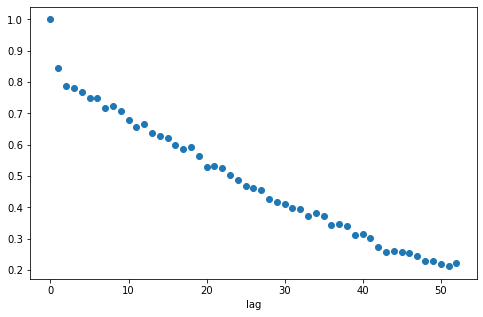

<Figure size 1080x1080 with 0 Axes>

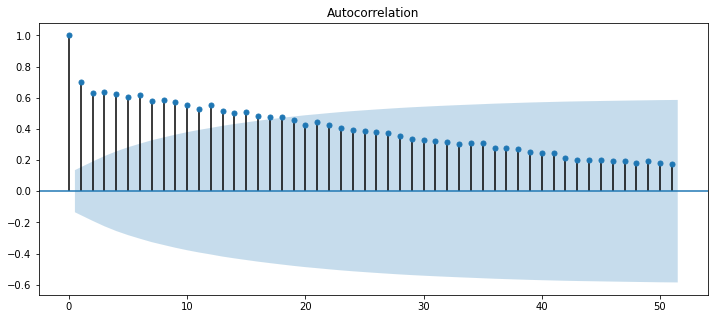

In [131]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_w3, lags = np.arange(nlags))
plt.show()

##### Dos años

In [132]:
weeks = 52 # Cantidad de semanas en 1 año.
years = 2 # Cantidad de años observados.

nlags= weeks*years           
autocorr = stattools.acf(dataset_illia_ef_st_w3_mean, nlags= nlags)
autocorr.shape

(105,)

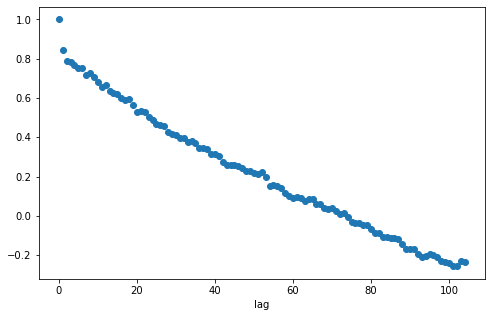

<Figure size 1080x1080 with 0 Axes>

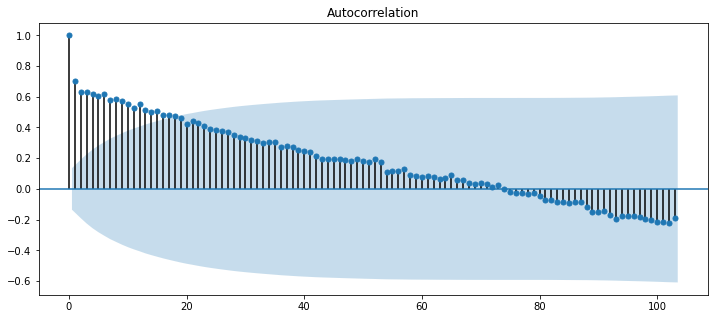

In [133]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_w3, lags = np.arange(nlags))
plt.show()

##### Tres años

In [134]:
weeks = 52 # Cantidad de semanas en 1 año.
years = 3 # Cantidad de años observados.

nlags= weeks*years           
autocorr = stattools.acf(dataset_illia_ef_st_w3_mean, nlags= nlags)
autocorr.shape

(157,)

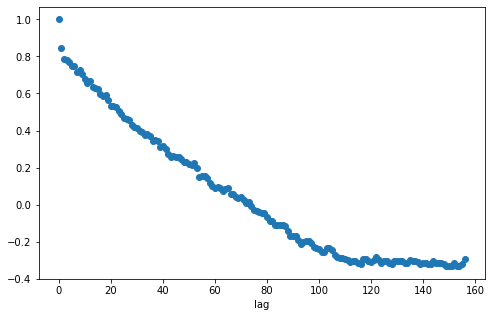

<Figure size 1080x1080 with 0 Axes>

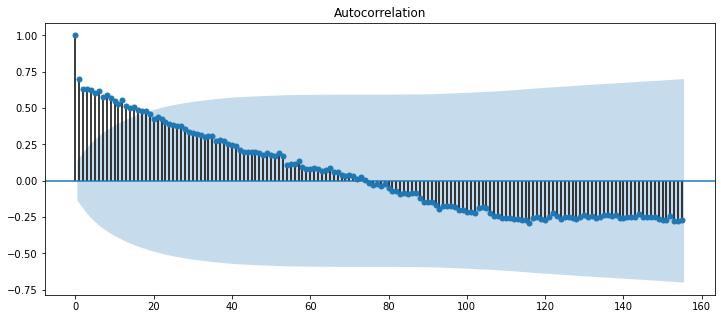

In [135]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_w3, lags = np.arange(nlags))
plt.show()

##### Cuatro años

In [136]:
weeks = 52 # Cantidad de semanas en 1 año.
years = 4 # Cantidad de años observados.

nlags= weeks*years           
autocorr = stattools.acf(dataset_illia_ef_st_w3_mean, nlags= nlags)
autocorr.shape

(209,)

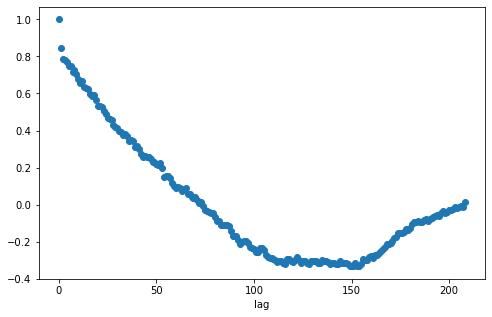

<Figure size 1080x1080 with 0 Axes>

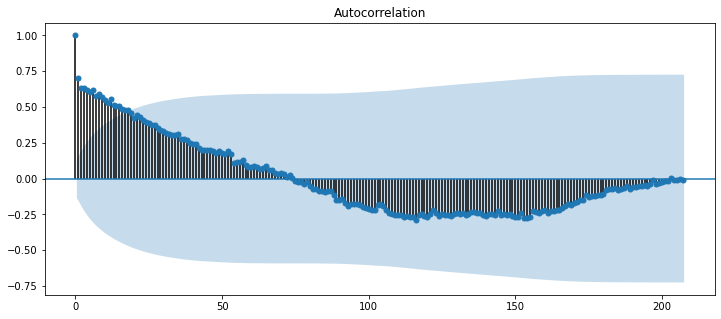

In [137]:
# Plot Autorcorrelación
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_w3, lags = np.arange(nlags))
plt.show()

##### **Conclusión Autocorrelaciones**


La observacion de los intervalos de confianza en los datos no cambia significativamente cuando los observamos en una frecuncia semanal.

#### Descomposición la Serie

##### Modelo aditivo

In [138]:
decomp_semanal_add = tsa.seasonal.seasonal_decompose(
    dataset_illia_ef_st_w3_mean.cantidad_pasos, model='additive', extrapolate_trend='freq'
)

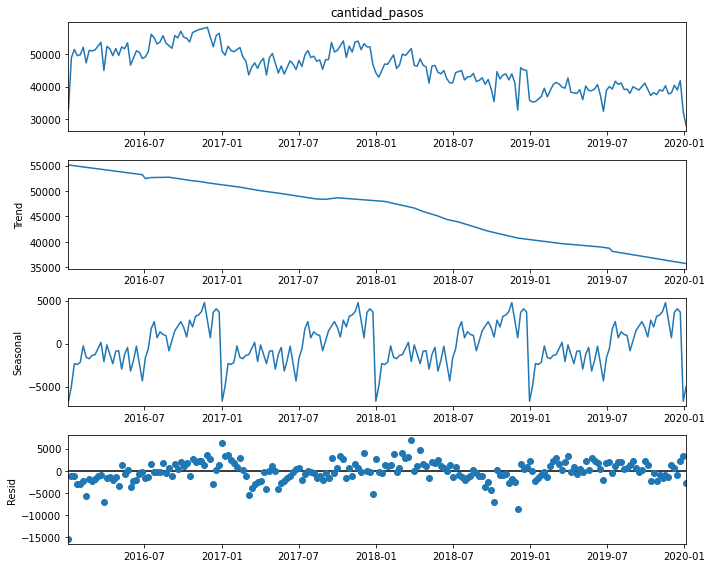

In [139]:
plt.rcParams['figure.figsize'] = [10,8]
decomp_semanal_add.plot()
plt.show()

##### **Conclusión de la descomposición**

- Trend devuelve la tendencia semanal, la cual expone mejor aún la tendencia negativa de la serie.

- Seasonal muestra las fluctuaciones internas de la serie. En esta frecuencia se puede apreciar mejor la estacionalidad. Está bien marcada, los picos (tanto negativos como positivos) se presentan en los mismos períodos de tiempo a lo largo de los 4 años.

- Resid refiere al ruido de la serie. Se sigue apreciando un comportamiento completamenta aletarorio en los datos.

##### Histograma de los Residuales

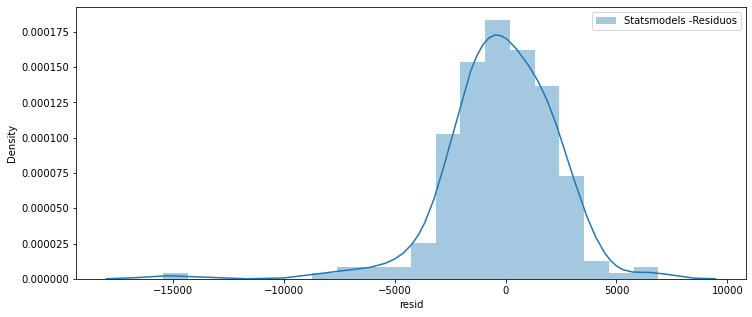

In [140]:
plt.rcParams['figure.figsize'] = [12,5]
sns.distplot(decomp_semanal_add.resid, bins=20, label="Statsmodels -Residuos")
plt.legend()
plt.show()

#### **Conclusión de resampleo Frecuencia Semanal**

Como era de esperarse, dado que el año 2016 fue el que más vehículos registró, al buscar las semanas con mayor flujo vehicular obtenemos que las 10 más concurridas, son del año 2016.

Por otro lado, la descomosición de la serie mostró gráficos clarificadores.

Podríamos decir que la frecuencia semanal es la más atinada para el modelado y predicción del último trimestre del 2019 y el año 2020.

### Serie de tiempo - EDA - Frecuencia Mensual
Para poder observar los datos agrupados por mes, creamos una serie de tiempo, resampleada por esa unidad de tiempo.

#### Resampleo por sumatoria

In [141]:
#Resampleo nuestros datos para agrupar por mes

dataset_illia_ef_st_m = dataset_illia_ef_st_d.resample("M").sum()
display(Markdown('### DF con Valores Atípicos')) 
display(dataset_illia_ef_st_m.tail())
print()

display(Markdown('### DF sin Valores Atípicos')) 
dataset_illia_ef_st_m3 = dataset_illia_ef_st_d3.resample("M").sum()
display(dataset_illia_ef_st_m3.tail())


### DF con Valores Atípicos

cantidad_pasos
fecha                     
2019-08-31         1223990
2019-09-30         1194001
2019-10-31         1177647
2019-11-30         1184560
2019-12-31         1151645

### DF sin Valores Atípicos

cantidad_pasos
fecha                     
2019-08-31      1223990.00
2019-09-30      1194001.00
2019-10-31      1177647.00
2019-11-30      1184560.00
2019-12-31      1151645.00

In [142]:
display(Markdown('### Estadísticos - DF con Valores Atípicos')) 
display(dataset_illia_ef_st_m.describe())

print()

display(Markdown('### Estadísticos - DF sin Valores Atípicos')) 
display(dataset_illia_ef_st_m3.describe())

### Estadísticos - DF con Valores Atípicos

cantidad_pasos
count           48.00
mean       1397645.92
std         180015.41
min        1103086.00
25%        1239572.00
50%        1400840.00
75%        1526092.50
max        1710827.00

### Estadísticos - DF sin Valores Atípicos

cantidad_pasos
count           48.00
mean       1402122.92
std         176751.25
min        1103086.00
25%        1246526.25
50%        1407800.00
75%        1526092.50
max        1710827.00

#### Graficamos la serie

In [143]:
# Plot 
fig_efe_m_va = px.line(title='Vehículos por mes (con y sin valores atípicos) - AU Illia - Pago en efectivo')

fig_efe_m_va.add_scatter(y=dataset_illia_ef_st_m['cantidad_pasos'], mode='lines+markers', name="Original")
fig_efe_m_va.add_scatter(y=dataset_illia_ef_st_m3['cantidad_pasos'], mode='lines+markers', name="Sin VA")

fig_efe_m_va.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_efe_m_va.update_layout(
    width=1000,
    height=500,)
fig_efe_m_va.show()

Resampleando a frecuencia mensual, se presenta más pronunciadamente la tendencia negativa en la serie. 

En enero de 2017, comienza una caida estrepitosa. Repuntando paulatinamente hasta finales de octubre de 2017 generando un nuevo pico positivo. 

Se produce nuevamente una caida en los meses posteriores hasta fines de febrero de 2018.

En marzo de 2018 hay un nuevo pico positivo, pero la tendencia comienza a ser negativa de forma estable.

#### Valores Faltantes

Esperados:
* Mes con 28 días = Febrero. (3 en total)
* Mes con 29 días = Febrero. (1 en total - año bisiesto)
* Meses con 30 días = Abril, Junio, Septiembre y Noviembre. (4 meses por 4 años)
* Meses con 31 días = Enero, Marzo, Mayo, Julio, Agosto, Octubre y Diciembre. (7 meses por 4 años)

In [144]:
dataset_illia_ef_st_m3.index.to_series().diff().value_counts()

31 days    27
30 days    16
28 days     3
29 days     1
Name: fecha, dtype: int64



Observados:
* Mes con 29 días, 1 vez  (1 año bisiesto).
* Mes con 28 días, 3 veces.
* Meses con 30 días, 4 veces.
* Meses con 31 días, 27 veces.

Por algún motivo en el resampleo a frecuencia mensual, cuando cuenta la cantidad de instancias que se encuentran en el resampleo, en los meses que tienen 31 días nos devuelve 1 mes entero menos. 

El numero debería de ser 28 ya que son 7 meses en el año que tienen 31 días. En otras palabras, 7(meses) x 4(años) = 28 (cantidad de meses observados). 

Se puede intuir que este compartamiento se debe a lo explicado con el primer chequeo de valores faltantes en la Serie Diaria donde aclarábamos que como no tiene una fecha anterior para comparar la primer fecha registrada, nos devuelve 1 instacia menos de la que tiene el dataframe. 

#### Último trimestre 2019

In [145]:
fig_efe_m_va.update_yaxes(range=[0, 1900000])
fig_efe_m_va.update_xaxes(range=['2019-10-01', '2019-12-31'])
fig_efe_m_va.show()

#### Autocorrelación

##### Un año

In [146]:
months = 12 # Cantidad de semanas en 1 año.
years = 1 # Cantidad de años observados.

nlags= months*years           
autocorr = stattools.acf(dataset_illia_ef_st_m3, nlags= nlags)
autocorr.shape

(13,)

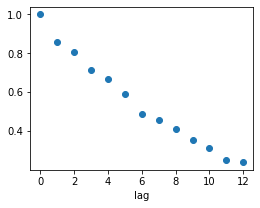

<Figure size 1080x1080 with 0 Axes>

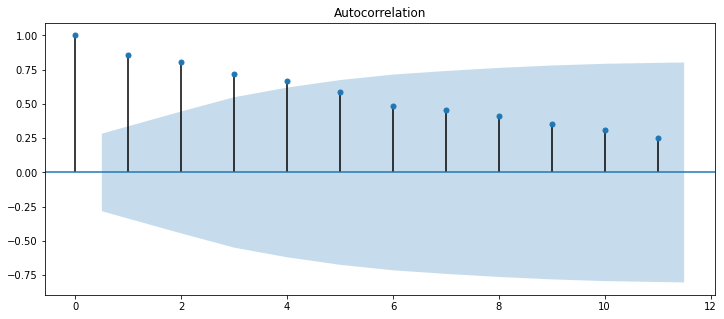

In [147]:
# Plot Autorcorrelación
plt.figure(figsize = (4,3))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_m3, lags = np.arange(nlags))
plt.show()

##### Dos años

In [148]:
months = 12 # Cantidad de semanas en 1 año.
years = 2 # Cantidad de años observados.

nlags= months*years           
autocorr = stattools.acf(dataset_illia_ef_st_m3, nlags= nlags)
autocorr.shape

(25,)

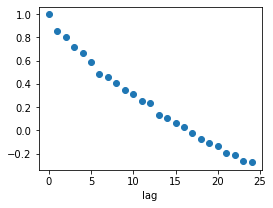

<Figure size 1080x1080 with 0 Axes>

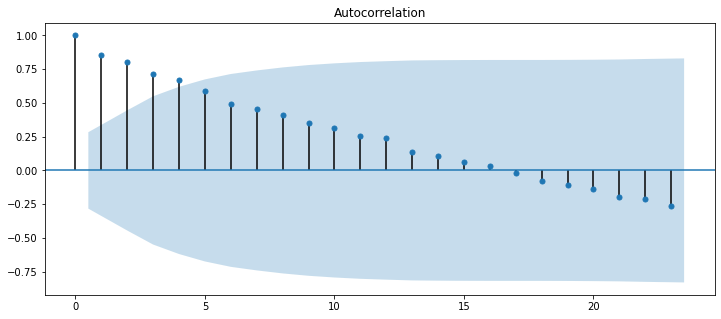

In [149]:
# Plot Autorcorrelación
plt.figure(figsize = (4,3))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_m3, lags = np.arange(nlags))
plt.show()

##### Tres años

In [150]:
months = 12 # Cantidad de semanas en 1 año.
years = 3 # Cantidad de años observados.

nlags= months*years           
autocorr = stattools.acf(dataset_illia_ef_st_m3, nlags= nlags)
autocorr.shape

(37,)

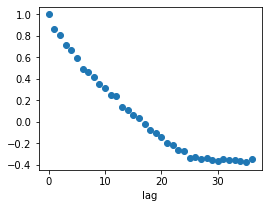

<Figure size 1080x1080 with 0 Axes>

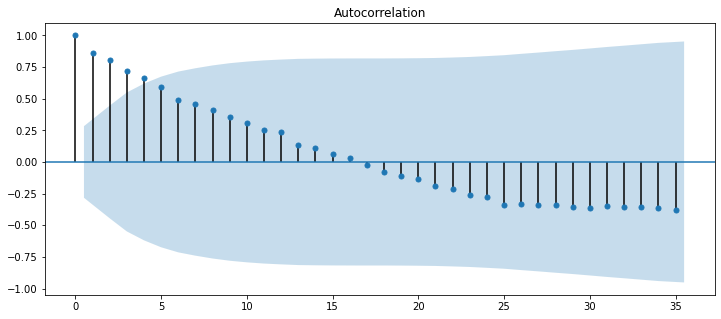

In [151]:
# Plot Autorcorrelación
plt.figure(figsize = (4,3))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

# Plot Autorcorrelación
plt.figure(figsize = (15,15))
plot_acf(dataset_illia_ef_st_m3, lags = np.arange(nlags))
plt.show()

##### **Conclusión Autocorrelaciones**


La frecuencia mensual se vuelve mucho más fácil de entender a través de su gráfico. Más que nada al momento de buscar los intervalos de confianza. 

Con la serie mensual puede detectar con mayor claridad dónde están los datos que conservan interés para la predicción.

#### Descomposición la Serie

In [152]:
decomp_mensual_add = tsa.seasonal.seasonal_decompose(
    dataset_illia_ef_st_m3.cantidad_pasos, model='additive', extrapolate_trend='freq'
)

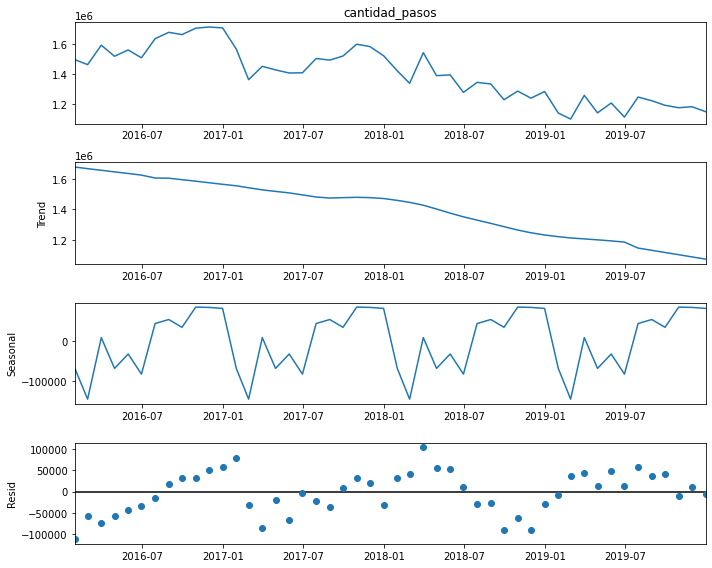

In [153]:
plt.rcParams['figure.figsize'] = [10,8]
decomp_mensual_add.plot()
plt.show()

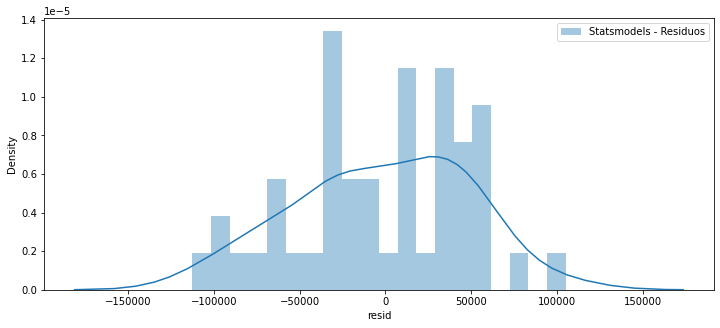

In [154]:
# Histograma de los Residuales
plt.rcParams['figure.figsize'] = [12,5]
sns.distplot(decomp_mensual_add.resid, bins=20, label="Statsmodels - Residuos")
plt.legend()
plt.show()

#### **Conclusión de resampleo Frecuencia Mensual**

Resamplear la serie a una frecuencia mensual resulta informativo para entender la tendencia de la serie y la autocorrelación. 

Sin embargo para su estudio (cantidad de vehículos que transitan la Au.Illia con pago en efectivo) se vuelve acotada. 
En frecuncia semanal ya no es posible estudiar, por ejemplo, los días de mayor afluencia o sus horarios. Menos en una frecuencia mensual. 

Frecuencia mensual es útil para poder estudiar comportamientos a grandes rasgos.

Para predecir el último trimestre de 2019 y el año de 2020, la frecuencia semanal la concidero más oportuna.

### Conclusión EDA

La serie no cuenta con **valores faltantes**, hemos detectado **valores atípicos**, y los mismos fueron tratados. La serie es apta para su modelado dado que es una serie **estacionaria** y los resids se consideran **white noise**.

Por otro lado, nos encontramos con un dataset con **tendencia** claramente **negativa**. Esto nos lleva a buscar explicaciones por fuera del dataset.

Realizando una investigación, encontramos notas periodísticas que apuntan al **aumento del combustible y de las tarifas de los peajes** como principal causa en la reducción del uso del automovil. Generando un incremento en el uso de trenes, colectivos y subtes.


En conclusión, los registros en la autopista Illia se ven directamente **afectados por**: 

- Los **aumentos** de tarifas de combustible y peajes. 
- **Medidas** del gobierno para promover el uso de menos autos para ir a la ciudad.
- Inauguración del **Paseo del Bajo** el cual condiciona a los vehículos pesados a transitar por otras vías.
- Incorporación de **Telepase**.

Como mejoras de **implementación a futuro**, se podría agregar al dataset:

- La variable "precio de **combustible**". Para observar que a medida que el precio del combustible asciende el flujo de vehículos desciende. 
- La variable "tarifa de **peaje**". Para observar que a medida que aumenta, produce un descenso de vehículos en la autopista.

Por último, se define utilizar una **frecuencia semanal** para la predición de datos. Dado que es la frecuencia que pierde menos información sin sobre exigir a los modelos.

## Predicciones a futuro

Dado que nuestros objetivos son predecir el último trimestre de 2019 y el año 2020, procederemos a generar un dataset con los datos reales que contamos focalizandonos sólo en estos dos últimos años.

De esta manera, podremos verificar la eficacia de los resultados predichos.

### Dataset de verificación

#### Datos 2019

Para el año 2019 ya contamos con la información necesaria:

In [155]:
df_2019_ef = data_2019.copy()
mask = np.logical_and(df_2019_ef.estacion=='Illia', (df_2019_ef.forma_pago == 'EFECTIVO'))
df_2019_ef = df_2019_ef[mask]
df_2019_ef.drop(columns = ['hora_inicio','estacion'], inplace = True)
df_2019_ef

periodo       fecha  hora_fin     dia    sentido tipo_vehiculo  \
80         2019  2019-01-01         2  Martes     Centro       Liviano   
86         2019  2019-01-01         2  Martes     Centro        Pesado   
88         2019  2019-01-01         2  Martes  Provincia       Liviano   
94         2019  2019-01-01         2  Martes  Provincia        Pesado   
149        2019  2019-01-01         3  Martes     Centro       Liviano   
...         ...         ...       ...     ...        ...           ...   
812010     2019  2019-12-31        22  Martes  Provincia       Liviano   
812016     2019  2019-12-31        22  Martes  Provincia        Pesado   
812080     2019  2019-12-31        23  Martes     Centro       Liviano   
812085     2019  2019-12-31        23  Martes  Provincia       Liviano   
812131     2019  2019-12-31         0  Martes     Centro       Liviano   

       forma_pago  cantidad_pasos  
80       EFECTIVO             537  
86       EFECTIVO               1  
88       EFECTIVO             443  
94       EFECTIVO               1  
149      EFECTIVO             769  
...           ...             ...  
812010   EFECTIVO             556  
812016   EFECTIVO               1  
812080   EFECTIVO             214  
812085   EFECTIVO             190  
812131   EFECTIVO               4  

[34643 rows x 8 columns]

#### Datos 2020

Para el caso del 2020, si bien poseemos un dataset, este contiene sólo los datos hasta marzo (al 18 de enero del 2020).

In [156]:
data_2020

periodo       fecha    mes        dia  dia_fecha  hora_inicio  \
0          2020  2020-01-01  enero  Miércoles          1            0   
1          2020  2020-01-01  enero  Miércoles          1            0   
2          2020  2020-01-01  enero  Miércoles          1            0   
3          2020  2020-01-01  enero  Miércoles          1            0   
4          2020  2020-01-01  enero  Miércoles          1            0   
...         ...         ...    ...        ...        ...          ...   
678730     2020  2020-03-31  marzo     Martes         31           23   
678731     2020  2020-03-31  marzo     Martes         31           23   
678732     2020  2020-03-31  marzo     Martes         31           23   
678733     2020  2020-03-31  marzo     Martes         31           23   
678734     2020  2020-03-31  marzo     Martes         31           23   

        hora_fin estacion   tipo_vehiculo forma_pago  \
0              1  ALBERDI            Auto   Efectivo   
1              1  ALBERDI            Auto   Efectivo   
2              1  ALBERDI            Auto  Rec.Deuda   
3              1  ALBERDI            Auto  Rec.Deuda   
4              1  ALBERDI            Auto  Rec.Deuda   
...          ...      ...             ...        ...   
678730         0      ILP  Pesados 6 Ejes  Violación   
678731         0      PB1  Pesados 6 Ejes        Tag   
678732         0      PB1  Pesados 6 Ejes  Violación   
678733         0      PB4  Pesados 6 Ejes        Tag   
678734         0      PB4  Pesados 6 Ejes  Violación   

                             observacion    sentido  cantidad_pasos  
0                               Efectivo     Centro              24  
1                               Efectivo  Provincia              80  
2                     Paso en Infracción  Provincia               1  
3       Paso en infracción con Multa LPR     Centro               1  
4       Paso en infracción con Multa LPR  Provincia               1  
...                                  ...        ...             ...  
678730                Violación - Normal  Provincia               1  
678731                     Tag - PosPago  Provincia              14  
678732                Violación - Normal  Provincia               2  
678733                     Tag - PosPago     Centro               6  
678734                Violación - Normal     Centro               1  

[678735 rows x 13 columns]

Indagando en el sitio oficial de https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa han publicado recientemente los datos.

Es por ello que procederemos a leerlos y generar un dataset de todo el año.

In [157]:
# Para cambiar la modalidad de carga de los datasets a CDN, descomentar la segunda línea.

cdn_mode = False
#cdn_mode = True

if cdn_mode:
  data_2020_Q1 = pd.read_excel('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ausa/flujo-vehicular-por-unidades-peaje-ausa/flujo-vehicular-2020%20ene-abr.xlsx')
  data_2020_Q2 = pd.read_excel('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ausa/flujo-vehicular-por-unidades-peaje-ausa/flujo-vehicular-2020-2.xlsx')
  data_2020_Q3 = pd.read_excel('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ausa/flujo-vehicular-por-unidades-peaje-ausa/flujo-vehicular-20203.xlsx')
else:
  data_2020_Q1 = pd.read_excel('./datasets/flujo-vehicular-2020-q1.xlsx')
  data_2020_Q2 = pd.read_excel('./datasets/flujo-vehicular-2020-q2.xlsx')
  data_2020_Q3 = pd.read_excel('./datasets/flujo-vehicular-2020-q3.xlsx')

In [158]:
data_2020_Q1

Unnamed: 0  periodo                fecha    mes        dia  dia_fecha  \
0                0     2020  2020-01-01 00:00:00  enero  Miércoles          1   
1                1     2020  2020-01-01 00:00:00  enero  Miércoles          1   
2                2     2020  2020-01-01 00:00:00  enero  Miércoles          1   
3                3     2020  2020-01-01 00:00:00  enero  Miércoles          1   
4                4     2020  2020-01-01 00:00:00  enero  Miércoles          1   
...            ...      ...                  ...    ...        ...        ...   
821921      821921     2020           2020-04-30  abril     Jueves         30   
821922      821922     2020           2020-04-30  abril     Jueves         30   
821923      821923     2020           2020-04-30  abril     Jueves         30   
821924      821924     2020           2020-04-30  abril     Jueves         30   
821925      821925     2020           2020-04-30  abril     Jueves         30   

        hora_inicio  hora_fin estacion   tipo_vehiculo forma_pago  \
0                 0         1  ALBERDI            Auto   Efectivo   
1                 0         1  ALBERDI            Auto   Efectivo   
2                 0         1  ALBERDI            Auto  Rec.Deuda   
3                 0         1  ALBERDI            Auto  Rec.Deuda   
4                 0         1  ALBERDI            Auto  Rec.Deuda   
...             ...       ...      ...             ...        ...   
821921           23         0      PB2  Pesados 6 Ejes        Tag   
821922           23         0      PB2  Pesados 6 Ejes        Tag   
821923           23         0      PB4  Pesados 6 Ejes        Tag   
821924           23         0      PB4  Pesados 6 Ejes  Violación   
821925           23         0   RETIRO  Pesados 6 Ejes        Tag   

                             observacion    sentido  cantidad_pasos  
0                               Efectivo     Centro              24  
1                               Efectivo  Provincia              80  
2                     Paso en Infracción  Provincia               1  
3       Paso en infracción con Multa LPR     Centro               1  
4       Paso en infracción con Multa LPR  Provincia               1  
...                                  ...        ...             ...  
821921                     Tag - PosPago     Centro               2  
821922                 Tag - PosPago OCR     Centro               1  
821923                     Tag - PosPago     Centro              12  
821924                Violación - Normal     Centro               1  
821925                     Tag - PosPago  Provincia               2  

[821926 rows x 14 columns]

In [159]:
data_2020_Q2

Unnamed: 0  periodo                fecha     mes      dia  dia_fecha  \
0        821926.00     2020           2020-05-01    mayo  Viernes          1   
1        821927.00     2020           2020-05-01    mayo  Viernes          1   
2        821928.00     2020           2020-05-01    mayo  Viernes          1   
3        821929.00     2020           2020-05-01    mayo  Viernes          1   
4        821930.00     2020           2020-05-01    mayo  Viernes          1   
...            ...      ...                  ...     ...      ...        ...   
806150         NaN     2020  2020-08-31 00:00:00  agosto    Lunes         31   
806151         NaN     2020  2020-08-31 00:00:00  agosto    Lunes         31   
806152         NaN     2020  2020-08-31 00:00:00  agosto    Lunes         31   
806153         NaN     2020  2020-08-31 00:00:00  agosto    Lunes         31   
806154         NaN     2020  2020-08-31 00:00:00  agosto    Lunes         31   

        hora_inicio  hora_fin    estacion   tipo_vehiculo forma_pago  \
0                 0         1     ALBERDI            Auto        Tag   
1                 0         1     ALBERDI            Auto        Tag   
2                 0         1  AVELLANEDA            Auto        Tag   
3                 0         1  AVELLANEDA            Auto        Tag   
4                 0         1  AVELLANEDA            Auto        Tag   
...             ...       ...         ...             ...        ...   
806150           23         0         PB1  Pesados 6 Ejes        Tag   
806151           23         0         PB1  Pesados 6 Ejes  Violación   
806152           23         0         PB4  Pesados 6 Ejes        Tag   
806153           23         0         PB4  Pesados 6 Ejes        Tag   
806154           23         0         PB4  Pesados 6 Ejes  Violación   

               observacion    sentido  cantidad_pasos  
0            Tag - PosPago  Provincia               5  
1        Tag - PosPago OCR  Provincia               2  
2            Tag - PosPago     Centro              30  
3            Tag - PosPago  Provincia              25  
4        Tag - PosPago OCR     Centro               3  
...                    ...        ...             ...  
806150       Tag - PosPago  Provincia              17  
806151  Violación - Normal  Provincia               2  
806152       Tag - PosPago     Centro              24  
806153   Tag - PosPago OCR     Centro               1  
806154  Violación - Normal     Centro               1  

[806155 rows x 14 columns]

In [160]:
data_2020_Q3

periodo      fecha         mes     dia  dia_fecha  hora_inicio  \
0          2020 2020-09-01  septiembre  Martes          1            0   
1          2020 2020-09-01  septiembre  Martes          1            0   
2          2020 2020-09-01  septiembre  Martes          1            0   
3          2020 2020-09-01  septiembre  Martes          1            0   
4          2020 2020-09-01  septiembre  Martes          1            0   
...         ...        ...         ...     ...        ...          ...   
905657     2020 2020-12-31   diciembre  Jueves         31           21   
905658     2020 2020-12-31   diciembre  Jueves         31           21   
905659     2020 2020-12-31   diciembre  Jueves         31           21   
905660     2020 2020-12-31   diciembre  Jueves         31           22   
905661     2020 2020-12-31   diciembre  Jueves         31           23   

        hora_fin                          estacion   tipo_vehiculo forma_pago  \
0              1                           ALBERDI            Auto   Efectivo   
1              1                           ALBERDI            Auto     Exento   
2              1                           ALBERDI            Auto     Exento   
3              1                           ALBERDI            Auto        Tag   
4              1                           ALBERDI            Auto        Tag   
...          ...                               ...             ...        ...   
905657        22  DELLEPIANE LINIERSLEPIANE CENTRO  Pesados 6 Ejes        Tag   
905658        22                DELLEPIANE LINIERS  Pesados 6 Ejes        Tag   
905659        22                               ILP  Pesados 6 Ejes        Tag   
905660        23                               ILP  Pesados 6 Ejes        Tag   
905661         0                DELLEPIANE LINIERS  Pesados 6 Ejes        Tag   

                   observacion    sentido  cantidad_pasos  
0                     Efectivo  Provincia           10.00  
1       Exento - Otros motivos  Provincia            2.00  
2          Exento - Reglamento  Provincia            3.00  
3                Tag - PosPago     Centro            2.00  
4                Tag - PosPago  Provincia            8.00  
...                        ...        ...             ...  
905657       Tag - PosPago OCR     Centro            1.00  
905658           Tag - PosPago  Provincia            1.00  
905659           Tag - PosPago     Centro            1.00  
905660           Tag - PosPago     Centro            2.00  
905661       Tag - PosPago OCR  Provincia            1.00  

[905662 rows x 13 columns]

In [161]:
data_2020_full = pd.concat([data_2020_Q1, data_2020_Q2,data_2020_Q3])
data_2020_full

Unnamed: 0  periodo                fecha        mes        dia  \
0             0.00     2020  2020-01-01 00:00:00      enero  Miércoles   
1             1.00     2020  2020-01-01 00:00:00      enero  Miércoles   
2             2.00     2020  2020-01-01 00:00:00      enero  Miércoles   
3             3.00     2020  2020-01-01 00:00:00      enero  Miércoles   
4             4.00     2020  2020-01-01 00:00:00      enero  Miércoles   
...            ...      ...                  ...        ...        ...   
905657         NaN     2020  2020-12-31 00:00:00  diciembre     Jueves   
905658         NaN     2020  2020-12-31 00:00:00  diciembre     Jueves   
905659         NaN     2020  2020-12-31 00:00:00  diciembre     Jueves   
905660         NaN     2020  2020-12-31 00:00:00  diciembre     Jueves   
905661         NaN     2020  2020-12-31 00:00:00  diciembre     Jueves   

        dia_fecha  hora_inicio  hora_fin                          estacion  \
0               1            0         1                           ALBERDI   
1               1            0         1                           ALBERDI   
2               1            0         1                           ALBERDI   
3               1            0         1                           ALBERDI   
4               1            0         1                           ALBERDI   
...           ...          ...       ...                               ...   
905657         31           21        22  DELLEPIANE LINIERSLEPIANE CENTRO   
905658         31           21        22                DELLEPIANE LINIERS   
905659         31           21        22                               ILP   
905660         31           22        23                               ILP   
905661         31           23         0                DELLEPIANE LINIERS   

         tipo_vehiculo forma_pago                       observacion  \
0                 Auto   Efectivo                          Efectivo   
1                 Auto   Efectivo                          Efectivo   
2                 Auto  Rec.Deuda                Paso en Infracción   
3                 Auto  Rec.Deuda  Paso en infracción con Multa LPR   
4                 Auto  Rec.Deuda  Paso en infracción con Multa LPR   
...                ...        ...                               ...   
905657  Pesados 6 Ejes        Tag                 Tag - PosPago OCR   
905658  Pesados 6 Ejes        Tag                     Tag - PosPago   
905659  Pesados 6 Ejes        Tag                     Tag - PosPago   
905660  Pesados 6 Ejes        Tag                     Tag - PosPago   
905661  Pesados 6 Ejes        Tag                 Tag - PosPago OCR   

          sentido  cantidad_pasos  
0          Centro           24.00  
1       Provincia           80.00  
2       Provincia            1.00  
3          Centro            1.00  
4       Provincia            1.00  
...           ...             ...  
905657     Centro            1.00  
905658  Provincia            1.00  
905659     Centro            1.00  
905660     Centro            2.00  
905661  Provincia            1.00  

[2533743 rows x 14 columns]

In [162]:
print('Forma de Pago en 2020')
print(data_2020_full['forma_pago'].unique())

Forma de Pago en 2020
['Efectivo' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP' 'Mercado Pago']


In [163]:
print('Estaciones en 2020')
print(data_2020_full['estacion'].unique())

Estaciones en 2020
['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']


In [164]:
df_2020_ef = data_2020_full.copy()
mask = np.logical_and(data_2020_full.estacion=='ILLIA', (data_2020_full.forma_pago == 'Efectivo'))
df_2020_ef = data_2020_full[mask]
df_2020_ef.drop(columns = ['Unnamed: 0', 'observacion','hora_inicio','estacion'], inplace = True)
df_2020_ef

periodo                fecha        mes        dia  dia_fecha  \
52         2020  2020-01-01 00:00:00      enero  Miércoles          1   
53         2020  2020-01-01 00:00:00      enero  Miércoles          1   
134        2020  2020-01-01 00:00:00      enero  Miércoles          1   
135        2020  2020-01-01 00:00:00      enero  Miércoles          1   
202        2020  2020-01-01 00:00:00      enero  Miércoles          1   
...         ...                  ...        ...        ...        ...   
904135     2020  2020-12-24 00:00:00  diciembre     Jueves         24   
904146     2020  2020-12-24 00:00:00  diciembre     Jueves         24   
904190     2020  2020-12-24 00:00:00  diciembre     Jueves         24   
904847     2020  2020-12-28 00:00:00  diciembre      Lunes         28   
905416     2020  2020-12-30 00:00:00  diciembre  Miércoles         30   

        hora_fin   tipo_vehiculo forma_pago    sentido  cantidad_pasos  
52             1            Auto   Efectivo     Centro          326.00  
53             1            Auto   Efectivo  Provincia          319.00  
134            2            Auto   Efectivo     Centro          199.00  
135            2            Auto   Efectivo  Provincia          180.00  
202            3            Auto   Efectivo     Centro          114.00  
...          ...             ...        ...        ...             ...  
904135        12  Pesados 6 Ejes   Efectivo  Provincia            1.00  
904146        13  Pesados 6 Ejes   Efectivo  Provincia            1.00  
904190        18  Pesados 6 Ejes   Efectivo     Centro            1.00  
904847        13  Pesados 6 Ejes   Efectivo  Provincia            1.00  
905416        14  Pesados 6 Ejes   Efectivo  Provincia            4.00  

[52374 rows x 10 columns]

#### Unificación

Unificamos los años que realmente nos importan para poder contrastar los datos predichos con los reales de estos períodos.

In [165]:
dataset_real_ef = pd.concat([df_2019_ef, df_2020_ef])
dataset_real_ef

periodo                fecha  hora_fin        dia    sentido  \
80         2019           2019-01-01         2     Martes     Centro   
86         2019           2019-01-01         2     Martes     Centro   
88         2019           2019-01-01         2     Martes  Provincia   
94         2019           2019-01-01         2     Martes  Provincia   
149        2019           2019-01-01         3     Martes     Centro   
...         ...                  ...       ...        ...        ...   
904135     2020  2020-12-24 00:00:00        12     Jueves  Provincia   
904146     2020  2020-12-24 00:00:00        13     Jueves  Provincia   
904190     2020  2020-12-24 00:00:00        18     Jueves     Centro   
904847     2020  2020-12-28 00:00:00        13      Lunes  Provincia   
905416     2020  2020-12-30 00:00:00        14  Miércoles  Provincia   

         tipo_vehiculo forma_pago  cantidad_pasos        mes  dia_fecha  
80             Liviano   EFECTIVO          537.00        NaN        NaN  
86              Pesado   EFECTIVO            1.00        NaN        NaN  
88             Liviano   EFECTIVO          443.00        NaN        NaN  
94              Pesado   EFECTIVO            1.00        NaN        NaN  
149            Liviano   EFECTIVO          769.00        NaN        NaN  
...                ...        ...             ...        ...        ...  
904135  Pesados 6 Ejes   Efectivo            1.00  diciembre      24.00  
904146  Pesados 6 Ejes   Efectivo            1.00  diciembre      24.00  
904190  Pesados 6 Ejes   Efectivo            1.00  diciembre      24.00  
904847  Pesados 6 Ejes   Efectivo            1.00  diciembre      28.00  
905416  Pesados 6 Ejes   Efectivo            4.00  diciembre      30.00  

[87017 rows x 10 columns]

Generamos las transformaciones

In [166]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_real_ef['fecha2'] = pd.to_datetime(dataset_real_ef.fecha) + pd.to_timedelta(dataset_real_ef.hora_fin, unit = 'h')

#Quitamos las columnas que ya no vamos a utilizar
dataset_real_ef.drop(columns=['periodo', 'dia','dia_fecha','fecha','hora_fin','forma_pago'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset_real_ef.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset_real_ef.sort_values('fecha', inplace = True)
dataset_real_ef.reset_index(drop=True, inplace = True)

In [167]:
dataset_illia_ef_real_st_d = pd.DataFrame()
dataset_illia_ef_real_st_d = dataset_real_ef.resample('d', on = 'fecha').sum()
#display(dataset_illia_ef_real_st_d)

dataset_illia_ef_real_st_w_mean = pd.DataFrame()
dataset_illia_ef_real_st_w_mean = dataset_illia_ef_real_st_d.resample("w").mean()
dataset_illia_ef_real_st_w_mean

cantidad_pasos
fecha                     
2019-01-06        37399.17
2019-01-13        35439.57
2019-01-20        36088.14
2019-01-27        37002.71
2019-02-03        39509.71
...                    ...
2020-12-06         9797.14
2020-12-13         9347.86
2020-12-20        10511.14
2020-12-27         9633.43
2021-01-03        10356.75

[105 rows x 1 columns]

In [168]:
# Genero dataframe para graficar
dataset_illia_ef_real_w_mean = pd.DataFrame()
dataset_illia_ef_real_w_mean = dataset_illia_ef_real_st_w_mean.reset_index()
dataset_illia_ef_real_w_mean.rename(columns = {'fecha':'Fecha'}, inplace = True) 
dataset_illia_ef_real_w_mean

Fecha  cantidad_pasos
0   2019-01-06        37399.17
1   2019-01-13        35439.57
2   2019-01-20        36088.14
3   2019-01-27        37002.71
4   2019-02-03        39509.71
..         ...             ...
100 2020-12-06         9797.14
101 2020-12-13         9347.86
102 2020-12-20        10511.14
103 2020-12-27         9633.43
104 2021-01-03        10356.75

[105 rows x 2 columns]

### Predicción último trimestre 2019

La métrica de **evaluación** elegida para medir el error de los modelos es **RMSE**. Dado que la serie fue curada de valores atípicos.

#### Benchmark

Para el modelo Benchmark, tomaremos los valores del 3er trimentre de 2019, calcular el promedio con pandas -rollingwindow- y finalmente medir su RMSE por sobre los valores del 4to trimestre de 2019.


In [169]:
# 3er Trimestre 2019
start_date = '2019-07-01'
end_date = '2019-09-30'
X = dataset_illia_ef_st_w3_mean[(dataset_illia_ef_st_w3_mean.index >= start_date) & (dataset_illia_ef_st_w3_mean.index <= end_date)]

# 4to Trimestre 2019
start_date = '2019-10-01'
end_date = '2019-12-31'
Y = dataset_illia_ef_st_w3_mean[(dataset_illia_ef_st_w3_mean.index >= start_date) & (dataset_illia_ef_st_w3_mean.index <= end_date)]

# Predicción
Y_t = X.cantidad_pasos.rolling(window=1, center=True).mean()
benchmark_rmse = np.sqrt(mean_squared_error(Y,Y_t))

# Genero el dataframe para graficar
benchmark_results = pd.DataFrame()
benchmark_results = Y.reset_index()
benchmark_results.rename(columns = {'fecha':'Fecha'}, inplace = True) 
benchmark_results.rename(columns = {'cantidad_pasos':'Real'}, inplace = True) 


##### Gráfico

In [170]:
# Plot 
text_title = 'Benchmark - AU Illia - Predicción Pago en efectivo - RMSE ' + str(round(benchmark_rmse,2))
fig_predict = px.line(title=text_title)

fig_predict.add_scatter(y=benchmark_results['Real'], mode='lines+markers', name="Real")
fig_predict.add_scatter(y=Y_t, mode='lines+markers', name="Predicho")

fig_predict.update_layout(
    width=1000,
    height=500,)
fig_predict.show()

##### Conclusión

El modelo Benchmark tiene un buen desempeño en cuanto a la predicción. Devuelve un error RMSE bajo (3000 aprox.) para ser un método ingenuo. Si bien se acerca a los valores e incluso atina uno de los puntos, en general se encuentra desfasado. 

Veamos qué sucede trabajando con otros modelos y  realizando una mejora de hiperparámetros.

#### XGBoost Regressor

Para el modelo XGBoost, tendremos que preparar los datos. Realizar el train/test split, entrenar el modelo, predecir y calcular el error.

##### Preparación de datos

In [171]:
data_XGB = dataset_illia_ef_st_w3_mean.cantidad_pasos

N = data_XGB.shape[0]
print(N)

210


Quizá se pregunten por qué hay 210 resultados, cuando "deberíamos" obtener 208 (52*4). 

Esto se debe a que dada la frecuencia semanal, si observamos el calendario, encontramos que:
- El año 2017 es el único año que termina "su última semana" del año el 31 de diciembre. 
- El año 2016 termina su "última semana" el 1ro de enero de 2017.
- El año 2018 terminan su "última semana" el 30 de diciembre.
- El año 2019 terminan su "última semana" el 29 de diciembre.

Para cerrar cada año, se agrega una semana con el objetivo de acaparar todas las fechas del mismo (hasta el 31 de Diciembre). 

En consecuencia, nos encontramos con 2 semanas más de datos. Una más por el año 2018 y otra más por el año 2019.

In [172]:
look_back = 12 # Numero de semanas anteriores para predecir el valor siguiente.

X = np.zeros((N - look_back - 1, look_back))
Y = np.zeros(N - look_back - 1)

print(X.shape, Y.shape)

(197, 12) (197,)


In [173]:
# Llenado de datos
for i in range(X.shape[0]):
    X[i,:] = data_XGB.iloc[i:i+look_back]
    Y[i] = data_XGB.iloc[i+look_back]

In [174]:
print('Tamaño de X')
print(X.shape)
print()
print('Valores de X')
print(X)

Tamaño de X
(197, 12)

Valores de X
[[32987.66666667 48885.85714286 51378.42857143 ... 51234.28571429
  52603.71428571 53537.57142857]
 [48885.85714286 51378.42857143 49459.57142857 ... 52603.71428571
  53537.57142857 44919.42857143]
 [51378.42857143 49459.57142857 49745.85714286 ... 53537.57142857
  44919.42857143 52280.28571429]
 ...
 [39989.57142857 41081.14285714 38926.14285714 ... 37785.71428571
  38079.28571429 40413.        ]
 [41081.14285714 38926.14285714 37262.85714286 ... 38079.28571429
  40413.         38994.28571429]
 [38926.14285714 37262.85714286 38163.85714286 ... 40413.
  38994.28571429 41840.14285714]]


In [175]:
print('Tamaño de Y')
print(Y.shape)
print()
print('Valores de Y')
print(Y)

Tamaño de Y
(197,)

Valores de Y
[44919.42857143 52280.28571429 51581.57142857 49467.14285714
 51625.42857143 49531.57142857 52121.85714286 51574.28571429
 53385.28571429 46565.71428571 49113.85714286 50931.71428571
 50490.         48575.         49060.85714286 50644.71428571
 56011.14285714 54911.57142857 53023.         53691.57142857
 55578.14285714 53296.14285714 52524.28571429 51713.71428571
 55606.71428571 54884.71428571 56933.14285714 55136.14285714
 54740.71428571 53638.71428571 56525.71428571 57130.57142857
 57371.         57738.         57847.42857143 58119.57142857
 54914.         52161.28571429 55605.42857143 56308.
 50852.57142857 49601.71428571 52344.71428571 51030.71428571
 50654.42857143 51343.         51967.71428571 49125.28571429
 47913.57142857 43558.28571429 45927.71428571 47256.28571429
 45583.28571429 47613.85714286 48639.57142857 43558.85714286
 48889.28571429 50135.14285714 46553.57142857 44153.14285714
 46320.         43864.85714286 45705.28571429 47878.14285714

##### Train / Test Split

In [176]:
N_train = 197 - look_back        # Cantidad de semanas que uso para entrenar
N_test = 12                      # Cantidad de semanas que uso para evaluar.

N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
Y_train = Y[:N_train]
print(X_train.shape, Y_train.shape)

X_test = X[N_train:N_train+N_test,:]
Y_test = Y[N_train:N_train+N_test]
print(X_test.shape, Y_test.shape)

(185, 12) (185,)
(12, 12) (12,)


##### Entrenamiento

In [177]:
xgbr_def= XGBRegressor(objective= "reg:squarederror", eval_metric= 'rmse')

In [178]:
xgbr_def.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

##### Cross Validation

In [179]:
tss = TimeSeriesSplit(n_splits=2)

In [180]:
best_score_train = abs(cross_val_score(
    xgbr_def, X_train, Y_train, cv=tss, scoring="neg_root_mean_squared_error")
)
best_score_test = abs(cross_val_score(
    xgbr_def, X_test, Y_test, cv=tss,  scoring="neg_root_mean_squared_error"))

print("Mejor Score en Train (CV = 10) %0.2f (+/- %0.2f)" %
      (best_score_train.mean(), best_score_train.std()))

print("Mejor Score en Test (CV = 10) %0.2f (+/- %0.2f)" %
      (best_score_test.mean(), best_score_test.std()))

Mejor Score en Train (CV = 10) 3211.46 (+/- 437.12)
Mejor Score en Test (CV = 10) 2429.12 (+/- 1608.59)


##### Predicción

In [181]:
Y_train_pred_xgb= xgbr_def.predict(X_train)
Y_test_pred_xgb= xgbr_def.predict(X_test)

In [182]:
rmse_train_xgb = np.sqrt(mean_squared_error(Y_train, Y_train_pred_xgb))
#r2_train_rf = metrics.r2_score(Y_train, Y_train_pred_rf)

rmse_test_xgb_best = np.sqrt(mean_squared_error(Y_test, Y_test_pred_xgb))
#r2_test_rf = metrics.r2_score(Y_test, Y_test_pred_rf)

print(f"XGBRegressor en Train")
print("-----------------------")
print(f"RMSE-Train: ", rmse_train_xgb)
#print(f"r2_score-Train: ", r2_train_rf)
print("\n")
print(f"XGBRegressor en Test")
print("-----------------------")
print(f"RMSE-Test: ", rmse_test_xgb_best)
#print(f"r2_score-Test: ", r2_test_rf)

XGBRegressor en Train
-----------------------
RMSE-Train:  0.509083260030529


XGBRegressor en Test
-----------------------
RMSE-Test:  2826.725310451282


Hemos logrado una **reducción** del error con el modelo **XGBoost**. Pero si observamos el train vs el test del RMSE se evidencia un **overfitting**.

##### Gráfico

Veamos como se comportan los datos obtenidos con este modelo.

In [183]:
# Plot 
text_title = 'XGBoost - AU Illia - Predicción Pago en efectivo - RMSE ' + str(round(rmse_test_xgb_best,2))
fig_predict = px.line(dataset_illia_ef_st_w3_mean, title=text_title)

fig_predict.add_scatter(x=data_XGB.index[:length_total], y=data_XGB, mode='lines+markers', name="Real")
fig_predict.add_scatter(x=data_XGB.index[:N_train + look_back], y=data_XGB[:N_train + look_back], mode='lines', name="Datos de Entrenamiento")
fig_predict.add_scatter(x=data_XGB.index[look_back: look_back + N_train], y=Y_train_pred_xgb, mode='lines+markers', name="Train-Pred")
fig_predict.add_scatter(x=data_XGB.index[N_train+look_back: length_total], y=Y_test_pred_xgb, mode='lines+markers', name="Test-pred")
fig_predict.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_predict.update_layout(
    width=1050,
    height=500,)
fig_predict.show()

Podemos apreciar los datos reales, también destacados en color rojo para una mejor lectura. Los representados en color verde, son el resultado del entrenamiento y predicción. 

Finalmente, en color violeta, se muestra la predicción del último trimestre del 2019.

Hagamos una observación acotando el rango de fechas:

In [184]:
fig_predict.update_xaxes(range=['2019-10-01', '2019-12-31'])
fig_predict.show()

Ahora es posible observar como se acercan los datos de predicción con los reales, obteniendo incluso más puntos de contacto que en el beckmarck.


##### Conclusión

El modelo **XGBoost** tiene un **mejor desempeño** que el benchmark. Devuelve un error RMSE inferior (2650 aprox.) 

Si bien se acerca a los valores e incluso acierta aún más los puntos, continúa **desfasado**.

Veamos qué sucede trabajando con una optimización de **hiperparámetros**.

#### XGBoostR Optimizado

La idea del XGBoost, es ir entrenando modelos simples y que cada uno vaya aprendiendo de los errores del anterior, por lo que, para seguir con la simplicidad de los modelos, no vamos a entrenar un XGBoost con profundidad mayor a 4 para y evitar la complejización del modelo.

##### Preparación de datos

El tratamiento inicial de datos ya lo realizamos previamente. Así como el train/test split.

In [185]:
X_train

array([[32987.66666667, 48885.85714286, 51378.42857143, ...,
        51234.28571429, 52603.71428571, 53537.57142857],
       [48885.85714286, 51378.42857143, 49459.57142857, ...,
        52603.71428571, 53537.57142857, 44919.42857143],
       [51378.42857143, 49459.57142857, 49745.85714286, ...,
        53537.57142857, 44919.42857143, 52280.28571429],
       ...,
       [38837.85714286, 40022.85714286, 39264.57142857, ...,
        39967.85714286, 39467.28571429, 38941.71428571],
       [40022.85714286, 39264.57142857, 41633.        , ...,
        39467.28571429, 38941.71428571, 39989.57142857],
       [39264.57142857, 41633.        , 40688.85714286, ...,
        38941.71428571, 39989.57142857, 41081.14285714]])

In [186]:
Y_train

array([44919.42857143, 52280.28571429, 51581.57142857, 49467.14285714,
       51625.42857143, 49531.57142857, 52121.85714286, 51574.28571429,
       53385.28571429, 46565.71428571, 49113.85714286, 50931.71428571,
       50490.        , 48575.        , 49060.85714286, 50644.71428571,
       56011.14285714, 54911.57142857, 53023.        , 53691.57142857,
       55578.14285714, 53296.14285714, 52524.28571429, 51713.71428571,
       55606.71428571, 54884.71428571, 56933.14285714, 55136.14285714,
       54740.71428571, 53638.71428571, 56525.71428571, 57130.57142857,
       57371.        , 57738.        , 57847.42857143, 58119.57142857,
       54914.        , 52161.28571429, 55605.42857143, 56308.        ,
       50852.57142857, 49601.71428571, 52344.71428571, 51030.71428571,
       50654.42857143, 51343.        , 51967.71428571, 49125.28571429,
       47913.57142857, 43558.28571429, 45927.71428571, 47256.28571429,
       45583.28571429, 47613.85714286, 48639.57142857, 43558.85714286,
      

##### Búsqueda de Hiperparámetros

In [187]:
param_grid = {'nthread':[1, 2], 
              'objective':['reg:squarederror'],
              'learning_rate': np.arange(.1, 1, .1), 
              'max_depth': [1, 2, 3, 4],
              'colsample_bytree': np.arange(.1, 1, .1),
              'n_estimators': [10, 40, 50, 100]}


model= GridSearchCV(xgbr_def,
                    param_grid,
                    scoring = 'neg_root_mean_squared_error',
                    verbose = 3,
                    cv=tss)

##### Entrenamiento

In [188]:
model.fit(X_train, Y_train)

Fitting 2 folds for each of 2592 candidates, totalling 5184 fits
[CV] colsample_bytree=0.1, learning_rate=0.1, max_depth=1, n_estimators=10, nthread=1, objective=reg:squarederror 
[CV]  colsample_bytree=0.1, learning_rate=0.1, max_depth=1, n_estimators=10, nthread=1, objective=reg:squarederror, score=-15101.978, total=   0.0s
[CV] colsample_bytree=0.1, learning_rate=0.1, max_depth=1, n_estimators=10, nthread=1, objective=reg:squarederror 
[CV]  colsample_bytree=0.1, learning_rate=0.1, max_depth=1, n_estimators=10, nthread=1, objective=reg:squarederror, score=-9284.930, total=   0.0s
[CV] colsample_bytree=0.1, learning_rate=0.1, max_depth=1, n_estimators=10, nthread=2, objective=reg:squarederror 
[CV]  colsample_bytree=0.1, learning_rate=0.1, max_depth=1, n_estimators=10, nthread=2, objective=reg:squarederror, score=-15101.978, total=   0.0s
[CV] colsample_bytree=0.1, learning_rate=0.1, max_depth=1, n_estimators=10, nthread=2, objective=reg:squarederror 
[CV]  colsample_bytree=0.1, lear

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  colsample_bytree=0.1, learning_rate=0.1, max_depth=2, n_estimators=10, nthread=1, objective=reg:squarederror, score=-15101.978, total=   0.0s
[CV] colsample_bytree=0.1, learning_rate=0.1, max_depth=2, n_estimators=10, nthread=1, objective=reg:squarederror 
[CV]  colsample_bytree=0.1, learning_rate=0.1, max_depth=2, n_estimators=10, nthread=1, objective=reg:squarederror, score=-9284.930, total=   0.0s
[CV] colsample_bytree=0.1, learning_rate=0.1, max_depth=2, n_estimators=10, nthread=2, objective=reg:squarederror 
[CV]  colsample_bytree=0.1, learning_rate=0.1, max_depth=2, n_estimators=10, nthread=2, objective=reg:squarederror, score=-15101.978, total=   0.0s
[CV] colsample_bytree=0.1, learning_rate=0.1, max_depth=2, n_estimators=10, nthread=2, objective=reg:squarederror 
[CV]  colsample_bytree=0.1, learning_rate=0.1, max_depth=2, n_estimators=10, nthread=2, objective=reg:squarederror, score=-9284.930, total=   0.0s
[CV] colsample_bytree=0.1, learning_rate=0.1, max_depth=2, n_esti

[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:  1.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, eval_metric='rmse',
                                    gamma=0, gpu_id=-1, importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan,...
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
             param_grid={'colsample_bytree': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'learning_rate': array([0.1, 0.2, 0.3, 

##### Best params

In [189]:
pd.DataFrame(model.cv_results_).sort_values("rank_test_score").head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1841           0.01          0.01             0.00            0.00   
1840           0.00          0.00             0.00            0.00   
1553           0.01          0.01             0.00            0.00   
1552           0.00          0.00             0.00            0.00   
710            0.01          0.00             0.00            0.00   

     param_colsample_bytree param_learning_rate param_max_depth  \
1841                   0.70                0.40               3   
1840                   0.70                0.40               3   
1553                   0.60                0.40               3   
1552                   0.60                0.40               3   
710                    0.30                0.50               1   

     param_n_estimators param_nthread   param_objective  \
1841                 10             2  reg:squarederror   
1840                 10             1  reg:squarederror   
1553                 10             2  reg:squarederror   
1552                 10             1  reg:squarederror   
710                 100             1  reg:squarederror   

                                                 params  split0_test_score  \
1841  {'colsample_bytree': 0.7000000000000001, 'lear...           -2649.89   
1840  {'colsample_bytree': 0.7000000000000001, 'lear...           -2649.89   
1553  {'colsample_bytree': 0.6, 'learning_rate': 0.4...           -2739.78   
1552  {'colsample_bytree': 0.6, 'learning_rate': 0.4...           -2739.78   
710   {'colsample_bytree': 0.30000000000000004, 'lea...           -2639.48   

      split1_test_score  mean_test_score  std_test_score  rank_test_score  
1841           -3102.11         -2876.00          226.11                1  
1840           -3102.11         -2876.00          226.11                1  
1553           -3035.68         -2887.73          147.95                3  
1552           -3035.68         -2887.73          147.95                3  
710            -3179.87         -2909.68          270.20                5

In [190]:
model.best_params_

{'colsample_bytree': 0.7000000000000001,
 'learning_rate': 0.4,
 'max_depth': 3,
 'n_estimators': 10,
 'nthread': 1,
 'objective': 'reg:squarederror'}

In [191]:
# Asigno los parámetros a las variables
colsample_bytree = model.best_params_['colsample_bytree']
learning_rate = model.best_params_['learning_rate']
max_depth = model.best_params_['max_depth']
n_estimators = model.best_params_['n_estimators']
nthread = model.best_params_['nthread']
objective = model.best_params_['objective']

In [192]:
abs(model.best_score_)

2876.0008299782603

##### Entrenamiento con Hiperparámetros

In [193]:
xgbr = XGBRegressor(
                  colsample_bytree = colsample_bytree,
                  learning_rate = learning_rate,
                  max_depth = max_depth,
                  n_estimators = n_estimators,
                  n_thread = nthread,
                  objective = objective,
                  eval_metric= 'rmse')

xgbr.fit(X_train, Y_train)

[13:54:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { n_thread } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7000000000000001,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.4, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0, n_thread=1,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [194]:
best_score_train = abs(cross_val_score(
    xgbr, X_train, Y_train, cv=tss, scoring="neg_root_mean_squared_error")
)
best_score_test = abs(cross_val_score(
    xgbr, X_test, Y_test, cv=tss,  scoring="neg_root_mean_squared_error"))

print("Mejor Score en Train (CV = 10) %0.2f (+/- %0.2f)" %
      (best_score_train.mean(), best_score_train.std()))

print("Mejor Score en Test (CV = 10) %0.2f (+/- %0.2f)" %
      (best_score_test.mean(), best_score_test.std()))

[13:54:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { n_thread } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:54:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { n_thread } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:54:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { n_thread } might not be used.

  This may not be accurate due to some parameters are only used in language bi

##### Predicción

In [195]:
Y_train_pred_xgb = xgbr.predict(X_train)
Y_test_pred_xgb = xgbr.predict(X_test)


In [196]:
rmse_train_xgbr = np.sqrt(mean_squared_error(Y_train, Y_train_pred_xgb))
rmse_test_xgbr = np.sqrt(mean_squared_error(Y_test, Y_test_pred_xgb))

print(f"XGBRegressor en Train")
print("-----------------------")
print(f"RMSE-Train: ", rmse_train_xgbr)
print("\n")
print(f"XGBRegressor en Test")
print("-----------------------")
print(f"RMSE-Test: ", rmse_test_xgbr)

XGBRegressor en Train
-----------------------
RMSE-Train:  1812.6476484418445


XGBRegressor en Test
-----------------------
RMSE-Test:  2517.239815265342


In [197]:
xgb_results_pred_2019 = pd.DataFrame()
xgb_results_pred_2019['fecha'] = data_XGB.index[N_train+look_back: length_total]
xgb_results_pred_2019['Pred XGB'] = Y_test_pred_xgb
xgb_results_pred_2019

fecha  Pred XGB
0  2019-10-13  39322.91
1  2019-10-20  38754.46
2  2019-10-27  39322.91
3  2019-11-03  39322.91
4  2019-11-10  38754.46
5  2019-11-17  39322.91
6  2019-11-24  39322.91
7  2019-12-01  38754.46
8  2019-12-08  38754.46
9  2019-12-15  38754.46
10 2019-12-22  38754.46
11 2019-12-29  39568.45

##### Gráfico

In [198]:
# Plot 
text_title = 'XGBoost con Hiperparámetros - AU Illia - Predicción Pago en efectivo - RMSE ' + str(round(rmse_test_xgbr,2))
fig_predict = px.line(dataset_illia_ef_st_w3_mean, title=text_title)

fig_predict.add_scatter(x=data_XGB.index[:length_total], y=data_XGB, mode='lines+markers', name="Real")
fig_predict.add_scatter(x=data_XGB.index[:N_train + look_back], y=data_XGB[:N_train + look_back], mode='lines', name="Datos de Entrenamiento")
fig_predict.add_scatter(x=data_XGB.index[look_back: look_back + N_train], y=Y_train_pred_xgb, mode='lines+markers', name="Train-Pred")
fig_predict.add_scatter(x=data_XGB.index[N_train+look_back: length_total], y=Y_test_pred_xgb, mode='lines+markers', name="Test-pred")
fig_predict.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_predict.update_layout(
    width=1000,
    height=500,)
fig_predict.show()

In [199]:
fig_predict.update_xaxes(range=['2019-10-01', '2019-12-31'])
fig_predict.show()

##### Importance Features

¿Qué variables fueron relevantes para el modelo para hacer la predicción?

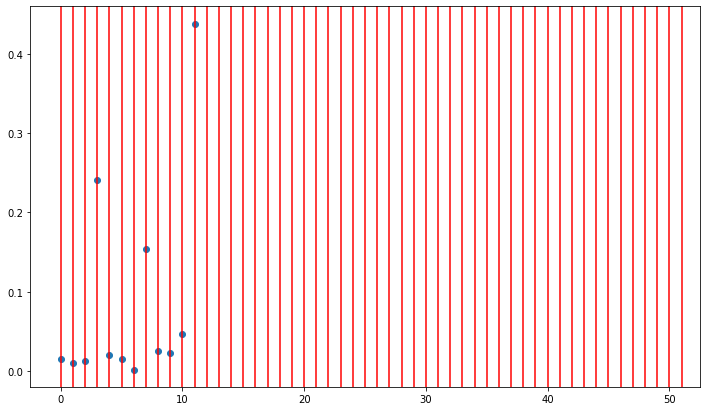

In [200]:
plt.figure(figsize = (12,7))

plt.scatter(np.arange(xgbr.feature_importances_.size),xgbr.feature_importances_)

for x in range(52):
    plt.axvline(x, linestyle ='-', color= 'r')
    
plt.show()

De las 12 semanas utilizadas para predecir el valor siguiente, XGBoost Regressor le otorga mayor "importancia" a las que se encuentran al final. La más importante es la semana 11 del trimestre.

##### Conclusión

El modelo **XGBoost optimizado**  tiene un **mejor desempeño** que el XGBoost original. Devuelve un error RMSE inferior (2570 aprox.) 

Si bien se acerca a los valores e incluso acierta aún más los puntos, la mejora obtenida es baja y continúa **desfasado**.



### Predicción año 2020

Para predecir el 2020, utilizaremos nuestro modelo XGBoost regressor optimizado. 

Crearemos nuestros datos de entrenamiento y luego mediante la estrategia Multi-Step prediction, realizaremos la predicción de las 52 semanas del 2020.

Es decir, se predicen las semanas de a una, incorporando la última predicha como dato para predecir la siguiente. 

Este método puede llegar a tener una gran desventaja. Si el modelo no es preciso, arrastraremos los errores en cada predicción.

#### Preparación de datos

In [201]:
start_date = '2019-10-07'
end_date = '2019-12-29'

XGB_predict = dataset_illia_ef_st_w3_mean[
  (dataset_illia_ef_st_w3_mean.index >= start_date) & 
  (dataset_illia_ef_st_w3_mean.index <= end_date)
].values
XGB_predict.shape

(12, 1)

In [202]:
XGB_predict

array([[37262.85714286],
       [38163.85714286],
       [37564.28571429],
       [39018.42857143],
       [38648.        ],
       [40255.71428571],
       [37785.71428571],
       [38079.28571429],
       [40413.        ],
       [38994.28571429],
       [41840.14285714],
       [32341.42857143]])

In [203]:
XGB_predict = XGB_predict.reshape(1,-1)
XGB_predict.shape

(1, 12)

#### Predicción

In [204]:
i = 0
result_predict = []
    
while (i <=51):
    val_predict = xgbr.predict(XGB_predict)
    #print('val_predict:', val_predict)
    new_predict = XGB_predict
    new_predict = np.append(new_predict, val_predict) #agregar la predicción al último elemento
    new_predict = np.delete(new_predict, 0) #eliminar el primer elemento
    new_predict = new_predict.reshape(1,-1)
    result_predict.append(val_predict.tolist())
    XGB_predict = new_predict
    i = i+1  

In [205]:
#result_predict

In [206]:
resultados_2020 = np.asarray(result_predict)
resultados_2020.shape

(52, 1)

In [207]:
pd.date_range('2020-01','2021-01', freq='W')
df_result_2020 = pd.DataFrame(pd.date_range('2020-01','2021-01', freq='W'))
df_result_2020.rename(columns = {0:'Fecha'}, inplace = True) 
df_result_2020['Prediccion'] = resultados_2020
df_st_result_2020 = df_result_2020.set_index(['Fecha'])

In [208]:
xgb_results_pred_2020 = pd.DataFrame()
xgb_results_pred_2020['Real'] = dataset_illia_ef_real_st_w_mean['cantidad_pasos']
xgb_results_pred_2020['Pred XGB'] = df_st_result_2020['Prediccion']
xgb_results_pred_2020

Real  Pred XGB
fecha                         
2019-01-06  37399.17       NaN
2019-01-13  35439.57       NaN
2019-01-20  36088.14       NaN
2019-01-27  37002.71       NaN
2019-02-03  39509.71       NaN
...              ...       ...
2020-12-06   9797.14  38754.46
2020-12-13   9347.86  39322.91
2020-12-20  10511.14  38754.46
2020-12-27   9633.43  38754.46
2021-01-03  10356.75       NaN

[105 rows x 2 columns]

In [209]:
xgb_results_pred_2020.reset_index(inplace=True)
#xgb_results_pred_2020

#### Gráfico

In [210]:
# Plot 
fig_predict = go.Figure()
fig_predict.add_trace(go.Scatter(x=xgb_results_pred_2020['fecha'], y=xgb_results_pred_2020['Real'],
                    mode='lines+markers',
                    name='Real'))
fig_predict.add_trace(go.Scatter(x=xgb_results_pred_2020['fecha'], y=xgb_results_pred_2020['Pred XGB'],
                    mode='lines+markers',
                    name='Prediccion'))

fig_predict.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_predict.update_layout(
    title="XGBoost - AU Illia - Predicción Efectivo - Año 2020",
    width=800,
    height=500,
)
fig_predict.show()

In [211]:
fig_predict.update_xaxes(range=['2019-10-01', '2020-12-31'])
fig_predict.show()

Como se puede observar, el año 2020 fue atípico en la historia de la humanidad. Nos atravesó una pandemia que generó tomar medidas tales como restricciones en la circularión tanto de personas como vehículos.

El modelo elegido, predice sobre las predicciones anteriores obtenidas. Esto genera que no aprenda mientras fluye el tiempo y si hay errores en la predicción, los arrastra.

Como **conclución** para poder generar una predicción más atinada para el 2020, deberiamos implementar seguramente modelos más complejos y que **contengan más parametros** en cuenta.

# Red Neuronal

Dado que los modelos anteriores no obtuvieron un RMSE más bajo del que deseaba para el 2019, y lejos estuvo de acercarse al 2020, realizaremos una primera aproximación a la utilización de una red neuronal para evaluar su comportamiento y resultados.

Para para trabajar con la red, usaremos Keras y Tensorflow.

## Preprocesamiento de datos para la Red

Para continuar, procedemos a **alterar el flujo de entrada** de la **serie temporal**, para convertirla en un dataframe que pueda alimentar la red neuronal, y que la misma pueda ser entrenada con **backpropagation**. 

Para ello voy a **tomar las 7 semanas previas para “obtener” la 8va** semana. 

- Entradas: serán "7 columnas" que representan la cantidad de vehículos que pasaron las 7 semanas anteriores.
- Salida: La cantidad de vehículos que pasaron en la "semana 8". 


Para hacer esta transformación usaré una función llamada series_to_supervised()


In [212]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

Antes de usar la función, utilizamos el MinMaxScaler para transformar el rango de nuestros valores entre -1 y 1 (a la red neuronal, le favorece para realizar los cálculos).

In [213]:

semanal_st = dataset_illia_ef_st_w3_mean.copy()

# load dataset
values = semanal_st.values

# ensure all data is float
values = values.astype('float32')

#opcional 
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

Entonces aqui vemos cómo queda nuestro set de datos de entrada.

In [214]:
PASOS = 7

# frame as supervised learning

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
7       -0.67       0.39       0.55       0.43       0.44       0.60   
8        0.39       0.55       0.43       0.44       0.60       0.28   
9        0.55       0.43       0.44       0.60       0.28       0.53   
10       0.43       0.44       0.60       0.28       0.53       0.52   
11       0.44       0.60       0.28       0.53       0.52       0.54   

    var1(t-1)  var1(t)  
7        0.28     0.53  
8        0.53     0.52  
9        0.52     0.54  
10       0.54     0.63  
11       0.63     0.70

Utilizo como **entradas** las columnas encabezadas como var1(t-7) a (t-1) y nuestra **salida** (lo que sería el valor “Y” de la función) será el var1(t) -la última columna-.

## Dividimos en set de Entrenamiento y Validación

Antes de crear la red neuronal, subdividiré mi conjunto de datos en **train** y en **test**. 

Algo **importante** de este procedimiento, a diferencia de en otros problemas en los que podemos “mezclar” los datos de entrada, es que en este caso **nos importa mantener el orden** en el que alimentaremos la red. 

**Por lo tanto**, haremos una subdivisión de las primeras 196 **semanas consecutivas** para entrenamiento de la red y las siguientes 12 (octubre, noviembre y diciembre de 2019) para su validación. 


In [215]:
# split into train and test sets
values = reframed.values

n_train_weeks = semanal_st.shape[0]
n_train_weeks = 52*4 - 12

# Tomo los dias desde el 1ro de enero de 2016 hasta 30 de septiembre de 2019
train = values[:n_train_weeks, :]

# Me quedo con la franja del 1ro de octubre al 31 de diciembre de 2019 que son los datos que necesito predecir
test = values[n_train_weeks:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(196, 1, 7) (196,) (7, 1, 7) (7,)


## Red Neuronal LSTM (Long Short Term Memory)

>Son un tipo especial de red neuronal recurrente capaz de aprender dependencias temporales largas, ya que conservan el error y además lo pueden propagar a través del tiempo y las capas. 
>
>Las neuronas de las LSTMs contienen información fuera del flujo normal de la red recurrente en una celda cerrada. 
>
>Esta información se puede almacenar, escribir o leer en una celda. La celda toma decisiones sobre qué almacenar, y cuándo permitir lecturas, escrituras y borrados a través de puertas que se abren y cierran. 
>
>Estas puertas son analógicas, implementadas con la multiplicación de elementos por los sigmoides (están todos en el rango de 0-1). 
>
>Las puertas actúan sobre las señales que reciben, y similares a los nodos de la red neuronal, bloquean o transmiten información basada en su fuerza e importación, que filtran con sus propios conjuntos de pesos. 
>
>Estos pesos, como los pesos que modulan la entrada y los estados ocultos, se ajustan a través del proceso de aprendizaje de las redes recurrentes. 
>Es decir, las celdas aprenden cuándo permitir que los datos entren, salgan o se eliminen a través del proceso iterativo de hacer conjeturas, error de retropropagación y ajustar pesos a través del descenso de gradiente.

La arquitectura de la red neuronal será:

- Entrada 7 inputs
- Una capa oculta con 7 neuronas (este valor lo escogí yo, pero se puede variar)
- La salida será 1 sola neurona
- Como función de activación utilizamos tangente hiperbólica dado que utilizaremos valores entre -1 y 1.
- Optimizador Adam
- Métrica de pérdida (loss) Mean Absolute Error
- Como la predicción será un valor continuo y no discreto, para calcular el Acuracy utilizaremos Mean Squared Error 


Para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.

In [216]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(32, input_shape=(1, PASOS)))
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model


## Entrenamos nuestra máquina

Veamos cómo se comporta nuestra red al cabo de ciertas épocas.

In [217]:
EPOCHS = 50

model= crear_modeloFF()
# fit network
history = model.fit(train_X, train_y,
                    epochs=EPOCHS,
                    validation_data=(test_X,test_y),
                    batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 7)                 231       
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 5,359
Trainable params: 5,359
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
28/28 [==============================] - 3s 69ms/step - loss: 0.2898 - mse: 0.1243 - val_loss: 0.3799 - val_mse: 0.2386
Epoch 2/50
28/28 [==============================] - 0s 5ms/step - loss: 0.1774 - mse: 0.0457 - val_loss: 0.2619 - val_mse

En pocos segundos vemos una reducción del valor de pérdida tanto del set de entrenamiento como del de validación.

#### Exploro los resultados del modelo

In [218]:
#history.history

#### Accuracy

In [219]:
# Obtengo RMSE

mse_list = history.history['mse']
i = 0
rmse_list = []
for val in mse_list:
  #rmse[i] = val.values
  #print(val)
  rmse = sqrt(val)
  rmse_list.append(rmse)
  i += 1

val_mse_list = history.history['val_mse']
i = 0
val_rmse_list = []
for val in val_mse_list:
  #rmse[i] = val.values
  #print(val)
  rmse = sqrt(val)
  val_rmse_list.append(rmse)
  i += 1


In [220]:
cant = len(history.history['mse']) + 1
index_epochs = np.arange(1,cant)
index_epochs = index_epochs.tolist()
index_epochs

accuracy_model = pd.DataFrame(index=index_epochs)

mse_list = history.history['mse']
val_mse_list = history.history['val_mse']

loss_list = history.history['loss']
val_loss_list = history.history['val_loss']

accuracy_model['mse'] = mse_list
accuracy_model['val_mse'] = val_mse_list
accuracy_model['rmse'] = rmse_list
accuracy_model['val_rmse'] = val_rmse_list

accuracy_model['loss'] = loss_list
accuracy_model['val_loss'] = val_loss_list
#accuracy_model


##### MSE

In [221]:
# Plot 
fig = px.line(title='MSE Accuracy by Epochs')
fig.add_scatter(x=accuracy_model.index, y=accuracy_model['mse'], mode='lines+markers', name="MSE")
fig.add_scatter(x=accuracy_model.index, y=accuracy_model['val_mse'], mode='lines+markers', name="MSE Val")
fig.update_xaxes(title="Epochs")
fig.update_yaxes(title="MSE")
fig.update_layout(
    width=900,
    height=500)
fig.show()

##### RMSE

In [222]:
# Plot 
fig = px.line(title='RMSE Accuracy by Epochs')
fig.add_scatter(x=accuracy_model.index, y=accuracy_model['rmse'], mode='lines+markers', name="RMSE")
fig.add_scatter(x=accuracy_model.index, y=accuracy_model['val_rmse'], mode='lines+markers', name="RMSE Val")
fig.update_xaxes(title="Epochs")
fig.update_yaxes(title="RMSE")
fig.update_layout(
    width=900,
    height=500)
fig.show()

#### Loss

In [223]:
# Plot 
fig = px.line(title='Loss by Epochs')
fig.add_scatter(x=accuracy_model.index, y=accuracy_model['loss'], mode='lines+markers', name="Loss")
fig.add_scatter(x=accuracy_model.index, y=accuracy_model['val_loss'], mode='lines+markers', name="Loss Val")
fig.update_xaxes(title="Epochs")
fig.update_yaxes(title="Loss")
fig.update_layout(
    width=900,
    height=500)
fig.show()


Puedo observar cómo disminuye el LOSS a medida que avanzan las épocas, tanto en el conjunto de train como en el conjunto de test. Esto es bueno ya que indica que el modelo está aprendiendo. 

A su vez pareciera no haber overfitting, pues las curvas de train y validate son distintas.

### Resultados del modelo

In [224]:
# make a prediction
yhat = model.predict(test_X)
test_X_in = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_in[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

inv_yhat = inv_yhat[:,0]
predict_list = inv_yhat.tolist()

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_in[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

inv_y = inv_y[:,0]
test_list = inv_y.tolist()

mse = mean_squared_error(inv_y, inv_yhat)
mse_list = mse.tolist()

result_model = pd.DataFrame()
result_model['real'] = test_list
result_model['predict'] = predict_list
result_model['diff'] = result_model['real'] - result_model['predict'] 
result_model['mse'] = mse_list

In [225]:
result_model

real   predict     diff          mse
0  37785.71  39747.32 -1961.61  23748502.00
1  38079.29  38726.15  -646.87  23748502.00
2  40413.00  38772.38  1640.62  23748502.00
3  38994.29  39761.09  -766.80  23748502.00
4  41840.14  39268.51  2571.63  23748502.00
5  32341.43  41120.34 -8778.91  23748502.00
6  27985.00  36645.89 -8660.89  23748502.00

### Grafico Real vs Predicho

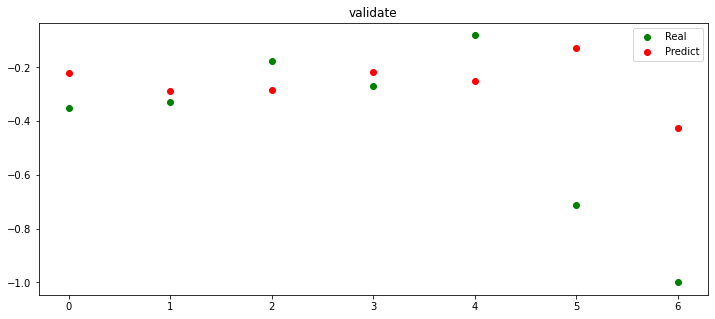

In [226]:
#Test
plt.scatter(range(len(test_y)),test_y, c='g')

#Predicho
results = model.predict(test_X)
plt.scatter(range(len(results)),results, c='r')
plt.title('validate')
plt.legend(['Real','Predict'])
plt.show()


En la gráfica vemos que los puntitos verdes intentan aproximarse a los rojos. Cuanto más cerca ó superpuestos mejor. 
Si aumentamos la cantidad de EPOCHS, mejora cada vez más.


# Predicción 2019

A partir de las últimas 7 semanas previas, predigo el último trimestre del 2019.

In [227]:
ultimasSemanas_train_st = pd.DataFrame()
ultimasSemanas_train_st = semanal_st['2019-08-11':'2019-10-01']
ultimasSemanas_train_st

cantidad_pasos
fecha                     
2019-08-11        39123.86
2019-08-18        39216.14
2019-08-25        37942.00
2019-09-01        39967.86
2019-09-08        39467.29
2019-09-15        38941.71
2019-09-22        39989.57
2019-09-29        41081.14

Y ahora seguiremos el mismo preprocesado de datos que hicimos para el entrenamiento: escalando los valores, llamando a la función series_to_supervised pero esta vez sin incluir la columna de salida “Y” pues es la que queremos hallar. Por eso, verán en el código que hacemos drop() de la última columna.

In [228]:
values = ultimasSemanas_train_st.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed

var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)
7      -0.25      -0.19      -1.00       0.29      -0.03      -0.36       0.30

In [229]:
reframed.shape

(1, 7)

In [230]:
reframed.values

array([[-0.24702072, -0.18822289, -1.        ,  0.29070473, -0.02821732,
        -0.36306572,  0.30454063]], dtype=float32)

De este conjunto ultimasSemanas tomamos sólo la última fila, pues es la que correspondería a las últimas 7 semandas y la dejamos en el formato correcto para la red neuronal con reshape:

In [231]:
reframed_values = reframed.values
x_test = reframed_values[0:, :]
x_test

array([[-0.24702072, -0.18822289, -1.        ,  0.29070473, -0.02821732,
        -0.36306572,  0.30454063]], dtype=float32)

In [232]:
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test.shape

(1, 1, 7)

In [233]:
x_test

array([[[-0.24702072, -0.18822289, -1.        ,  0.29070473,
         -0.02821732, -0.36306572,  0.30454063]]], dtype=float32)

Ahora crearemos una función para ir “rellenando” el desplazamiento que hacemos por cada predicción. Esto es porque queremos predecir el último trimestre.

Entonces para la semana del  1 de octubre de 2019, ya tenemos el set con las últimas 7 semanas previas.


Y así hasta el 31 de diciembre del 2019.

In [234]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [235]:
results=[]
for i in range(15):
  print(i)
  parcial = model.predict(x_test)
  results.append(parcial[0])
  print(x_test)
  x_test=agregarNuevoValor(x_test,parcial[0])

0
[[[-0.24702072 -0.18822289 -1.          0.29070473 -0.02821732
   -0.36306572  0.30454063]]]
1
[[[-0.18822289 -1.          0.29070473 -0.02821732 -0.36306572
    0.30454063  0.10989322]]]
2
[[[-1.          0.29070473 -0.02821732 -0.36306572  0.30454063
    0.10989322 -0.1413949 ]]]
3
[[[ 0.29070473 -0.02821732 -0.36306572  0.30454063  0.10989322
   -0.1413949   0.0053851 ]]]
4
[[[-0.02821732 -0.36306572  0.30454063  0.10989322 -0.1413949
    0.0053851  -0.00694615]]]
5
[[[-0.36306572  0.30454063  0.10989322 -0.1413949   0.0053851
   -0.00694615 -0.11500202]]]
6
[[[ 0.30454063  0.10989322 -0.1413949   0.0053851  -0.00694615
   -0.11500202 -0.04223068]]]
7
[[[ 0.10989322 -0.1413949   0.0053851  -0.00694615 -0.11500202
   -0.04223068 -0.02901644]]]
8
[[[-0.1413949   0.0053851  -0.00694615 -0.11500202 -0.04223068
   -0.02901644 -0.08065099]]]
9
[[[ 0.0053851  -0.00694615 -0.11500202 -0.04223068 -0.02901644
   -0.08065099 -0.0741301 ]]]
10
[[[-0.00694615 -0.11500202 -0.04223068 -0.0290164

## Pronóstico para el 2019

Ya casi lo tenemos… Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala “real” de pasos de vehículos. Entonces vamos a “re-transformar” los datos con el objeto “scaler” que creamos antes.

### Re-Convertimos los resultados

In [236]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[39684.0585274 ],
       [39289.64367442],
       [39520.02548245],
       [39500.67070178],
       [39331.06920185],
       [39445.28907849],
       [39466.02978848],
       [39384.98563456],
       [39395.22063037],
       [39399.46018436],
       [39358.58701024],
       [39354.64446616],
       [39356.52777424],
       [39338.02480966],
       [39328.68438695]])

### Visualizamos el pronóstico

In [237]:
prediccion = pd.DataFrame(inverted)
prediccion.columns = ['pronostico']
prediccion

pronostico
0     39684.06
1     39289.64
2     39520.03
3     39500.67
4     39331.07
5     39445.29
6     39466.03
7     39384.99
8     39395.22
9     39399.46
10    39358.59
11    39354.64
12    39356.53
13    39338.02
14    39328.68

### Agregamos el resultado en el dataset

In [238]:
#Inicializo el dataset
ultimasSemanas_pred_st = ultimasSemanas_train_st.copy()
ultimasSemanas_pred_st['cantidad_pasos']=0
ultimasSemanas_pred_st

i=0
date_start_str = '2019-09-29'
for fila in prediccion.pronostico:
    i=i+1
    ultimasSemanas_pred_st.loc[ date_start_str + ' 00:00:00'] = fila
    date_start_object = datetime.datetime.strptime(date_start_str,'%Y-%m-%d')
    date_start_object = date_start_object + datetime.timedelta(days=7)
    date_start_str = datetime.datetime.strftime(date_start_object,'%Y-%m-%d')
    #print(date_start_str)
    #print(fila)

In [239]:
ultimasSemanas_pred_st

cantidad_pasos
fecha                              
2019-08-11 00:00:00            0.00
2019-08-18 00:00:00            0.00
2019-08-25 00:00:00            0.00
2019-09-01 00:00:00            0.00
2019-09-08 00:00:00            0.00
2019-09-15 00:00:00            0.00
2019-09-22 00:00:00            0.00
2019-09-29 00:00:00        39684.06
2019-10-06 00:00:00        39289.64
2019-10-13 00:00:00        39520.03
2019-10-20 00:00:00        39500.67
2019-10-27 00:00:00        39331.07
2019-11-03 00:00:00        39445.29
2019-11-10 00:00:00        39466.03
2019-11-17 00:00:00        39384.99
2019-11-24 00:00:00        39395.22
2019-12-01 00:00:00        39399.46
2019-12-08 00:00:00        39358.59
2019-12-15 00:00:00        39354.64
2019-12-22 00:00:00        39356.53
2019-12-29 00:00:00        39338.02
2020-01-05 00:00:00        39328.68

In [240]:
ultimasSemanas_test_st = semanal_st['2019-08-11':'2020-01-05']
print(ultimasSemanas_test_st.shape)
ultimasSemanas_test_st

(22, 1)


cantidad_pasos
fecha                     
2019-08-11        39123.86
2019-08-18        39216.14
2019-08-25        37942.00
2019-09-01        39967.86
2019-09-08        39467.29
2019-09-15        38941.71
2019-09-22        39989.57
2019-09-29        41081.14
2019-10-06        38926.14
2019-10-13        37262.86
2019-10-20        38163.86
2019-10-27        37564.29
2019-11-03        39018.43
2019-11-10        38648.00
2019-11-17        40255.71
2019-11-24        37785.71
2019-12-01        38079.29
2019-12-08        40413.00
2019-12-15        38994.29
2019-12-22        41840.14
2019-12-29        32341.43
2020-01-05        27985.00

In [241]:
ultimasSemanas = pd.DataFrame()
ultimasSemanas['Pred RN'] =  ultimasSemanas_pred_st['cantidad_pasos']
ultimasSemanas['Real'] =  ultimasSemanas_test_st['cantidad_pasos']
ultimasSemanas = ultimasSemanas[7:]
ultimasSemanas

Pred RN      Real
fecha                                  
2019-09-29 00:00:00  39684.06  41081.14
2019-10-06 00:00:00  39289.64       NaN
2019-10-13 00:00:00  39520.03       NaN
2019-10-20 00:00:00  39500.67       NaN
2019-10-27 00:00:00  39331.07       NaN
2019-11-03 00:00:00  39445.29       NaN
2019-11-10 00:00:00  39466.03       NaN
2019-11-17 00:00:00  39384.99       NaN
2019-11-24 00:00:00  39395.22       NaN
2019-12-01 00:00:00  39399.46       NaN
2019-12-08 00:00:00  39358.59       NaN
2019-12-15 00:00:00  39354.64       NaN
2019-12-22 00:00:00  39356.53       NaN
2019-12-29 00:00:00  39338.02       NaN
2020-01-05 00:00:00  39328.68       NaN

## Graficamos

In [242]:
ultimasSemanas_results = ultimasSemanas.reset_index(level=0)

# Plot 
fig_results_2019 = go.Figure()
fig_results_2019.add_trace(go.Scatter(x=ultimasSemanas_results['fecha'], y=ultimasSemanas_results['Real'],
                    mode='lines+markers',
                    name='Real'))
fig_results_2019.add_trace(go.Scatter(x=ultimasSemanas_results['fecha'], y=ultimasSemanas_results['Pred RN'],
                    mode='lines+markers',
                    name='Pred RN'))

fig_results_2019.add_trace(go.Scatter(x=xgb_results_pred_2019['fecha'], y=xgb_results_pred_2019['Pred XGB'],
                    mode='lines+markers',
                    name='Pred XGB'))

fig_results_2019.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_results_2019.update_layout(
    title="RNN - AU Illia - Predicción Efectivo - Trimestre 2019",
    width=900,
    height=500,
)
fig_results_2019.show()
                             

# Predicción 2020

A partir del 2019 predigo el 2020

In [243]:
semanal_st = dataset_illia_ef_real_st_w_mean.copy()

ultimasSemanas_train_st = pd.DataFrame()
ultimasSemanas_train_st = semanal_st['2019-11-10':'2019-12-31']
ultimasSemanas_train_st

cantidad_pasos
fecha                     
2019-11-10        38648.00
2019-11-17        40255.71
2019-11-24        37785.71
2019-12-01        38079.29
2019-12-08        40413.00
2019-12-15        38994.29
2019-12-22        41840.14
2019-12-29        32341.43

Y ahora seguiremos el mismo preprocesado de datos que hicimos para 2019:
- Escalando los valores
- Utilizamos la función series_to_supervised sin incluir la columna de salida “Y”.

In [244]:
values = ultimasSemanas_train_st.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed

var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)
7       0.33       0.67       0.15       0.21       0.70       0.40       1.00

In [245]:
reframed.shape

(1, 7)

In [246]:
reframed.values

array([[0.32787943, 0.6663909 , 0.14632082, 0.20813322, 0.6995082 ,
        0.4007907 , 1.0000005 ]], dtype=float32)

De este conjunto “ultimasSemanas” tomamos sólo la última fila, pues es la que correspondería a las últimos 7 semandas y la dejamos en el formato correcto para la red neuronal con reshape:

In [247]:
reframed_values = reframed.values
x_test = reframed_values[0:, :]
x_test

array([[0.32787943, 0.6663909 , 0.14632082, 0.20813322, 0.6995082 ,
        0.4007907 , 1.0000005 ]], dtype=float32)

In [248]:
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test.shape

(1, 1, 7)

In [249]:
x_test

array([[[0.32787943, 0.6663909 , 0.14632082, 0.20813322, 0.6995082 ,
         0.4007907 , 1.0000005 ]]], dtype=float32)

Ahora utilizamos la función para ir “rellenando” el desplazamiento que hacemos por cada predicción. 

In [250]:
results=[]
for i in range(54):
  print(i)
  parcial = model.predict(x_test)
  results.append(parcial[0])
  print(x_test)
  x_test=agregarNuevoValor(x_test,parcial[0])

0
[[[0.32787943 0.6663909  0.14632082 0.20813322 0.6995082  0.4007907
   1.0000005 ]]]
1
[[[0.6663909  0.14632082 0.20813322 0.6995082  0.4007907  1.0000005
   0.76467353]]]
2
[[[0.14632082 0.20813322 0.6995082  0.4007907  1.0000005  0.76467353
   0.65217954]]]
3
[[[0.20813322 0.6995082  0.4007907  1.0000005  0.76467353 0.65217954
   0.69822836]]]
4
[[[0.6995082  0.4007907  1.0000005  0.76467353 0.65217954 0.69822836
   0.7193669 ]]]
5
[[[0.4007907  1.0000005  0.76467353 0.65217954 0.69822836 0.7193669
   0.68544537]]]
6
[[[1.0000005  0.76467353 0.65217954 0.69822836 0.7193669  0.68544537
   0.73123544]]]
7
[[[0.76467353 0.65217954 0.69822836 0.7193669  0.68544537 0.73123544
   0.7246609 ]]]
8
[[[0.65217954 0.69822836 0.7193669  0.68544537 0.73123544 0.7246609
   0.71487236]]]
9
[[[0.69822836 0.7193669  0.68544537 0.73123544 0.7246609  0.71487236
   0.72239083]]]
10
[[[0.7193669  0.68544537 0.73123544 0.7246609  0.71487236 0.72239083
   0.72502786]]]
11
[[[0.68544537 0.73123544 0.72466

## Pronóstico para el 2020

Ya casi lo tenemos… Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala “real” de unidades vendidas. Entonces vamos a “re-transformar” los datos con el objeto “scaler” que creamos antes.

### Re-Convertimos los resultados

In [251]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[40722.4935294 ],
       [40188.21925643],
       [40406.92160161],
       [40507.31614387],
       [40346.21059763],
       [40563.68407598],
       [40532.45908205],
       [40485.9699258 ],
       [40521.677835  ],
       [40534.20202909],
       [40521.49835986],
       [40541.33659046],
       [40544.89438783],
       [40542.79164126],
       [40548.46605631],
       [40551.66263874],
       [40551.95676282],
       [40554.81534317],
       [40556.46090938],
       [40557.17626218],
       [40558.46174578],
       [40559.44291428],
       [40560.02068834],
       [40560.72556704],
       [40561.28210981],
       [40561.67559632],
       [40562.06568581],
       [40562.39038295],
       [40562.63808128],
       [40562.86483142],
       [40563.05393141],
       [40563.20566433],
       [40563.33814756],
       [40563.44968258],
       [40563.54083557],
       [40563.61924978],
       [40563.68492523],
       [40563.73927732],
       [40563.78541998],
       [40563.82420246],


In [252]:
prediccion = pd.DataFrame(inverted)
prediccion.columns = ['pronostico']
prediccion

pronostico
0     40722.49
1     40188.22
2     40406.92
3     40507.32
4     40346.21
5     40563.68
6     40532.46
7     40485.97
8     40521.68
9     40534.20
10    40521.50
11    40541.34
12    40544.89
13    40542.79
14    40548.47
15    40551.66
16    40551.96
17    40554.82
18    40556.46
19    40557.18
20    40558.46
21    40559.44
22    40560.02
23    40560.73
24    40561.28
25    40561.68
26    40562.07
27    40562.39
28    40562.64
29    40562.86
30    40563.05
31    40563.21
32    40563.34
33    40563.45
34    40563.54
35    40563.62
36    40563.68
37    40563.74
38    40563.79
39    40563.82
40    40563.86
41    40563.88
42    40563.91
43    40563.93
44    40563.94
45    40563.96
46    40563.97
47    40563.98
48    40563.98
49    40563.99
50    40564.00
51    40564.00
52    40564.01
53    40564.01

### Agregamos el resultado en el dataset

In [253]:
#Inicializo el dataset
ultimasSemanas_pred_st = ultimasSemanas_train_st.copy()
ultimasSemanas_pred_st['cantidad_pasos']=0
ultimasSemanas_pred_st

i=0
date_start_str = '2019-12-29'
for fila in prediccion.pronostico:
    i=i+1
    ultimasSemanas_pred_st.loc[ date_start_str + ' 00:00:00'] = fila
    date_start_object = datetime.datetime.strptime(date_start_str,'%Y-%m-%d')
    date_start_object = date_start_object + datetime.timedelta(days=7)
    date_start_str = datetime.datetime.strftime(date_start_object,'%Y-%m-%d')
    #print(date_start_str)
    #print(fila)

In [254]:
ultimasSemanas_pred_st = ultimasSemanas_pred_st[7:]
ultimasSemanas_pred_st.head(15)

cantidad_pasos
fecha                              
2019-12-29 00:00:00        40722.49
2020-01-05 00:00:00        40188.22
2020-01-12 00:00:00        40406.92
2020-01-19 00:00:00        40507.32
2020-01-26 00:00:00        40346.21
2020-02-02 00:00:00        40563.68
2020-02-09 00:00:00        40532.46
2020-02-16 00:00:00        40485.97
2020-02-23 00:00:00        40521.68
2020-03-01 00:00:00        40534.20
2020-03-08 00:00:00        40521.50
2020-03-15 00:00:00        40541.34
2020-03-22 00:00:00        40544.89
2020-03-29 00:00:00        40542.79
2020-04-05 00:00:00        40548.47

In [255]:
ultimasSemanas_test_st = semanal_st['2019-12-29':'2021-01-03']
print(ultimasSemanas_test_st.shape)
ultimasSemanas_test_st

(54, 1)


cantidad_pasos
fecha                     
2019-12-29        32341.43
2020-01-05        29513.29
2020-01-12        34765.57
2020-01-19        35259.71
2020-01-26        34456.00
2020-02-02        36190.71
2020-02-09        35306.43
2020-02-16        37351.14
2020-02-23        36728.00
2020-03-01        33641.00
2020-03-08        36415.71
2020-03-15        31827.57
2020-03-22        15407.86
2020-03-29            0.00
2020-04-05            0.00
2020-04-12            0.00
2020-04-19            0.00
2020-04-26            0.00
2020-05-03            0.00
2020-05-10            0.00
2020-05-17            0.14
2020-05-24         7269.00
2020-05-31         7844.86
2020-06-07        10070.43
2020-06-14        10921.71
2020-06-21        10246.71
2020-06-28        11610.71
2020-07-05        10534.14
2020-07-12         8683.29
2020-07-19        11207.00
2020-07-26        12086.43
2020-08-02        13204.14
2020-08-09        13364.71
2020-08-16        13417.29
2020-08-23        11678.00
2020-08-30        11842.57
2020-09-06        11058.43
2020-09-13        11162.43
2020-09-20         9964.14
2020-09-27         8741.57
2020-10-04         4940.43
2020-10-11         5010.43
2020-10-18         5419.14
2020-10-25         5246.29
2020-11-01         6300.43
2020-11-08         6977.14
2020-11-15         7577.14
2020-11-22         8740.14
2020-11-29         8290.00
2020-12-06         9797.14
2020-12-13         9347.86
2020-12-20        10511.14
2020-12-27         9633.43
2021-01-03        10356.75

In [256]:
ultimasSemanas = pd.DataFrame()
ultimasSemanas['Pred RN'] =  ultimasSemanas_pred_st['cantidad_pasos']
ultimasSemanas['Real'] =  ultimasSemanas_test_st['cantidad_pasos']
ultimasSemanas = ultimasSemanas[7:]
ultimasSemanas

Pred RN  Real
fecha                              
2020-02-16 00:00:00  40485.97   NaN
2020-02-23 00:00:00  40521.68   NaN
2020-03-01 00:00:00  40534.20   NaN
2020-03-08 00:00:00  40521.50   NaN
2020-03-15 00:00:00  40541.34   NaN
2020-03-22 00:00:00  40544.89   NaN
2020-03-29 00:00:00  40542.79   NaN
2020-04-05 00:00:00  40548.47   NaN
2020-04-12 00:00:00  40551.66   NaN
2020-04-19 00:00:00  40551.96   NaN
2020-04-26 00:00:00  40554.82   NaN
2020-05-03 00:00:00  40556.46   NaN
2020-05-10 00:00:00  40557.18   NaN
2020-05-17 00:00:00  40558.46   NaN
2020-05-24 00:00:00  40559.44   NaN
2020-05-31 00:00:00  40560.02   NaN
2020-06-07 00:00:00  40560.73   NaN
2020-06-14 00:00:00  40561.28   NaN
2020-06-21 00:00:00  40561.68   NaN
2020-06-28 00:00:00  40562.07   NaN
2020-07-05 00:00:00  40562.39   NaN
2020-07-12 00:00:00  40562.64   NaN
2020-07-19 00:00:00  40562.86   NaN
2020-07-26 00:00:00  40563.05   NaN
2020-08-02 00:00:00  40563.21   NaN
2020-08-09 00:00:00  40563.34   NaN
2020-08-16 00:00:00  40563.45   NaN
2020-08-23 00:00:00  40563.54   NaN
2020-08-30 00:00:00  40563.62   NaN
2020-09-06 00:00:00  40563.68   NaN
2020-09-13 00:00:00  40563.74   NaN
2020-09-20 00:00:00  40563.79   NaN
2020-09-27 00:00:00  40563.82   NaN
2020-10-04 00:00:00  40563.86   NaN
2020-10-11 00:00:00  40563.88   NaN
2020-10-18 00:00:00  40563.91   NaN
2020-10-25 00:00:00  40563.93   NaN
2020-11-01 00:00:00  40563.94   NaN
2020-11-08 00:00:00  40563.96   NaN
2020-11-15 00:00:00  40563.97   NaN
2020-11-22 00:00:00  40563.98   NaN
2020-11-29 00:00:00  40563.98   NaN
2020-12-06 00:00:00  40563.99   NaN
2020-12-13 00:00:00  40564.00   NaN
2020-12-20 00:00:00  40564.00   NaN
2020-12-27 00:00:00  40564.01   NaN
2021-01-03 00:00:00  40564.01   NaN

In [257]:
ultimasSemanas_results = ultimasSemanas.reset_index(level=0)

# Plot 
fig_results_2020 = go.Figure()
fig_results_2020.add_trace(go.Scatter(x=ultimasSemanas_results['fecha'], y=ultimasSemanas_results['Real'],
                    mode='lines+markers',
                    name='Real'))
fig_results_2020.add_trace(go.Scatter(x=ultimasSemanas_results['fecha'], y=ultimasSemanas_results['Pred RN'],
                    mode='lines+markers',
                    name='Pred RN'))

fig_results_2020.add_trace(go.Scatter(x=xgb_results_pred_2020['fecha'], y=xgb_results_pred_2020['Pred XGB'],
                    mode='lines+markers',
                    name='Pred XGB'))

fig_results_2020.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_results_2020.update_layout(
    title="RNN - AU Illia - Predicción Efectivo - Trimestre Año",
    width=900,
    height=500,
)
fig_results_2020.show()
                             

Como se puede apreciar, será necesario continuar indagando y trabajando con redes neuronales. 
Si bien fue una primera aproximación, el resultado lejos estuvo del esperado.

Al momento, el mejor modelo obtenido fué el **XGB con optimización de parámetros**.

# Otros disparadores

## Disparador A

**¿Es posible incorporar la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.?**

Por supuesto que se podría incorporar con métodos como el **OneHotEncoder**. 
Si nos preguntáramos respectos a si mejorarían las predicciones, seguramente mejoren. De esta forma los modelos tendrían más información que la *cantidad de vehículos* que pasan y eso permitirá tomar decisiones más atinadas.

Para abordar modelos con más información, es importante contemplar que el mismo, esté "saturado" de información/variables, dado que correríamos el riesgo de **overfiterar** el modelo. 

En conclusión, se debería estudiar y analizar cuales serian las variables más atinadas que mejoren el modelo sin overfitearlo, y de esa forma encontrar el equilibrio.

Éste sería el próximo paso en la evolución del proyecto. Para ello, me propongo seguir explorando redes neuronales. Hay dos modelos que tomaron particularmente mi atención:

- LSTM Multivariable
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

- Redes neuronales con Embeddings
https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526


## Disparador B

**¿Qué ocurre si comparamos las series de tiempo entre distintas estaciones de peajes? 
¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras?
Si es así, ¿hay información auxiliar que nos ayude a explicar lo que encontramos?**



Para responder este interrogante generaremos un dataset con los datos que poseemos pero **contemplando todas las estacione** de peaje. 

También, decido dejar **todas las modalidades de pago** para ver la tendencia sin que la modalidad influya. Mi decisión respecto a ésto es porque además de año año quedar en desuso (efectivo), a partir del 28 de septiempre de 2020 será [obligatorio el pago con Telepase](https://www.buenosaires.gob.ar/jefaturadegabinete/movilidad/noticias/por-el-alto-numero-de-adhesiones-diarias-habra-tiempo-hasta-el).
Y entindo que para los proximos desarrollos, será más importante analizar todas modalidades de pago vigente.

Para proceder realizaremos algunas **transformaciones** de datos. Recordemos que según cada año hay nombres de estaciones que cambiaron. Para simplificar la visualización, unificaremos las variantes.

In [258]:
print('Estaciones en 2020')
print(data_2020_full['estacion'].unique())
print('\nEstaciones en 2019')
print(data_2019['estacion'].unique())
print('\nEstaciones en 2018')
print(data_2018['estacion'].unique())
print('\nEstaciones en 2017')
print(data_2017['estacion'].unique())
print('\nEstaciones en 2016')
print(data_2016['estacion'].unique())

Estaciones en 2020
['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']

Estaciones en 2019
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']

Estaciones en 2018
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

Estaciones en 2017
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

Estaciones en 2016
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [259]:
#Agrupo todos los años 
stations = pd.concat([data_2020_full,data_2019,data_2018,data_2017,data_2016])

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
stations['fecha2'] = pd.to_datetime(stations.fecha) + pd.to_timedelta(stations.hora_fin, unit = 'h')

#Quitamos las columnas que ya no vamos a utilizar
stations.drop(columns=['Unnamed: 0','periodo','mes','dia','dia_fecha','observacion','sentido','fecha','hora_inicio','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
stations.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
stations.sort_values('fecha', inplace = True)
stations.reset_index(drop=True, inplace = True)

stations

estacion tipo_vehiculo            forma_pago  cantidad_pasos  \
0             Illia        Pesado              EFECTIVO            1.00   
1             Illia        Pesado                EXENTO            4.00   
2             Illia       Liviano                AUPASS          195.00   
3             Illia       Liviano            INFRACCION            3.00   
4             Illia       Liviano  TARJETA DISCAPACIDAD            7.00   
...             ...           ...                   ...             ...   
7473887       ILLIA          Auto                   Tag           25.00   
7473888       ILLIA          Auto                   Tag           99.00   
7473889       ILLIA          Auto                   Tag          120.00   
7473890     ALBERDI          Auto          Mercado Pago            1.00   
7473891  AVELLANEDA          Moto                   Tag            1.98   

                      fecha  
0       2016-01-01 00:00:00  
1       2016-01-01 00:00:00  
2       2016-01-01 00:00:00  
3       2016-01-01 00:00:00  
4       2016-01-01 00:00:00  
...                     ...  
7473887 2020-12-31 23:00:00  
7473888 2020-12-31 23:00:00  
7473889 2020-12-31 23:00:00  
7473890 2020-12-31 23:00:00  
7473891 2020-12-31 23:00:00  

[7473892 rows x 5 columns]

In [260]:
# Previsualizo modalidades de pago
stations['forma_pago'] = stations['forma_pago'].str.title()
stations['forma_pago'].unique()

array(['Efectivo', 'Exento', 'Aupass', 'Infraccion',
       'Tarjeta Discapacidad', 'No Cobrado', 'Monedero', 'Telepase',
       'Otros', 'T. Discapacidad', 'Tag', 'Rec.Deuda', 'Violación',
       'Tarjeta Magnética', 'Cpp', 'Mercado Pago'], dtype=object)

In [261]:
# Previsualizo estaciones
stations['estacion'] = stations['estacion'].str.title()
stations['estacion'].unique()

array(['Illia', 'Dellepiane Liniers', 'Dellepiane Centro', 'Alberdi',
       'Retiro', 'Sarmiento', 'Avellaneda', 'Salguero', 'Alberti',
       'Dellepiane', 'Pdb', 'Dellepiane Linierslepiane Centro', 'Pb3',
       'Ilp', 'Pb4', 'Pb2', 'Pb1'], dtype=object)

In [262]:
# Unifico estaciones
stations['estacion'] = stations['estacion'].replace({
    'Dellepiane Liniers': 'Dellepiane',
    'Dellepiane Centro': 'Dellepiane',
    'Dellepiane Linierslepiane Centro':'Dellepiane',
    'Dellepiane Linierslepiane Centro':'Dellepiane',
    'Pb1':'PDB',
    'Pb2':'PDB',
    'Pb3':'PDB',
    'Pb4':'PDB',
    'Pdb':'PDB',
    'Ilp':'Illia',
    'Alberti': 'Alberdi',
})

In [263]:
# Verifico estaciones
stations['estacion'].unique()

array(['Illia', 'Dellepiane', 'Alberdi', 'Retiro', 'Sarmiento',
       'Avellaneda', 'Salguero', 'PDB'], dtype=object)

In [264]:
# Genero las series de tiempo

station_1 = stations[stations.estacion == 'Illia']
stations_st1 = pd.DataFrame()
stations_st1 = station_1.resample('m', on = 'fecha').sum()
stations_g1 = stations_st1.reset_index()

station_2 = stations[stations.estacion == 'Dellepiane']
stations_st2 = pd.DataFrame()
stations_st2 = station_2.resample('m', on = 'fecha').sum()
stations_g2 = stations_st2.reset_index()

station_3 = stations[stations.estacion == 'Alberdi']
stations_st3 = pd.DataFrame()
stations_st3 = station_3.resample('m', on = 'fecha').sum()
stations_g3 = stations_st3.reset_index()

station_4 = stations[stations.estacion == 'Retiro']
stations_st4 = pd.DataFrame()
stations_st4 = station_4.resample('m', on = 'fecha').sum()
stations_g4 = stations_st4.reset_index()

station_5 = stations[stations.estacion == 'Sarmiento']
stations_st5 = pd.DataFrame()
stations_st5 = station_5.resample('m', on = 'fecha').sum()
stations_g5 = stations_st5.reset_index()

station_6 = stations[stations.estacion == 'Avellaneda']
stations_st6 = pd.DataFrame()
stations_st6 = station_6.resample('m', on = 'fecha').sum()
stations_g6 = stations_st6.reset_index()

station_7 = stations[stations.estacion == 'Salguero']
stations_st7 = pd.DataFrame()
stations_st7 = station_7.resample('m', on = 'fecha').sum()
stations_g7 = stations_st7.reset_index()

station_8 = stations[stations.estacion == 'PDB']
stations_st8  = pd.DataFrame()
stations_st8 = station_8.resample('m', on = 'fecha').sum()
stations_g8 = stations_st8.reset_index()



In [265]:
# Plot 
fig_station = go.Figure()

fig_station.add_trace(go.Scatter(x=stations_g1['fecha'], y=stations_g1['cantidad_pasos'],
                    mode='lines+markers',
                    name='Illia'))
fig_station.add_trace(go.Scatter(x=stations_g2['fecha'], y=stations_g2['cantidad_pasos'],
                    mode='lines+markers',
                    name='Dellepiane'))
fig_station.add_trace(go.Scatter(x=stations_g3['fecha'], y=stations_g3['cantidad_pasos'],
                    mode='lines+markers',
                    name='Alberdi'))
fig_station.add_trace(go.Scatter(x=stations_g4['fecha'], y=stations_g4['cantidad_pasos'],
                    mode='lines+markers',
                    name='Retiro'))
fig_station.add_trace(go.Scatter(x=stations_g5['fecha'], y=stations_g5['cantidad_pasos'],
                    mode='lines+markers',
                    name='Sarmiento'))
fig_station.add_trace(go.Scatter(x=stations_g6['fecha'], y=stations_g6['cantidad_pasos'],
                    mode='lines+markers',
                    name='Avellaneda'))
fig_station.add_trace(go.Scatter(x=stations_g7['fecha'], y=stations_g7['cantidad_pasos'],
                    mode='lines+markers',
                    name='Salguero'))
fig_station.add_trace(go.Scatter(x=stations_g8['fecha'], y=stations_g8['cantidad_pasos'],
                    mode='lines+markers',
                    name='PDB'))

fig_station.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_station.update_layout(
    title="Tránsito vehicular AUSA 2016 a 2020",
    width=900,
    height=500,
)
fig_station.show()

Claramente el **2020** fue un año **atipico**, donde las medidas de gobierno y la ciudadania, cambió su comportamiento respecto a la **circulación**.

Como se puede apreciar en el gráfico, la tendencia es negativa para todas las estaciones excepto para Salguero (De puede observar en el gráfico una a una o todas juntas y eso facilita la visualización). 

Más allá de eso, hay dos cuestiones que deseo destacar:

- El **pico negativo** de abril del 2020 que genera una alza en los meses subsiguientes. 
- La inaguración **del Paseo del Bajo**, donde se aprecia entre los meses de junio de 2019 a Diciembre de 2020 una gran afluencia de vehículos.

También podemos decir que hay **3 grandes grupos de afluencia**:

- Alta: La Au Avellaneda lleva la punta duplicando la cantidad de pasos de las del grupo de las medianas. 
- Mediana: La AU Dellepianne y la AU Illia tienen una afulencia similar.
- Baja: Finalmente Alberdi, Salguero y Retiro se mantienen como las AU con menor afluencia. 

## Disparador C

**¿Hay algo que podríamos investigar o probar más alla de lo planteado inicialmente?**

Si, me gustaría investigar en profundidad redes neuronales en pos de lograr un mejor modelo y una predicción más precisa con respecto al 2020.  

El trabajo lo focalizaría con todas las modalidades de pago e investigaría particlualmente cuales son similares y cuales no representan a la misma metodología para diferenciar/agrupar las mismas ('Efectivo', 'Exento', 'Aupass', 'Infraccion', 'Tarjeta Discapacidad', 'No Cobrado', 'Monedero', 'Telepase', 'Otros', 'T. Discapacidad', 'Tag', 'Rec.Deuda', 'Violación', 'Tarjeta Magnética', 'Cpp', 'Mercado Pago').

A su vez analizaría que otroa información podría aportarme el campo observaciones, recientemente incorporado en el 2020.

Finalmente además de probar multivariables o OneHotEncoding, buscaría otros datos que puedan aportar información al modelo. Como por ejemplo el precio de la tarifa del peaje.

Este es mi desafío para el próximo proyecto.